# Code of the final analyses performed for the paper: 
Date created: 20 July 2022<br>
Date last updated: 18 Oct 2022<br>
Author: Roshan Rane, Milena Musial <br>

In [1]:
# standard python packages
import os, sys
from glob import glob
from os.path import join 
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from scikits.bootstrap import ci
from scipy import stats

import seaborn as sns
sns.set(style="whitegrid", context='paper', color_codes=False)
sys.path.append("../MLpipelines")
from plotResults import *

import h5py
import random
import math
import json

In [2]:
H5_DIR = "/ritter/share/data/IMAGEN/h5files/"
CONF_DATA_DIR = "/ritter/share/data/IMAGEN/posthoc/"
RESULTS_DIR = "/ritter/roshan/workspace/ML_for_IMAGEN/MLpipelines/results/"

In [3]:
H5_FILES = {
    "h5causal0" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477.h5",
    "h5causal1" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565.h5",
    # Take the 3 h5files used in paper
    "h5fu3" : "newlbls-clean-fu3-espad-fu3-19a-binge-n650.h5",
    "h5fu2" : "newlbls-clean-fu2-espad-fu3-19a-binge-n634.h5",
    "h5bl" : "newlbls-clean-bl-espad-fu3-19a-binge-n620.h5",
}

In [4]:
H5_FILES_HOLD = {
    "h5causal0" : "newholdout-clean-bl-espad-fu3-19a-binge-causal-onset0-n78.h5",
    "h5causal1" : "newholdout-clean-bl-espad-fu3-19a-binge-causal-onset1-n90.h5",
    # Take the 3 h5files used in paper
    "h5fu3" : "newholdout-clean-fu3-espad-fu3-19a-binge-n102.h5",
    "h5fu2" : "newholdout-clean-fu2-espad-fu3-19a-binge-n102.h5",
    "h5bl" : "newholdout-clean-bl-espad-fu3-19a-binge-n102.h5",
}

MAP_H5CAT_TO_RUN = {
    'h5causal1': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565/20220726-1119/run.csv",
    'h5causal0': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477/20220414-1352/run.csv",
    'h5fu3': RESULTS_DIR+"/newlbls-clean-fu3-espad-fu3-19a-binge-n650/20211026-1911/run.csv",
    'h5fu2': RESULTS_DIR+"/newlbls-clean-fu2-espad-fu3-19a-binge-n634/20210618-1701/run.csv",
    'h5bl': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-n620/20211026-1810/run.csv",
}

MAP_H5CAT_TO_HOLDRUN = {
    'h5causal1': RESULTS_DIR+"/holdout-causal-onset1_run.csv",
    'h5causal0': RESULTS_DIR+"/holdout-causal-onset0_run.csv",
    'h5fu3': RESULTS_DIR+"/holdout_all-tp-clean_run.csv",
    'h5fu2': RESULTS_DIR+"/holdout_all-tp-clean_run.csv",
    'h5bl': RESULTS_DIR+"/holdout_all-tp-clean_run.csv",
        }

## Useful helper functions

### H5 file inspection funcs

In [5]:
def plot_dists(h5, lbl, col_names, suptitle=''):
    
    df = pd.DataFrame({c:h5[c][()] for c in [lbl]+col_names})
    df.index = h5["i"][()]
    
    if len(df[lbl].unique())>2:
        print("lbl has more than 2 states and in range [{}, {}, {}] \n aborting distribution plots .....".format(
                df[lbl].min(), df[lbl].mean(), df[lbl].max())) 
    else:        
        f, axes = plt.subplots(1, len(col_names)+1, figsize=(4*(len(col_names)+1), 3))
        if suptitle: plt.suptitle(suptitle)

        val = dict(df[lbl].astype(int).astype('str').value_counts())
        axes[0].pie(list(val.values()), labels = list(val.keys()), autopct='%1.0f%%', shadow=True, startangle=90) 
        axes[0].axis('equal')

        for ax, c in zip(axes[1:], col_names):
            if len(df[c].unique())<=10: # then bar plot
                dfi = df[[c,lbl]].value_counts(dropna=False).unstack().sort_index()

                dfi.sort_index().plot.bar(
                    stacked=True, title=c, legend=True, 
                    alpha=0.5, sort_columns=True, 
                    grid=True, rot=90, ax=ax, width=0.9)
    #             for i, x in enumerate(dfi.values):
    #                 ax.text(i, x+(x/100)+1, str(x))

            else: # histogram
                for lbl_i, dfi in df.groupby(lbl):
                    lbl_i = int(lbl_i)
                    dfi[c].plot.hist(label="lbl="+str(lbl_i), title=c,
                                     grid=True, alpha=0.5, legend=True, bins=10, ax=ax)

        plt.legend()   
        plt.show()

def check_h5_contents(H5_FILES, ignore=''):
    
    if isinstance(H5_FILES, str): H5_FILES = [H5_FILES]
    
    for k, h5_files_glob in enumerate(H5_FILES):
        
        for h5_file in glob(h5_files_glob):
            print("______________________________________________________________________________________")
            if ignore and ignore in h5_file:
                print(f"ignoring '{h5_file}' because of the ignore str '{ignore}'")
            else:            
                with h5py.File(h5_file, 'r') as h5:
                    print("filename: {} \n h5.columns = {} \n h5.attrs = {}".format(
                        h5_file.split("/")[-1], list(h5.keys()), list(h5.attrs.keys())))

                    try:
                        n = len(h5["i"])
                        y = h5.attrs['labels'][0]
                        conf_names=h5.attrs["confs"].tolist()
                        print("n = {} \t label = {} \t X.shape = {}  \t confs = {}".format( 
                            n, y, h5["X"].shape, conf_names))

                        # plot the confs and label distributions in the data
                        print("label and conf with distributions:")
                        plot_dists(h5, y, conf_names)

                    except Exception as e:  print(e) 

                    # plot a random subject's brain image in the data 
                    random_i = random.randint(0, n-1)
                    img = h5["X"][random_i]
                    print("\nsubject: {} \t (min={:.2f}, mean={:.2f}, max={:.2f})".format(
                        h5["i"][random_i], img.min(), img.mean(), img.max()))
                    
                    for conf in  conf_names:
                        if conf not in ['sex','site']:
                            print(f"conf {conf} == label {y} ? \t True for n={np.sum(h5[conf][:]==h5[y][:])}/{n}")

In [6]:
def print_h5_for_MLpipeline(h5_dir=H5_DIR, filter_func=lambda filename: 'posthoc-cc-bl' in filename and 'causal' in filename):
    
    # print(f"  DATA_DIR + 'h5files/{ori_h5_file}',")
    for h5file in sorted(os.listdir(h5_dir)):
        if filter_func(h5file):
            print(f"  DATA_DIR + 'h5files/{h5file}',")

### attach conf to H5 files

In [7]:
# add binge itself as a conf
def attach_conf_fromseries(H5_DIR, to_h5, conf, prepend='h5causal1', print_all=True):
    
    # create a new h5 file name
    out_h5 = '-'.join(['posthoc-cc2',prepend,conf.name])+'.h5'
    if print_all: print("writing to ..", out_h5)
    # assert not os.path.exists(H5_DIR+out_h5), "[ERROR] file already exists.. skipping h5file creation. Remove it manually first"

    try:
        with h5py.File(H5_DIR+out_h5, 'w') as data_out:
            # first just copy all h5 file data to new h5 file    
            with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
                for dataset in data_dest:
                    data_out.create_dataset(dataset, data=data_dest[dataset]) 
                for attr in data_dest.attrs:
                    data_out.attrs[attr]=data_dest.attrs[attr]

            # now add the confound
            if conf.name not in data_out.attrs['confs']:

                if print_all: print(f"attaching conf {conf.name}")
                data_out.attrs['confs'] = list(data_out.attrs['confs'])+[conf.name]
                # align the subject IDs to fill the right conf value for each subject in the h5
                h5_sub_ids = data_out['i'][:]
                # below script works only if the IDs in src data h5 are arranged in an ascending order
                assert np.all(h5_sub_ids[:-1] <= h5_sub_ids[1:]), f"subject IDs in {to_h5} are not in ascending order.. change the algo below ?!"
                conf = conf.sort_index()
                h5_sub_ids_in_conf = np.argwhere(np.isin(h5_sub_ids, conf.index)).ravel()
                conf_sub_ids_in_h5 = np.argwhere(np.isin(conf.index, h5_sub_ids)).ravel()
                assert len(h5_sub_ids_in_conf)==len(conf_sub_ids_in_h5)
                data_out.create_dataset(conf.name, data=conf.iloc[conf_sub_ids_in_h5]) 

                # check if the distribution of confound is acceptable
                assert conf.iloc[conf_sub_ids_in_h5].nunique()==2, f"conf has n_classes= \
{conf.iloc[conf_sub_ids_in_h5].nunique()}. If n_classes>2 then it was not correctly\
 binarized. If n_classes=1 then all subjects are getting categorized into a single class."
                for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():
                    assert counts>=0.15*len(conf_sub_ids_in_h5), f"\
the value {val} in {conf.name} has fewer than 15% instances (n={counts})\
\nThis is very small for counter balancing to work properly.."

                # remove subject IDs missing the conf info
                if len(h5_sub_ids_in_conf)<len(h5_sub_ids):

                    print(f"[WARN] n={len(h5_sub_ids)-len(h5_sub_ids_in_conf)} subs missing this conf information. \
Dropping sample size from {len(h5_sub_ids)} to {len(h5_sub_ids_in_conf)}")
                    existing_datasets = list(data_out.keys())
                    existing_datasets.remove(conf.name)
                    # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                    for existing_dataset in existing_datasets:
                        new_data = data_out[existing_dataset][h5_sub_ids_in_conf] 
                        del data_out[existing_dataset] 
                        data_out.create_dataset(existing_dataset, data=new_data) 

    except Exception as e:
        if os.path.isfile(H5_DIR+out_h5): os.remove(H5_DIR+out_h5)
        raise e

In [8]:
def attach_conf_fromh5(H5_DIR, from_h5, to_h5, print_all=True):
    
    # create a new h5 file name
    out_h5 = "-".join(from_h5.split('-')[:-1])+"-"+ "-".join(to_h5.split('-')[-4:])
    if print_all: print("writing to ..", out_h5)
    
    with h5py.File(H5_DIR+out_h5, 'w') as data_out:
        # first just copy all h5 file data to new h5 file    
        with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
            for dataset in data_dest:
                data_out.create_dataset(dataset, data=data_dest[dataset]) 
            for attr in data_dest.attrs:
                data_out.attrs[attr]=data_dest.attrs[attr]
            
        # now add the confound
        with h5py.File(H5_DIR+from_h5, 'r') as data_src:
                for dataset in data_src:
                    if dataset not in data_out:
                        if print_all: print(f"attaching conf {dataset}")
                        data_out.attrs['confs'] = list(data_out.attrs['confs'])+[dataset]
                        # match subject IDs
                        src_sub_ids = data_src['i'][:]
                        out_sub_ids = data_out['i'][:]
                        # ASSUMPTION: the src_sub_ids is sorted in ascending order of IDs
                        valid_idx = np.argwhere(np.in1d(src_sub_ids, out_sub_ids)).squeeze()
                        data_out.create_dataset(dataset, data=data_src[dataset][valid_idx]) 
                        
                        if len(valid_idx)<len(out_sub_ids):
                            print(f"[WARN] only {len(valid_idx)} sub IDs were found for this conf data, out of {len(out_sub_ids)}")
                            existing_datasets = list(data_out.keys())
                            existing_datasets.remove(dataset)
                            # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                            for existing_dataset in existing_datasets:
                                valid_idx_2 =  np.argwhere(np.in1d(out_sub_ids, src_sub_ids)).squeeze()
                                new_data = data_out[existing_dataset][valid_idx_2] 
                                del data_out[existing_dataset] 
                                data_out.create_dataset(existing_dataset, data=new_data) 
                            

### Result helper funcs

In [9]:
def std_dev_diff(scores1, scores2):
    std_dev = ((scores1.values-scores2.values) - (scores1.mean() - scores2.mean())) / (((scores1.std()**2)/len(scores1) + (scores2.std()**2)/len(scores2))**(1/2))
    # print(std_dev)
    return std_dev.mean()

def create_accuracy_csv(fil_name='', save_df=False):
    
    df_out = pd.DataFrame()

    for resultfile in glob(f"../MLpipelines/results/posthoc-cc2*{fil_name}*/*/run.csv"):

        df = pd.read_csv(resultfile)    
        conf_name = list(df.o.unique())
        [conf_name.remove(remove) for remove in ['X','Binge', 'sex', 'site'] if remove in conf_name]
        assert len(conf_name)==1, conf_name+" list should have only the new confound"
        conf_name=conf_name[0]
        
        for model, dfi in df.groupby('model'):
            if 'FU3' in conf_name[:-4]:
                tp = 'FU3'
            if 'FU2' in conf_name[:-4]:
                tp = 'FU2'
            else:
                tp = 'BL'
            df_out_i = {'Confound':conf_name, 
                        'Conf_time_point':tp, 
                        'Model':model,
                        'h5name':resultfile.split('/')[-3]}
            
            if 'baseline-cb' in dfi['technique'].unique():
                dfi_bl = dfi.loc[(dfi['io'] == 'X-Binge') & (dfi['technique'] == 'baseline-cb')]
            else:
                dfi_bl = pd.read_csv(MAP_H5CAT_TO_RUN[fil_name]).groupby('model').get_group(model)
                baseline_cb = 'cb' if 'baseline-cb' not in dfi['technique'].unique() else 'baseline-cb'
                dfi_bl = dfi_bl.loc[(dfi_bl['io'] == 'X-Binge') & (dfi_bl['technique'] == baseline_cb)]                
                
            df_out_i.update({'Accuracy BL':  dfi_bl['test_score'].mean()})
            df_out_i.update({'Std-Dev BL':   dfi_bl['test_score'].std()})

            dfi_conf = dfi.loc[(dfi['io'] == 'X-Binge') & (dfi['technique'] == 'cb')]
            df_out_i.update({'Accuracy CB':   dfi_conf['test_score'].mean()})
            df_out_i.update({'Std-Dev CB':    dfi_conf['test_score'].std()})
            
            df_out_i.update({'Accuracy Diff CB - BL':  (dfi_conf['test_score'].mean() - dfi_bl['test_score'].mean())})
            df_out_i.update({'Std-Dev Diff CB - BL':  std_dev_diff(dfi_conf['test_score'], dfi_bl['test_score'])})
            
            # display(df_out_i)
            df_out = df_out.append(df_out_i, ignore_index=True)
            
    if save_df: df_out.to_csv(f"results/accuracy{fil_name}.csv", index=False)
    
    return df_out

In [10]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
    
def plot_accuracy_csv(df, color_cat=False, permutation_results=''):
    if isinstance(df,str): df = pd.read_csv(f'results/accuracy-{df}.csv')
    # display(df)
    
    if 'h5cat' not in df: df['h5cat'] = ''    
    
    fig, axes_i = plt.subplots(1, 2, 
                             sharex=False, sharey=True,
                             constrained_layout=True,
                             figsize=(12, round(0.4*(df['Confound']+df['h5cat']).nunique())))
    fs=12
    plt.suptitle(r" Mean balanced accuracy before ( $MBA_{pre}$ ) and after correction ( $MBA_{post}$ )"+
                 f"\n on data subset {df['h5cat'].unique()[0].replace('h5','').upper()}", fontsize=fs+2)

    df = df.loc[(df['Model'].isin(['SVM-rbf','GB']))].sort_values(
        ['Accuracy Diff CB - BL'], ascending=False)
    
    # multiply values by 100 for percent
    for col in df:
        if 'accuracy' in col.lower() or 'std' in col.lower(): 
            df[col] = df[col]*100

    # predetermine colors for each model
    colors = {m :plt.get_cmap('tab10')(i) for i,m in enumerate(sorted(df['Model'].unique()))}
    width=0.3
    offset=1.3
    
    # predetermine colors for categories
    if color_cat:
        # create a list of colors for each cat
        cat_map = df[['Confound','category']].drop_duplicates(ignore_index=True)
        cat_map = cat_map.set_index('Confound', drop=True).squeeze().to_dict()
        cats = df['category'].unique()
        cmap = plt.get_cmap('Pastel2')
        cat_to_color = {c:cmap(i) for i,c in enumerate(cats)}

    # 1) plot absolute accuracies on X axis - before correction  
    for i, (model, df_i) in enumerate(df.groupby('Model')): 
        diff_style_args = dict(color=colors[model][:-1]+(0.2,), 
                               edgecolor=colors[model][:-1]+(1.,)) 
        # print('[D]Abs (before)',h5cat, model, len(df_i))
        df_i.plot(kind='barh',
            y="Accuracy BL", x='Confound', 
            # xerr="Std-Dev BL",
            width=width, position=offset*i, label=None, 
            ax=axes_i[0],
            **diff_style_args)
    # add patch lines
    for bar in axes_i[0].patches:
        bar.set_hatch('\\\\\\\\')

    # 2) plot absolute accuracies on X axis - after correction 
    for i, (model, df_i) in enumerate(df.groupby('Model')): 
        # print('[D]Abs (after)',h5cat, model, len(df_i))
        df_i.plot(kind='barh',
            y="Accuracy CB", x='Confound', 
            xerr="Std-Dev CB",
            width=width, position=offset*i, label=model, 
            ax=axes_i[0],
            color=colors[model], alpha=1)
    
    # 3) add permuted result lines on axis 0 if requested
    if permutation_results:
        with open(permutation_results, 'r') as f:
            perm_scores = np.array(json.load(f)['SVM-rbf']['random_scores'])
            for std_scale, ls in [(-2,'dotted'),(-0.6744898,'dashed'),(0,'solid'),(0.6744898,'dashed'),(2,'dotted')]:
                axes_i[0].axvline(100*(np.mean(perm_scores) + std_scale*np.std(perm_scores)), 
                                  color='grey', lw=2, ls=ls)      
    # @here
     # 4) plot decrease/difference in accuracy on X axis
    for i, (model, df_i) in enumerate(df.groupby('Model')):  
        # print('[D]Diff',h5cat, model, len(df_i))
        diff_style_args = dict(color=colors[model][:-1]+(0.2,), 
                               edgecolor=colors[model][:-1]+(1.,)) 
        df_i.plot(kind='barh',
            y="Accuracy Diff CB - BL", x='Confound',  sort_columns=True,
            xerr="Std-Dev Diff CB - BL",
            width=width, position=offset*i, label=model, 
            ax=axes_i[1], 
            **diff_style_args)
    # add patch lines
    for bar in axes_i[1].patches:
        bar.set_hatch('\\\\\\\\')   
    
    # 5) beautify: annotate scores beside the bars in axis 1 
    for p in axes_i[1].patches:
        offset = -2 if p.get_width()<0 else 0.5
        axes_i[1].annotate(format(p.get_width(), '.1f')+'%', 
                           (p.get_width()+offset, p.get_y()))
    
    axes_i[1].axvline(0, color='k', ls='--')
   
     # 5) beautify: add category as a background color of the y-labels 
    if color_cat:
        # set y tick colors based on category
        for ticklabel in axes_i[0].get_yticklabels():
            ticklabel.set_backgroundcolor(cat_to_color[cat_map[ticklabel.get_text()]])

     # 5) beautify: Legends
    hdls, lbls = axes_i[0].get_legend_handles_labels()
    axes_i[0].get_legend().remove()
    if permutation_results:
        hdls2 = [Line2D([0], [0], color='gray', lw=2, ls='dashed'),
                 Line2D([0], [0], color='gray', lw=2, ls='dotted')]
        lbls2 = ["50% interval", "95% interval"]
        axes_i[0].legend(hdls2, lbls2,
                   fontsize=fs-1, loc='upper right')
                         
            
    # Also add label category as colors
    for cat,color in cat_to_color.items():
        lbls.append(cat)
        hdls.append(Patch(facecolor=color, edgecolor='k',
                         label=cat))
    
    axes_i[1].legend(hdls,
                   [
                    r'$MBA_{pre}$',
                    r'$MBA_{post}$', 
                    # lbls[2]+' (after \ncorrection)', ## @remove GB
                    # lbls[3]+'\n(after \ncorrection)',  ## @remove GB
                    *lbls[2:]],
                   fontsize=fs-1, loc='upper right')
    
    # 5) beautify: axis names and so on
    axes_i[0].set_title(f'Absolute accuracy (%)', fontsize=fs)
    axes_i[0].set_xlabel(f'Absolute accuracy (%)', fontsize=fs)
    axes_i[0].set_xlim([48,80])
    axes_i[1].set_title(f'(%) reduction in accuracy', fontsize=fs)
    axes_i[1].set_xlabel(f'(%) reduction in accuracy', fontsize=fs)
    axes_i[1].set_xlim([-10,10])
    axes_i[0].grid(False)
    axes_i[1].grid(False)

In [11]:
# For preprocessing confounds from raw tables
RAW_Q_DIR = '/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7'

def get_col_raw_df(loc, df_confs):
    row = df_confs.loc[loc]
    tp, quest, formula = row[['time_point','raw questionnaire','score computation']]
    if 'dawba' in quest.lower():
        df_raw = pd.read_csv((RAW_Q_DIR+quest), sep='\t', index_col=False)
        # convert PSC2 code to subject ID 
        df_raw = df_raw.set_index('PSC2')
    else:
        df_raw = pd.read_csv((RAW_Q_DIR+quest))
        # convert user code to subject ID 
        df_raw.index = df_raw['User code'].astype(str).apply(lambda x: int(x.replace("-C", "").replace("-I", "").replace("-P", "")))
        
    df_raw.index.name = 'ID'
    return df_raw, tp, quest, formula

## Analysis 0: prepare missing covariate data
Prepare `all_*.csv` files for confounds that are missing this info. <br>
Extract all_* tables from raw tables.  <br>
Some confound information need to be extracted from the tables provided by IMAGEN.

In [12]:
df_confs = pd.read_excel("Confounds_list_Milena.xlsx")
print("Rows that need to be preprocessed n =", len(df_confs.dropna(subset=['raw questionnaire'])))
# df_confs.dropna(subset=['raw questionnaire'])[['time_point','raw questionnaire', 'score computation']]

Rows that need to be preprocessed n = 45


In [36]:
# check if all of them exist and have valid subject ID columns 
for i, row in df_confs.dropna(subset=['raw questionnaire']).iterrows():
    print(i, row['time_point'], row['raw questionnaire'])
    try:
        df_raw, tp, quest, formula = get_col_raw_df(i)
        # print(row['score computation'])
        # display(df_raw)
    except Exception as E:
        print(f'[ERROR {E.__class__.__name__}]', E)

30 BL /BL/psytools/IMAGEN-IMGN_PDS_RC5-IMAGEN_DIGEST.csv
31 BL /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
32 BL /BL/dawba/IMAGEN_dawba_BL.tsv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  """


33 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
34 BL /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
47 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  """


48 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv
49 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
50 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
51 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
52 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
53 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
54 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv
55 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv
56 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv
57 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv
58 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
59 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
60 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
61 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
62 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
63 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
64 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
68 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv
71 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv
84 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv
85 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
86 FU3 /FU

##### all_PDS 
30 BL /BL/psytools/IMAGEN-IMGN_PDS_RC5-IMAGEN_DIGEST.csv

In [266]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(30)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 1274 to 99954902
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   User code            2208 non-null   object 
 1   Iteration            2208 non-null   int64  
 2   Language             2206 non-null   object 
 3   Completed            2208 non-null   object 
 4   Completed Timestamp  2208 non-null   object 
 5   Processed Timestamp  2208 non-null   object 
 6   Valid                2208 non-null   object 
 7   a10_f                1129 non-null   float64
 8   a10_m                1079 non-null   float64
 9   a11_f                1129 non-null   float64
 10  a11_m                1079 non-null   float64
 11  a12_m                1079 non-null   float64
 12  a12a_f               1129 non-null   float64
 13  a12b_f               1007 non-null   float64
 14  a13_f                1129 non-null   float64
 15  a13_m                1079 non-n

In [267]:
columns = sorted('a8_f + a9_f + a10_f + a11_f + a12a_f + a13_f + a8_m + a9_m + a10_m + a11_m + a12_m + a13_m'.split(' + '))
columns
# @Milena some column names are like 'a12a_m' do not exist. I will sum all columns starting with 'a'
# --> right, there's no item a12a_m (m stands for for male). Corrected it in the line above. 

['a10_f',
 'a10_m',
 'a11_f',
 'a11_m',
 'a12a_f',
 'a12a_m',
 'a13_f',
 'a13_m',
 'a8_f',
 'a8_m',
 'a9_f',
 'a9_m']

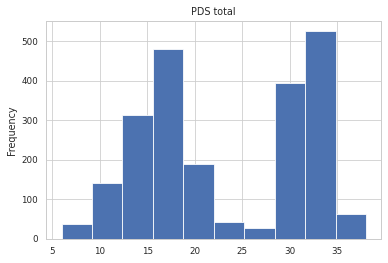

In [268]:
df_raw = df_raw.filter(regex='^a')
# correcting recode values a12a_f: 0 = 1, 1 = 4 @Milena what about a12b_f
# --> a12b_f is an age variable (and is not consodered in sum score computation), no need to recode 
df_raw.loc[:,'a12a_f'] = df_raw['a12a_f'].map({0:1,1:4})
# filling NaNs with 0 @Milena
df_raw = df_raw.fillna(0)
df_out = df_raw.sum(axis=1)
df_out.plot.hist(title='PDS total')
plt.show() #@Milena looks bimodal - might the total be different for differnt sex? Ex: Females have higher scores?
# --> yes, that's the most likely explanation as e.g. females start puberty earlier on average

In [269]:
# prepare the all_PDS.csv
df_out.name = 'PDS Sum'
df_out = df_out.to_frame()
df_out['Session']=tp
df_out

PDS Sum Session
ID                       
1274         16.0      BL
22453        14.0      BL
75717        18.0      BL
106601       15.0      BL
106871       31.0      BL
...           ...     ...
99873252     31.0      BL
99875982     32.0      BL
99888850     12.0      BL
99930021     34.0      BL
99954902     18.0      BL

[2208 rows x 2 columns]

In [270]:
# save as all_PDS.csv
df_out.to_csv(CONF_DATA_DIR + "all_PDS.csv")

##### all_ESPAD
* 31 /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
* 34 /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
* 47 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv

In [549]:
df_raw, tp, quest, formula = get_col_raw_df(31)
quest, formula

('/BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv',
 "sum score 'bully': bully05 + bully06 + bully07 + bully08 + bully11 + bully12; sum score 'victim': bully01 + bully02 + bully03 + bully04 + bully09 + bully10")

In [550]:
_, tp2, quest2, formula2 = get_col_raw_df(34)
assert tp==tp2 and quest==quest2
formula2

"use item 6 as measure for smoking: 'On how many occasions during your lifetime have you smoked cigarettes?'"

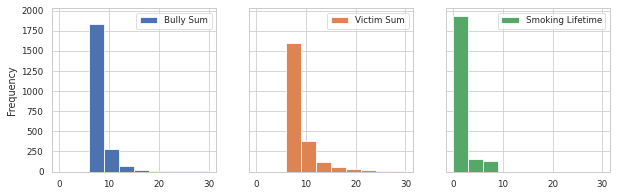

In [551]:
bully_cols = 'bully05 + bully06 + bully07 + bully08 + bully11 + bully12'.split(' + ')
victim_cols = 'bully01 + bully02 + bully03 + bully04 + bully09 + bully10'.split(' + ')

df_out = df_raw[bully_cols].sum(1)
df_out.name = 'Bully Sum'
df_out = df_out.to_frame()
df_out['Victim Sum'] = df_raw[victim_cols].sum(1)
df_out['Smoking Lifetime'] = df_raw['6']

df_out.plot.hist(subplots=True, sharey=True, layout=(1,3), figsize=(10,3))
plt.show() # @Milena 
# --> makes sense, as lowest score per bully item is 1

In [552]:
df_out['Session'] = tp
df_out

Bully Sum  Victim Sum  Smoking Lifetime Session
ID                                                       
1274              6          11                 0      BL
22453             7          10                 6      BL
75717             8           8                 6      BL
106601            6           8                 0      BL
106871            6           8                 0      BL
...             ...         ...               ...     ...
99873252          6           6                 2      BL
99875982          8           9                 0      BL
99888850          6           6                 0      BL
99930021          6           6                 0      BL
99954902          6           8                 0      BL

[2217 rows x 4 columns]

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  


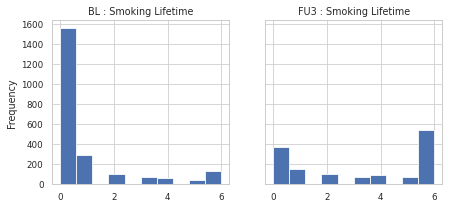

In [553]:
# add the FU3 smoking data
df_raw, tp, quest, formula = get_col_raw_df(47)
df_out2 = df_raw['6']
df_out2.name = 'Smoking Lifetime'
df_out2 = df_out2.to_frame()
df_out2['Session'] = tp
# print(len(df_out2))
df_out = df_out.append(df_out2)
# how did smoking behavior change from BL to FU3?
f, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(7,3))
for i, (session,g) in enumerate(df_out.groupby('Session')):
    g['Smoking Lifetime'].plot.hist(title=session+' : Smoking Lifetime', ax=axes[i])
plt.show()

In [554]:
df_out.to_csv(CONF_DATA_DIR+"all_ESPAD.csv")

##### all_ESPAD_Alc
* 49 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 50 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 51 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 52 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 53 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv

In [354]:
#read the raw data
formulas=[]
for i, loc in enumerate([49,50,51,52,53]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


49 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq03, dmq05, dmq11, dmq14, dmq16
50 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq01, dmq04, dmq06, dmq15, dmq17
51 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq07, dmq09, dmq10, dmq13, dmq18
52 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq02, dmq08, dmq12, dmq19, dmq20
53 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = rapi01 + rapi02 + rapi03 + rapi04 + rapi05 + rapi06 + rapi07
+ rapi08 + rapi09 + rapi10 + rapi11 + rapi12 + rapi13 + rapi14 + rapi15 + rapi16 + rapi17 + rapi18 + rapi19 + rapi20 + rapi21 + rapi22 + rapi23


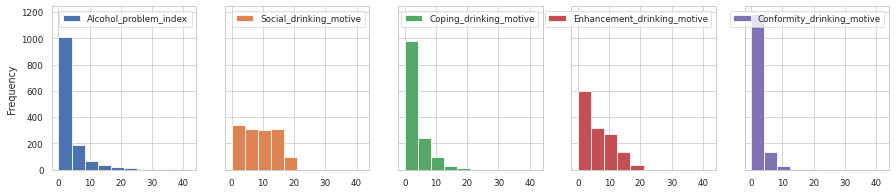

In [355]:
# prepare Alcohol_problem_index first
df_raw_rapi = df_raw["rapi01 + rapi02 + rapi03 + rapi04 + rapi05 + rapi06 + \
rapi07 + rapi08 + rapi09 + rapi10 + rapi11 + rapi12 + rapi13 + rapi14 + \
rapi15 + rapi16 + rapi17 + rapi18 + rapi19 + rapi20 + rapi21 + rapi22 + rapi23".split(' + ')]
df_raw_rapi = df_raw_rapi.fillna(0) #@Milena --> correct
df_out = df_raw_rapi.sum(1)
df_out.name = 'Alcohol_problem_index'
df_out = df_out.to_frame()

# now the remaining 4
other_cols = [
("Social_drinking_motive", 'dmq03, dmq05, dmq11, dmq14, dmq16'.split(', ')),
("Coping_drinking_motive", 'dmq01, dmq04, dmq06, dmq15, dmq17'.split(', ')),
("Enhancement_drinking_motive", 'dmq07, dmq09, dmq10, dmq13, dmq18'.split(', ')),
("Conformity_drinking_motive", 'dmq02, dmq08, dmq12, dmq19, dmq20'.split(', ')), 
]

for colname, cols in other_cols:
    df_raw_i = df_raw[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct
    df_out[colname] = df_raw_i.sum(1)
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,5), figsize=(15,3))
plt.show() # @Milena --> very skewed distributions, but makes sense as participants indicate mostly low alcohol problems (RAPI)
# and we see a plausible difference btw drinking motives (mostly social and enhancement, less coping and conformity, which might also be a social desirability effect)

In [356]:
df_out['Session'] = tp
df_out

Alcohol_problem_index  Social_drinking_motive  \
ID                                                        
112288                      3.0                     6.0   
215284                      1.0                     6.0   
240546                      1.0                    10.0   
297685                      4.0                     5.0   
308867                      0.0                    11.0   
...                         ...                     ...   
99677574                    0.0                     0.0   
99873252                    6.0                     9.0   
99875982                    3.0                     1.0   
99930021                    0.0                     0.0   
99954902                    4.0                     6.0   

          Coping_drinking_motive  Enhancement_drinking_motive  \
ID                                                              
112288                       0.0                          8.0   
215284                       1.0                          0.0   
240546                       1.0                          7.0   
297685                       1.0                          3.0   
308867                       1.0                          1.0   
...                          ...                          ...   
99677574                     0.0                          0.0   
99873252                     2.0                          7.0   
99875982                     0.0                          0.0   
99930021                     0.0                          0.0   
99954902                     1.0                          4.0   

          Conformity_drinking_motive Session  
ID                                            
112288                           0.0     FU3  
215284                           0.0     FU3  
240546                           1.0     FU3  
297685                           1.0     FU3  
308867                           0.0     FU3  
...                              ...     ...  
99677574                         0.0     FU3  
99873252                         0.0     FU3  
99875982                         0.0     FU3  
99930021                         0.0     FU3  
99954902                         2.0     FU3  

[1351 rows x 6 columns]

In [357]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_ESPAD_Alc.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_ESPAD_Alc.csv')

##### all_Eating
* 58 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 59 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 60 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 61 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 62 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
* 63 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
* 64 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv

In [400]:
#read the raw data of EDEQ first
formulas=[]
for i, loc in enumerate([58,59,60,61]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

58 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_1, EDEQ_2, EDEQ_3, EDEQ_4, EDEQ_5)/5
59 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_7, EDEQ_9, EDEQ_19, EDEQ_21, EDEQ_20)/5
60 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_6, EDEQ_8, EDEQ_23, EDEQ_10,
EDEQ_26, EDEQ_27, EDEQ_28, EDEQ_11)/8
61 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_22, EDEQ_24, EDEQ_8, EDEQ_25, EDEQ_12)/5


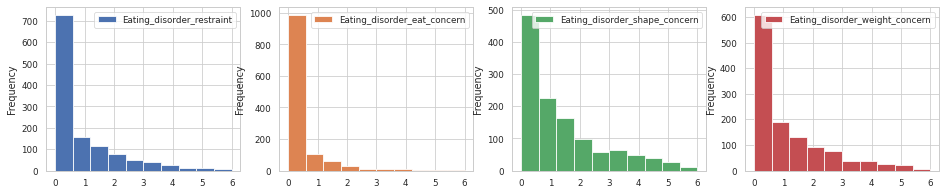

In [401]:
# prepare Eating_disorder_restraint first
df_raw_i = df_raw["EDEQ_1, EDEQ_2, EDEQ_3, EDEQ_4, EDEQ_5".split(', ')]
df_out = df_raw_i.mean(1)
df_out.name = 'Eating_disorder_restraint'
df_out = df_out.to_frame()
df_out

# now the remaining 3
other_cols = [
("Eating_disorder_eat_concern", 'EDEQ_7, EDEQ_9, EDEQ_19, EDEQ_21, EDEQ_20'.split(', ')),
("Eating_disorder_shape_concern", 'EDEQ_6, EDEQ_8, EDEQ_23, EDEQ_10, EDEQ_26, EDEQ_27, EDEQ_28, EDEQ_11'.split(', ')),
("Eating_disorder_weight_concern", 'EDEQ_22, EDEQ_24, EDEQ_8, EDEQ_25, EDEQ_12'.split(', '))
]

for colname, cols in other_cols:
    df_raw_i = df_raw[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct
    df_out[colname] = df_raw_i.mean(1)
    
df_out.plot.hist(subplots=True,  layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+4,3))
plt.show() # @Milena --> plausible, as many people don't experience eating disorder related symptoms

In [402]:
#read the raw data of TFEQ first
formulas2=[]
for i, loc in enumerate([62,63,64]):
    df_raw2, tp, quest2, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old2==quest2
    formulas2.append(formula)
    tp_old=tp
    quest_old2=quest2
    print(loc, quest2, formula)

62 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_2, TFEQ_11, TFEQ_12, TFEQ_15,
TFEQ_16,TFEQ_18) - 6] / 24 * 100
63 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_1, TFEQ_4, TFEQ_5, TFEQ_7,
TFEQ_8, TFEQ_9, TFEQ_13, TFEQ_14, TFEQ_17) - 9] / 36 * 100
64 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_3, TFEQ_6, TFEQ_10) - 3] / 12 * 100


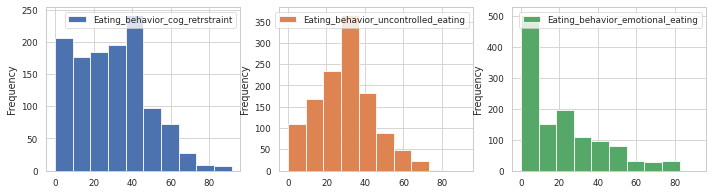

In [410]:
other_cols2 = [
("Eating_behavior_cog_retrstraint", 'TFEQ_2, TFEQ_11, TFEQ_12, TFEQ_15, TFEQ_16, TFEQ_18'.split(', ')),
("Eating_behavior_uncontrolled_eating", 'TFEQ_1, TFEQ_4, TFEQ_5, TFEQ_7, TFEQ_8, TFEQ_9, TFEQ_13, TFEQ_14, TFEQ_17'.split(', ')),
("Eating_behavior_emotional_eating", 'TFEQ_3, TFEQ_6, TFEQ_10'.split(', '))
]

for colname, cols in other_cols2:
    df_raw_i = df_raw2[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct; item 18 has to be recoded (from a scale of 8 to a scale of 4), I inserted the code below, is that correct?
    df_raw_i.loc[:,'TFEQ_18'] = df_raw_i['TFEQ_18'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:4,8:4})
    
    df_out[colname] = 100*(df_raw_i.sum(1)-len(cols))/(4*len(cols))
    
df_out[list(list(zip(*other_cols2))[0])].plot.hist(subplots=True, layout=(1,len(other_cols2)+1), figsize=(4*len(other_cols)+4,3))
plt.show() # @Milena --> plausible, as transformed to a scale from 0 - 100

In [411]:
df_out['Session'] = tp
df_out

Eating_disorder_restraint  Eating_disorder_eat_concern  \
ID                                                                 
112288                          0.0                          0.0   
215284                          1.6                          1.0   
240546                          0.4                          0.0   
297685                          1.8                          0.2   
308867                          0.0                          0.0   
...                             ...                          ...   
99616225                        2.8                          0.4   
99677574                        0.0                          0.0   
99873252                        1.6                          0.0   
99875982                        0.0                          0.0   
99954902                        0.0                          0.0   

          Eating_disorder_shape_concern  Eating_disorder_weight_concern  \
ID                                                                        
112288                            0.000                             0.8   
215284                            5.125                             4.0   
240546                            1.375                             0.8   
297685                            1.625                             0.4   
308867                            0.125                             0.2   
...                                 ...                             ...   
99616225                          3.625                             3.4   
99677574                          0.250                             0.0   
99873252                          1.500                             1.8   
99875982                          1.250                             1.0   
99954902                          0.625                             1.2   

          Eating_behavior_cog_retrstraint  \
ID                                          
112288                           0.000000   
215284                          50.000000   
240546                          37.500000   
297685                          29.166667   
308867                          41.666667   
...                                   ...   
99616225                        54.166667   
99677574                        12.500000   
99873252                        29.166667   
99875982                         8.333333   
99954902                        41.666667   

          Eating_behavior_uncontrolled_eating  \
ID                                              
112288                              55.555556   
215284                              27.777778   
240546                              36.111111   
297685                              30.555556   
308867                               8.333333   
...                                       ...   
99616225                             2.777778   
99677574                            22.222222   
99873252                            16.666667   
99875982                            11.111111   
99954902                            16.666667   

          Eating_behavior_emotional_eating Session  
ID                                                  
112288                            0.000000     FU3  
215284                           58.333333     FU3  
240546                           50.000000     FU3  
297685                           50.000000     FU3  
308867                            0.000000     FU3  
...                                    ...     ...  
99616225                          0.000000     FU3  
99677574                          8.333333     FU3  
99873252                          8.333333     FU3  
99875982                         16.666667     FU3  
99954902                          0.000000     FU3  

[1216 rows x 8 columns]

In [412]:
df_out.to_csv(CONF_DATA_DIR+'all_Eating.csv')

##### all_QOL
* 85 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 86 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 87 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 88 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv

In [416]:
#read the raw data
formulas=[]
for i, loc in enumerate([85,86,87,88]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

85 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_1
86 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_2
87 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_3
88 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_4


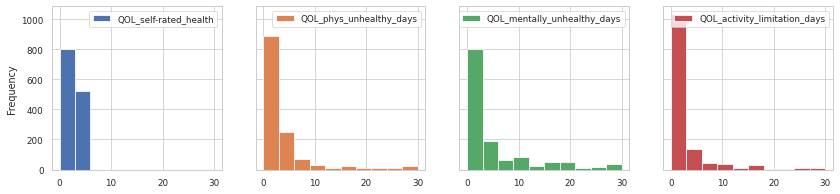

In [423]:
# prepare QOL_self-rated_health first
df_raw_i = df_raw["HRQOL_HDCM_1"]
df_raw_i.name = 'QOL_self-rated_health'
df_out = df_raw_i.to_frame()

# now the remaining 4
other_cols = [
("QOL_phys_unhealthy_days", 'HRQOL_HDCM_2'),
("QOL_mentally_unhealthy_days", 'HRQOL_HDCM_3'),
("QOL_activity_limitation_days", 'HRQOL_HDCM_4'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> the last three plots are plausible, as they refer to a max of 30 days per month. 
# The first variable is, however, measured on a scale from 1 (excellent health) to 5 (poor health). So the x-axis 
# limits should be chosen differently for the plot. But the values range itself looks plausible.

In [424]:
df_out['Session'] = tp
df_out

QOL_self-rated_health  QOL_phys_unhealthy_days  \
ID                                                         
112288                        1                        0   
215284                        5                       25   
240546                        1                        0   
297685                        2                        3   
308867                        2                        0   
...                         ...                      ...   
99677574                      2                        2   
99873252                      2                        1   
99875982                      2                        0   
99930021                      3                       15   
99954902                      2                       10   

          QOL_mentally_unhealthy_days  QOL_activity_limitation_days Session  
ID                                                                           
112288                              0                             0     FU3  
215284                              7                             4     FU3  
240546                              0                             0     FU3  
297685                              2                             2     FU3  
308867                              0                             0     FU3  
...                               ...                           ...     ...  
99677574                            0                             2     FU3  
99873252                            1                             0     FU3  
99875982                            0                             0     FU3  
99930021                            2                             8     FU3  
99954902                            6                             0     FU3  

[1324 rows x 5 columns]

In [425]:
df_out.to_csv(CONF_DATA_DIR+'all_QOL.csv')

##### all_CTS
* 111 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 112 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 113 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 114 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 115 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv

In [37]:
#read the raw data
formulas=[]
for i, loc in enumerate([111,112,113,114,115]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    print(loc, quest, formula)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest


111 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_assault
112 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_injury
113 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_negotiation
114 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_psychological_aggression
115 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_secual_coercion


In [38]:
df_raw_i = df_raw["cts_assault"]
df_raw_i.name = 'Parent Assault Mean'
df_out = df_raw_i.to_frame()
# df_out.info()

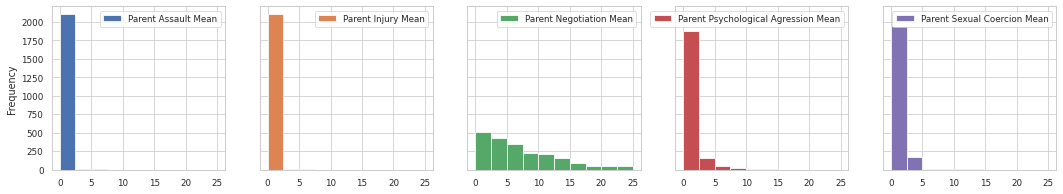

In [39]:
# now the remaining 4
other_cols = [
('Parent Injury Mean', 'cts_injury'),
('Parent Negotiation Mean', 'cts_negotiation'),
('Parent Psychological Agression Mean', 'cts_psychological_aggression'),
('Parent Sexual Coercion Mean', 'cts_sexual_coercion'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    
df_out.plot.hist(subplots=True, sharey=True, sharex=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> plausible, as values represent means on a scale from 0 - 25 and certain types of behavior are very rare

In [40]:
df_out['Session'] = tp
df_out

Parent Assault Mean  Parent Injury Mean  Parent Negotiation Mean  \
ID                                                                           
1274                      0.0                 0.0                 4.500000   
22453                     0.0                 0.0                22.166667   
75717                     0.6                 0.0                 9.416667   
106601                    0.0                 0.0                 0.583333   
106871                    0.0                 0.0                 1.500000   
...                       ...                 ...                      ...   
99873252                  0.0                 0.0                 8.333333   
99875982                  0.0                 0.0                 4.916667   
99888850                  0.0                 0.0                 1.500000   
99930021                  0.0                 0.0                 3.833333   
99954902                  0.0                 0.0                10.583333   

          Parent Psychological Agression Mean  Parent Sexual Coercion Mean  \
ID                                                                           
1274                                    0.875                     0.000000   
22453                                   3.625                     4.166667   
75717                                  10.000                     0.000000   
106601                                  0.125                     0.000000   
106871                                  0.500                     0.000000   
...                                       ...                          ...   
99873252                                0.250                     0.000000   
99875982                                0.250                     0.000000   
99888850                                0.000                     0.000000   
99930021                                0.250                     0.000000   
99954902                                0.625                     2.083333   

         Session  
ID                
1274          BL  
22453         BL  
75717         BL  
106601        BL  
106871        BL  
...          ...  
99873252      BL  
99875982      BL  
99888850      BL  
99930021      BL  
99954902      BL  

[2114 rows x 6 columns]

In [54]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_CTS.csv')
df_old = df_old.drop(columns= [c for c in list(df_out.columns)+['Parent Psychological Agreesion Mean'] if c in df_old.columns and c not in ['ID','Session']])
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_CTS.csv')

##### all_GEN
* 117 BL /BL/psytools/IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv

In [453]:
#read the raw data
formulas=[]
for i, loc in enumerate([117]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

117 /BL/psytools/IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv Psych_History (recode yes = 1, no = 0)


In [454]:
df_raw_i = df_raw["Psych_History"].map({'YES':1, 'NO':0, 'DK':np.nan, 'RF':np.nan}) #@Milena is it ok that I can map DK and RF as nans? --> yes, good point!
df_raw_i.name = 'Parent Psychiatric Disorders History'
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.value_counts(dropna=False)

Parent Psychiatric Disorders History  Session
1.0                                   BL         1104
0.0                                   BL         1032
NaN                                   BL           55
dtype: int64

In [455]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_GEN.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_GEN.csv')

## Analysis 0: prepare missing covariates (iter 2)
Check which covariates are still pending preprocessing

In [275]:
df_confs = pd.read_excel("Confounds_list_Milena_v2.xlsx")
df_confs = df_confs.loc[df_confs['questionnaire'].str.contains('\?\?\?') | df_confs['colname'].str.contains('\?\?\?')]
print("Rows that need to be preprocessed n =", len(df_confs))
# df_confs.dropna(subset=['raw questionnaire'])[['time_point','raw questionnaire', 'score computation']]

# check if all of them exist and have valid subject ID columns 
for i, row in df_confs.iterrows():
    print(i, row['time_point'], row['raw questionnaire'])
    try:
        df_raw, tp, quest, formula = get_col_raw_df(i, df_confs)
        # print(row['score computation'])
        # display(df_raw)
    except Exception as E:
        print(f'[ERROR {E.__class__.__name__}]', E)

Rows that need to be preprocessed n = 19
33 BL /BL/dawba/IMAGEN_dawba_BL.tsv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


34 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
49 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv
55 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv
56 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv
57 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv
58 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv
69 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv
72 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv
85 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv
108 FU3 /FU3/dawba/IMAGEN_dawba_FU3.tsv
109 FU3 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv
111 BL /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv
118 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
119 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
120 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
121 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
122 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
123 BL /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv


##### all_SDQ
* 33 BL /BL/dawba/IMAGEN_dawba_BL.tsv
* 108 FU3 /FU3/dawba/IMAGEN_dawba_FU3.tsv

In [336]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(33, df_confs)
print(quest, formula)
# df_raw

/BL/dawba/IMAGEN_dawba_BL.tsv recode items sobeys, sreflect, sattends, sfriend, spopular: 0 = 2, 1 = 1, 2 = 0; sum score = sconsid +  srestles + ssomatic + sshares + stantrum + sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [337]:
df_raw_i = df_raw["sebdtot"]
df_raw_i.name = 'Social_difficulties'
df_out = df_raw_i.to_frame()

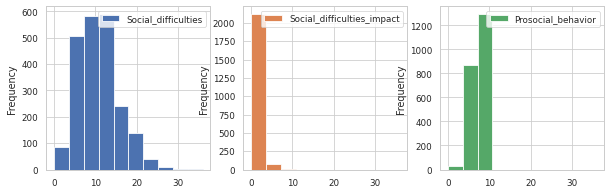

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 1274 to 99954902
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Social_difficulties         2195 non-null   float64
 1   Social_difficulties_impact  2195 non-null   float64
 2   Prosocial_behavior          2195 non-null   float64
 3   Session                     2223 non-null   object 
dtypes: float64(3), object(1)
memory usage: 86.8+ KB


In [338]:
other_cols = [
('Social_difficulties_impact', 'simpact'),
('Prosocial_behavior', 'sprosoc')
]
for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
# @milena --> I adapted score calculation as I saw that the necessary variables are already included in the raw data file. Can you check if correct?
df_out.plot.hist(subplots=True, sharey=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

df_out['Session'] = tp 
df_out.info() 

In [339]:
#read the raw data
df_raw2, tp, quest, formula = get_col_raw_df(108, df_confs)
print(quest, formula)
# df_raw2.columns

/FU3/dawba/IMAGEN_dawba_FU3.tsv recode items sobeys, sreflect, sattends, sfriend, spopular: 0 = 2, 1 = 1, 2 = 0; sum score = sconsid +  srestles + ssomatic + sshares + stantrum + sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact


In [340]:
df_raw2 = df_raw2.reset_index().rename(columns={'level_0':'ID', 'level_1':'index'}).set_index('ID')

In [341]:
df_raw_i = df_raw2["sebdtot"]
df_raw_i.name = 'Social_difficulties'
df_out2 = df_raw_i.to_frame()
df_out2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 112288 to 99954902
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Social_difficulties  1312 non-null   float64
dtypes: float64(1)
memory usage: 20.5 KB


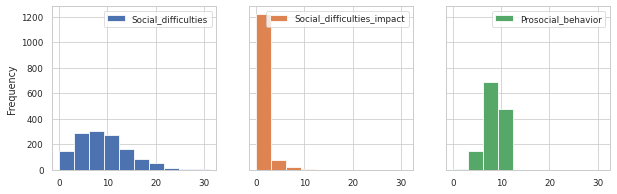

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 112288 to 99954902
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Social_difficulties         1312 non-null   float64
 1   Social_difficulties_impact  1312 non-null   float64
 2   Prosocial_behavior          1312 non-null   float64
 3   Session                     1315 non-null   object 
dtypes: float64(3), object(1)
memory usage: 51.4+ KB


In [342]:
other_cols = [
('Social_difficulties_impact', 'simpact'),
('Prosocial_behavior', 'sprosoc')
]

for colname, cols in other_cols:
    df_out2[colname] = df_raw2[cols]
df_out2['Session'] = tp 

df_out2.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

df_out2.info()

In [343]:
df_out = df_out.append(df_out2)

In [344]:
df_out.to_csv(CONF_DATA_DIR+'all_SDQ.csv')

##### all_TLFB
* 34 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
* 49 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv

In [570]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(34)
print(loc, quest, formula)

49 /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv following items indicate number of days usage per substance in past 30 days: tlfb_alcohol1, tlfb_tobacco1, tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1; take alcohol and tobacco scores as separate variables each; add up remaining items to a drug use variable


In [579]:
# display(df_raw)
df_raw_i = df_raw["tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, \
tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, \
tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1".split(', ')].sum(1)
df_raw_i.name = 'Drugs Last Month'
df_out = df_raw_i.apply(lambda x:x if x>=0 else np.nan).to_frame() # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
df_out['Session'] = tp
# df_out.info()

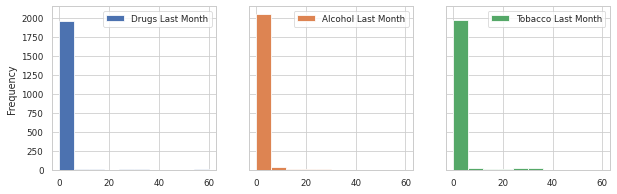

In [580]:
# now the remaining 4
other_cols = [
('Alcohol Last Month', 'tlfb_alcohol1'),
('Tobacco Last Month', 'tlfb_tobacco1'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols].apply(lambda x:x if x>=0 else np.nan) # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

In [583]:
df_raw2, tp, quest, formula = get_col_raw_df(49)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv following items indicate number of days usage per substance in past 30 days: tlfb_alcohol1, tlfb_tobacco1, tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1; take alcohol and tobacco scores as separate variables each; add up remaining items to a drug use variable


In [585]:
# display(df_raw)
df_raw2_i = df_raw2["tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, \
tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, \
tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1".split(', ')].sum(1)
df_raw2_i.name = 'Drugs Last Month'
df_out2 = df_raw2_i.apply(lambda x:x if x>=0 else np.nan).to_frame() # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
df_out2['Session'] = tp
# df_out2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 215284 to 99954902
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Drugs Last Month  1177 non-null   float64
 1   Session           1177 non-null   object 
dtypes: float64(1), object(1)
memory usage: 27.6+ KB


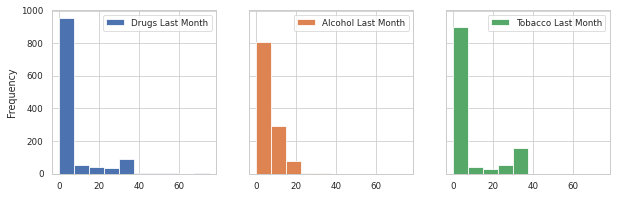

In [586]:
# now the remaining 4
other_cols = [
('Alcohol Last Month', 'tlfb_alcohol1'),
('Tobacco Last Month', 'tlfb_tobacco1'),
]

for colname, cols in other_cols:
    df_out2[colname] = df_raw2[cols].apply(lambda x:x if x>=0 else np.nan) # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
    
df_out2.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

In [591]:
df_out = df_out.append(df_out2)
df_out.to_csv(CONF_DATA_DIR+'all_TLFB.csv')

##### all_CSI
55 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv

In [592]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(55)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv csi_sum


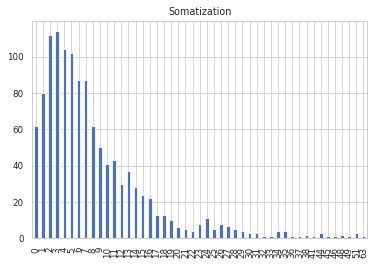

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Somatization  1217 non-null   int64 
 1   Session       1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [594]:
df_raw_i = df_raw['csi_sum']
df_raw_i.name = 'Somatization'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena binarizing at median? --> lets try median first for consistency
df_out['Session'] = tp
df_out.info() 

In [595]:
df_out.to_csv(CONF_DATA_DIR+'all_CSI.csv')

##### all_IRI
56 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv

In [31]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(56, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv sum score = IRI_fantasy + IRI_perspective + IRI_empathic + IRI_personal


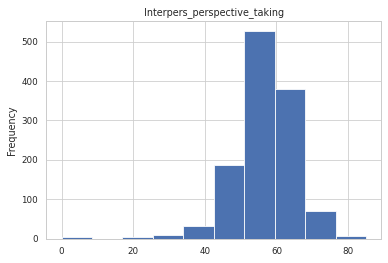

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Interpers_perspective_taking  1217 non-null   int64 
 1   Session                       1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [32]:
df_raw_i = df_raw['IRI_fantasy + IRI_perspective + IRI_empathic + IRI_personal'.split(' + ')].sum(1)
df_raw_i.name = 'Interpers_perspective_taking'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena there are some outliers near 0 --> I would leave them in and try, as it's not unplausible that some people have very low scores.
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [33]:
df_out.to_csv(CONF_DATA_DIR+'all_IRI.csv')

##### all_RRS
57 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv

In [25]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(57, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv sum score = sum(RRS_1, RRS_2, RRS_3, RRS_4, RRS_5, RRS_6, RRS_7,
RRS_8, RRS_9, RRS_10, RRS_11, RRS_12, RRS_13, RRS_14, RRS_15, RRS_16, RRS_17,
RRS_18, RRS_19, RRS_20, RRS_21, RRS_22


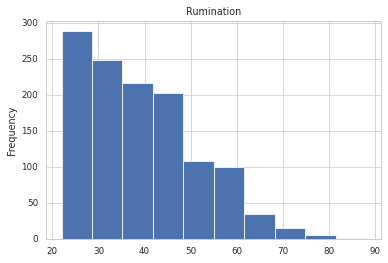

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rumination  1217 non-null   int64 
 1   Session     1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [26]:
df_raw_i = df_raw['RRS_1, RRS_2, RRS_3, RRS_4, RRS_5, RRS_6, RRS_7, \
RRS_8, RRS_9, RRS_10, RRS_11, RRS_12, RRS_13, RRS_14, RRS_15, RRS_16, RRS_17, \
RRS_18, RRS_19, RRS_20, RRS_21, RRS_22'.split(', ')].sum(1)
df_raw_i.name = 'Rumination'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena binary threshold median may not make sense?! --> I think it's the same as with all skewed distributions. Would stick with the median for consistency. 
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [27]:
df_out.to_csv(CONF_DATA_DIR+'all_RRS.csv')

##### all_VGS
58 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv

In [605]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(58, df_confs)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv only consider item VideoGame_2_1d: In the PAST 12 MONTHS On how many days per
week did you play?


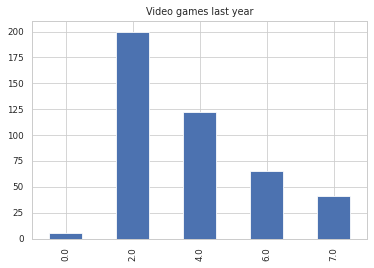

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Video games last year  433 non-null    float64
 1   Session                1214 non-null   object 
dtypes: float64(1), object(1)
memory usage: 28.5+ KB


In [608]:
df_raw_i = df_raw['VideoGame_2_1d']
df_raw_i.name = 'Video games last year'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena does the binary threshold median makes sense?! --> it would only make sense if values <= 2 are 0 and > 2 are 1.
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [609]:
df_out.to_csv(CONF_DATA_DIR+'all_VGS.csv')

##### all_Urbanicity
69 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv

In [187]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(69, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv weighted sum score = sum((URBANICITY_city*3), (URBANICITY_town*2),(URBANICITY_rural*1))


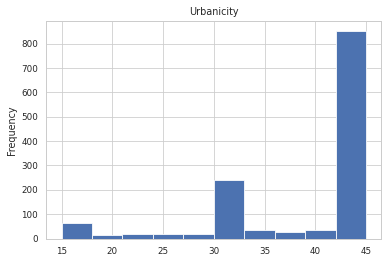

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1327 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Urbanicity  1327 non-null   float64
 1   Session     1327 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.1+ KB


In [191]:
df_raw_i = (df_raw['URBANICITY_city']*3 +  df_raw['URBANICITY_town']*2 +  df_raw['URBANICITY_rural']) 

df_raw_i.name = 'Urbanicity'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena does the binary threshold median makes sense?! --> there was a bug in sum score calculation, corrected it above :)
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [192]:
df_out.to_csv(CONF_DATA_DIR+'all_Urbanicity.csv')

##### all_WHO
72 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv

In [626]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(72, df_confs)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv transformed sum score = sum(WHO5_1 to WHO5_5) * 4


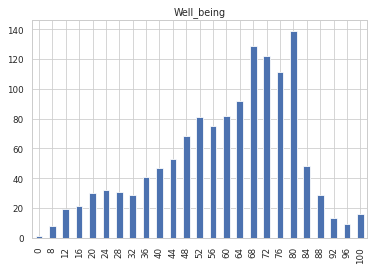

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Well_being  1326 non-null   int64 
 1   Session     1326 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.1+ KB


In [627]:
df_raw_i = df_raw.filter(regex='WHO').sum(1)*4 # @Milena is it x4 or x5? --> x4 is correct. This is done to bring it to a percentage scale (4 x max score of 25 is = 100).
df_raw_i.name = 'Well_being'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena should the binary threshold be greater than median or lower than median ? --> could again try the median first and then if it doesn't work well take the mean instead (which will be lower than median).
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [628]:
df_out.to_csv(CONF_DATA_DIR+'all_WHO.csv')

##### all_HF
85 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv

In [193]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(85, df_confs)
print(loc, quest, formula)
# df_raw.columns

122 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv sum score any physical condition = sum(HF_08 to HF_18)


In [195]:
# recode items
for col in ['HF_08', 'HF_09', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18']:
    df_raw[col] = df_raw[col].map({1:1,2:0,7: np.nan,9: np.nan})

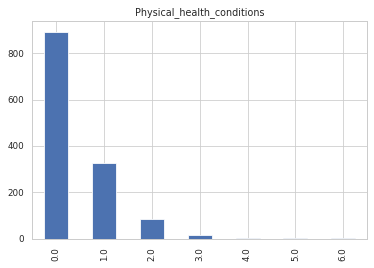

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Physical_health_conditions  1322 non-null   float64
 1   Session                     1322 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.0+ KB


In [196]:
df_raw_i = df_raw["'HF_08', 'HF_09', 'HF_10', 'HF_11', \
'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18'".replace("'","").split(", ")].sum(1)
df_raw_i.name = 'Physical_health_conditions'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena --> items have to be recoded so that 1 = 1, 2 = 0, 7 = NaN, 9 = NaN; inserted this in the cell above - can you check if correct?
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [197]:
df_out.to_csv(CONF_DATA_DIR+'all_HF.csv')

##### all_Par_ESPAD
111 https://matt.might.net/articles/phd-school-in-pictures/BL /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv

In [ ]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(111, df_confs)
print(loc, quest, formula)

111 /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv sum of all dast items as global measure for drug abuse


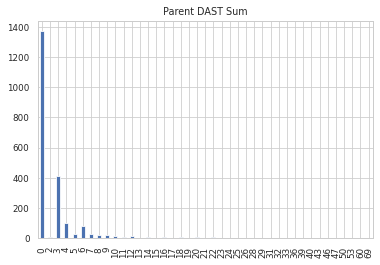

Parent DAST Sum Session
ID                               
1274                    0      BL
22453                   0      BL
75717                   0      BL
106601                  0      BL
106871                  0      BL
...                   ...     ...
99826568                0      BL
99873252                0      BL
99888850                0      BL
99930021                0      BL
99954902                3      BL

[2182 rows x 2 columns]

In [ ]:
df_raw_i = df_raw.filter(regex='dast_.*_sum').sum(1)
df_raw_i.name = 'Parent DAST Sum'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show()
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out

In [ ]:
df_out.to_csv(CONF_DATA_DIR+'all_Par_ESPADall_Par_ESPAD.csv')

##### all_PBQ
* 118 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 119 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 120 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 121 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 122 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv

In [171]:
#read the raw data
formulas=[]
for i, loc in enumerate([118,119,120,121,122]):
    df_raw, tp, quest, formula = get_col_raw_df(loc, df_confs)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

118 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv sum(pbq_05a, pbq_05b, pbq_05c)
119 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_06a
120 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_10
121 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_11
122 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_12


In [172]:
df_raw_i = df_raw["pbq_05a, pbq_05b, pbq_05c".split(', ')].sum(1)
df_raw_i.name = 'Parent cigerattes during pregnancy'
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
# df_out.info()

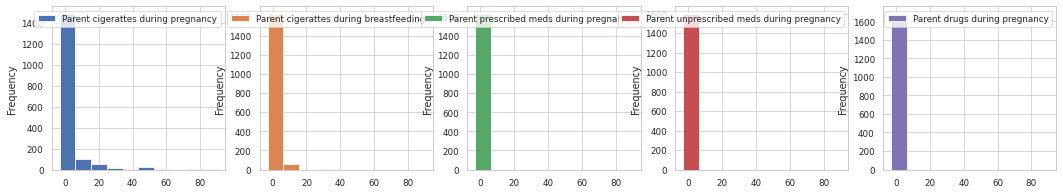

In [173]:
# now the remaining 4
other_cols = [
('Parent cigerattes during breastfeeding', 'pbq_06a'),
('Parent prescribed meds during pregnancy', 'pbq_10'),
('Parent unprescribed meds during pregnancy', 'pbq_11'),
('Parent drugs during pregnancy', 'pbq_12'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    if cols in ['pbq_10', 'pbq_11', 'pbq_12']: #@Milena for pbq_10, pbq_11 and pbq_12, negative values have to be coded as missing
        # display(df_out[colname].value_counts())
        df_out[colname] = df_out[colname].map({0:0, 1:1, -1:np.NaN,-2:np.NaN})
    else:   #@Milena missing as 0 --> correct; for all others
        df_out[colname] = df_out[colname].fillna(0)
        
df_out.plot.hist(subplots=True, sharey=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> low values are plausible

In [174]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 1274 to 99954902
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Parent cigerattes during pregnancy         1688 non-null   float64
 1   Session                                    1688 non-null   object 
 2   Parent cigerattes during breastfeeding     1688 non-null   float64
 3   Parent prescribed meds during pregnancy    1627 non-null   float64
 4   Parent unprescribed meds during pregnancy  1594 non-null   float64
 5   Parent drugs during pregnancy              1677 non-null   float64
dtypes: float64(5), object(1)
memory usage: 92.3+ KB


In [175]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_PBQ.csv').set_index(['ID','Session'])
df_out = df_out.reset_index().set_index(['ID','Session'])
df_old[df_out.columns] = df_out
df_old.reset_index().set_index('ID').to_csv(CONF_DATA_DIR+'all_PBQ.csv')

##### all_Par_AUDIT
123 BL /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv

In [509]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(123, df_confs)
print(loc, quest, formula)

111 /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv audit_total


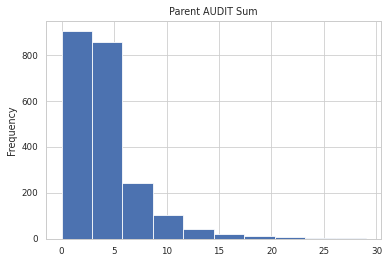

Parent AUDIT Sum Session
ID                                
1274                     3      BL
22453                    4      BL
75717                    2      BL
106601                   2      BL
106871                   2      BL
...                    ...     ...
99826568                 0      BL
99873252                 2      BL
99888850                 4      BL
99930021                 3      BL
99954902                 7      BL

[2182 rows x 2 columns]

In [510]:
df_raw_i = df_raw["audit_total"]
df_raw_i.name = 'Parent AUDIT Sum'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show()
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out

In [511]:
df_out.to_csv(CONF_DATA_DIR+'all_Par_AUDIT.csv')

##### all_ESPAD (bully)
109 FU3 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv

In [565]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(109, df_confs)
print(loc, quest, formula)

111 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv sum score 'bully': bully05 + bully06 + bully07 + bully08 + bully11 + bully12; sum score 'victim': bully01 + bully02 + bully03 + bully04 + bully09 + bully10


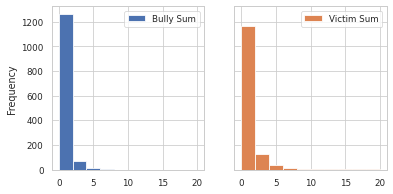

Bully Sum  Victim Sum Session
ID                                     
112288            0           0     FU3
215284            0           4     FU3
240546            0           2     FU3
297685            0           0     FU3
308867            0           0     FU3
...             ...         ...     ...
99677574          0           1     FU3
99873252          0           0     FU3
99875982          0           8     FU3
99930021          0           0     FU3
99954902          0           0     FU3

[1350 rows x 3 columns]

In [566]:
df_raw_i = df_raw["bully05 + bully06 + bully07 + bully08 + bully11 + bully12".split(' + ')].sum(1)
df_raw_i.name = 'Bully Sum'
df_out = df_raw_i.to_frame()

df_out['Victim Sum'] = df_raw["bully01 + bully02 + bully03 + bully04 + bully09 + bully10".split(' + ')].sum(1)

df_out['Session'] = tp

df_out.plot.hist(subplots=True, sharey=True, layout=(1,2), figsize=(4+2,3))
plt.show() # @Milena - is this the same as the 'all_ESPAD' file creation in analysis 0 iteration 1? And could you add 'df_out['Smoking Lifetime'] = df_raw['6']' for FU3 as well? (either here or in iteration 1?)

df_out

In [567]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_ESPAD.csv').set_index('ID')
# df_old.loc[:,["Bully Sum","Victim Sum"]] = df_out.reset_index().set_index(['ID','Session'])
df_old.loc[df_old['Session']==tp, ["Bully Sum","Victim Sum"]] = df_out[["Bully Sum","Victim Sum"]]
df_old.to_csv(CONF_DATA_DIR+'all_ESPAD.csv')

# Main Analysis
Prepare all H5files and run the MLpipelines on 3 h5files:

1) MRI BL 1 binge experience --> FU3 binge drinking with confounds from FU3 and BL
2) MRI BL 0 binge experience --> FU3 binge drinking with confounds from FU3 and BL
3) MRI BL --> FU3 binge drinking with confounds from FU3 and BL
4) MRI FU3 --> FU3 binge drinking with confounds from FU3

In [13]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.impute import KNNImputer

In [14]:
plot_dist = True
print_all = True
h5_name = 'h5causal1' # 'h5causal0' 'h5causal1', 'h5fu3', 'h5bl'
h5_src = H5_FILES[h5_name] 

### Load confounds and create h5files

In [14]:
# ! rm -rvf $H5_DIR/posthoc-cc2*$h5_name*
# ! rm -rvf $H5_DIR/../posthoc-cc2*$h5_name*

In [15]:
# ! rm -rf ../MLpipelines/results/posthoc-cc2-*$h5_name*

-------------------  (0) Alc-lastmnt   ----------------------
Using Q collected at session-BL
imputing 752/2217 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.60, 0.00, 6.00)


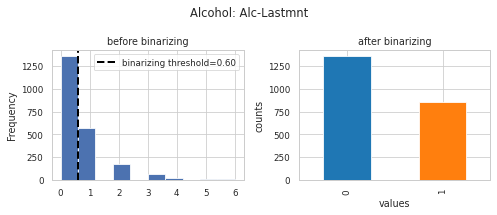

writing to .. posthoc-cc2-h5causal1-Alc-lastmnt.h5
attaching conf Alc-lastmnt
-------------------  (1) Alc-last12mnt   ----------------------
Using Q collected at session-BL
imputing 521/2217 missing values with 0.0
range (min, mean, median, max) = (0.00, 1.41, 1.00, 6.00)


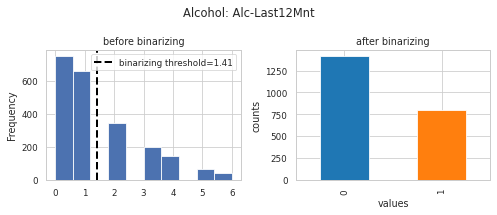

writing to .. posthoc-cc2-h5causal1-Alc-last12mnt.h5
attaching conf Alc-last12mnt
-------------------  (2) Neuroticism   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.33, 1.93, 1.92, 3.92)


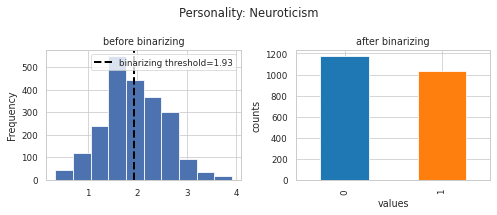

writing to .. posthoc-cc2-h5causal1-Neuroticism.h5
attaching conf Neuroticism
-------------------  (3) Extroversion   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.25, 2.50, 2.50, 3.92)


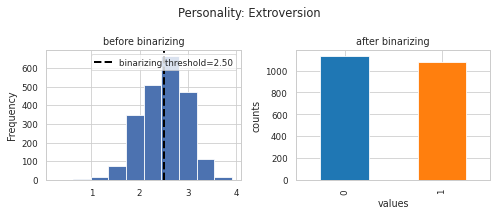

writing to .. posthoc-cc2-h5causal1-Extroversion.h5
attaching conf Extroversion
-------------------  (4) Conscientiousness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.50, 2.30, 2.33, 4.00)


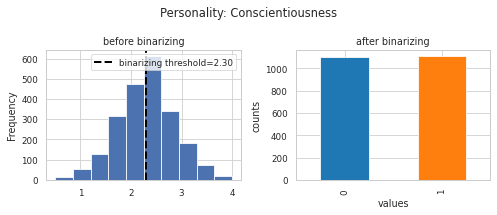

writing to .. posthoc-cc2-h5causal1-Conscientiousness.h5
attaching conf Conscientiousness
-------------------  (5) Openness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.83, 2.17, 2.17, 3.75)


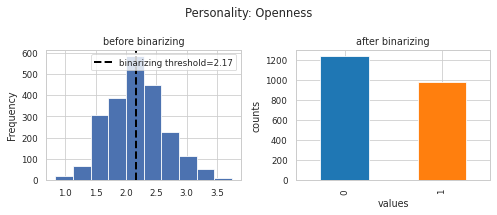

writing to .. posthoc-cc2-h5causal1-Openness.h5
attaching conf Openness
-------------------  (6) Agreeableness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.50, 2.40, 2.42, 3.67)


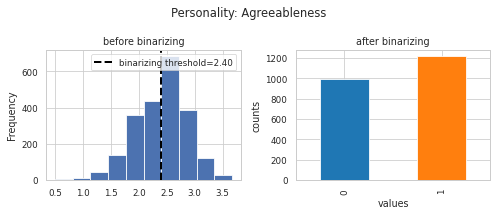

writing to .. posthoc-cc2-h5causal1-Agreeableness.h5
attaching conf Agreeableness
-------------------  (7) Family_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.26, 0.20, 1.00)


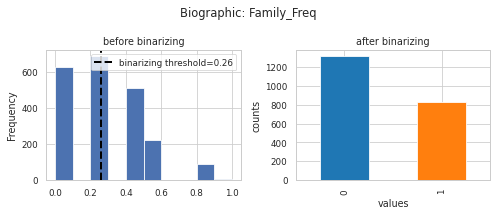

writing to .. posthoc-cc2-h5causal1-Family_freq.h5
attaching conf Family_freq
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (8) Family_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.10, -1.20, 1.60)


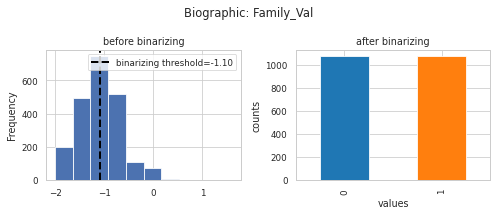

writing to .. posthoc-cc2-h5causal1-Family_val.h5
attaching conf Family_val
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (9) Accident_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.52, 0.50, 1.00)


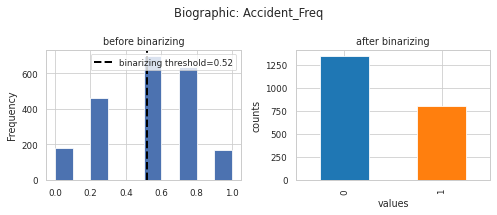

writing to .. posthoc-cc2-h5causal1-Accident_freq.h5
attaching conf Accident_freq
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (10) Accident_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.21, -1.25, 2.00)


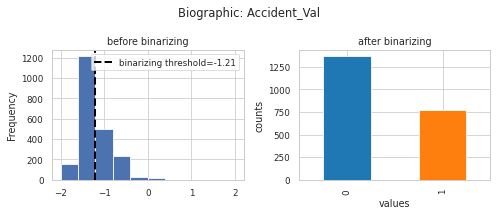

writing to .. posthoc-cc2-h5causal1-Accident_val.h5
attaching conf Accident_val
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (11) Sexuality_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.29, 0.29, 1.00)


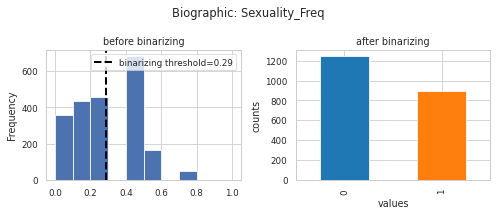

writing to .. posthoc-cc2-h5causal1-Sexuality_freq.h5
attaching conf Sexuality_freq
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (12) Sexuality_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.43, -0.04, 0.00, 1.71)


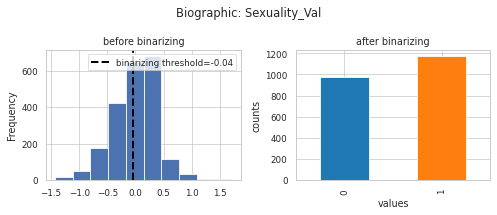

writing to .. posthoc-cc2-h5causal1-Sexuality_val.h5
attaching conf Sexuality_val
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (13) Autonomy_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.53, 0.50, 1.00)


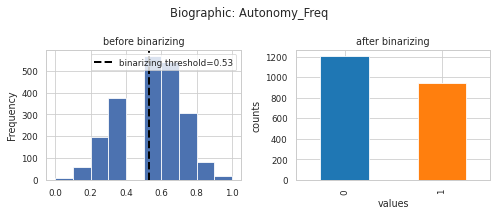

writing to .. posthoc-cc2-h5causal1-Autonomy_freq.h5
attaching conf Autonomy_freq
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (14) Autonomy_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.00, 1.00, 1.00, 2.00)


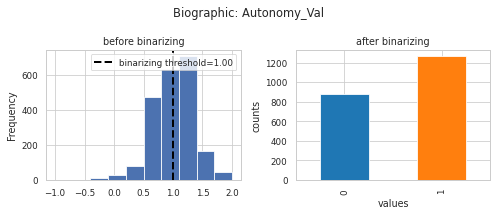

writing to .. posthoc-cc2-h5causal1-Autonomy_val.h5
attaching conf Autonomy_val
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (15) Deviance_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.27, 0.33, 1.00)


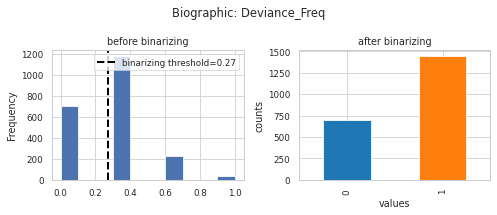

writing to .. posthoc-cc2-h5causal1-Deviance_freq.h5
attaching conf Deviance_freq
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (16) Deviance_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.00, -1.00, 2.00)


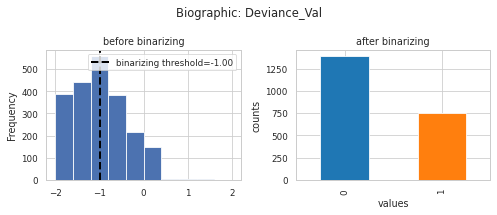

writing to .. posthoc-cc2-h5causal1-Deviance_val.h5
attaching conf Deviance_val
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (17) Relocation_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.44, 0.33, 1.00)


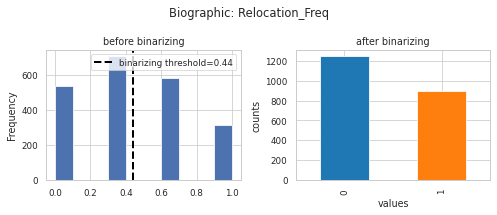

writing to .. posthoc-cc2-h5causal1-Relocation_freq.h5
attaching conf Relocation_freq
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (18) Relocation_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -0.38, -0.33, 2.00)


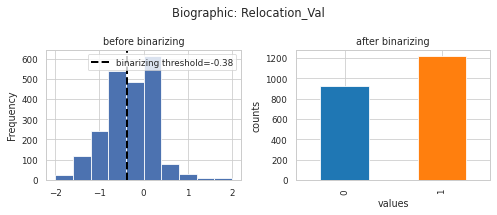

writing to .. posthoc-cc2-h5causal1-Relocation_val.h5
attaching conf Relocation_val
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (19) Distress_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.28, 0.33, 1.00)


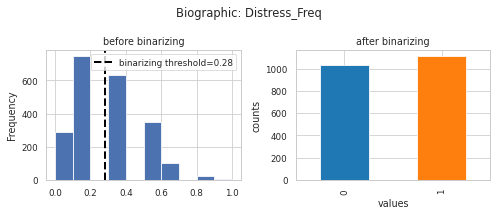

writing to .. posthoc-cc2-h5causal1-Distress_freq.h5
attaching conf Distress_freq
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (20) Distress_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, -1.10, -1.17, 2.00)


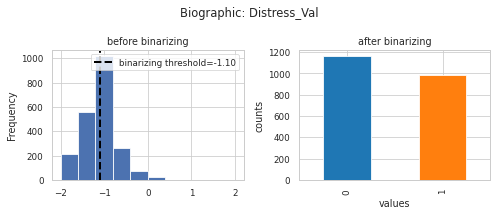

writing to .. posthoc-cc2-h5causal1-Distress_val.h5
attaching conf Distress_val
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (21) Total_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.03, 0.37, 0.36, 0.79)


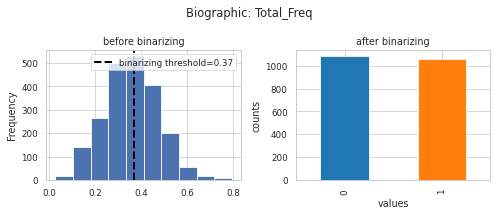

writing to .. posthoc-cc2-h5causal1-Total_freq.h5
attaching conf Total_freq
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (22) Total_val   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-1.10, -0.33, -0.33, 1.59)


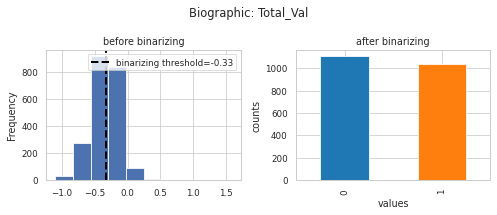

writing to .. posthoc-cc2-h5causal1-Total_val.h5
attaching conf Total_val
[WARN] n=6 subs missing this conf information. Dropping sample size from 565 to 559
-------------------  (23) Age_first_drunk   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (11.00, 15.42, 15.00, 21.00)


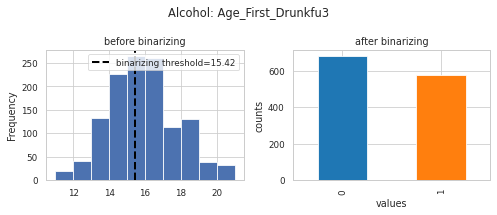

writing to .. posthoc-cc2-h5causal1-Age_first_drunkFU3.h5
attaching conf Age_first_drunkFU3
[WARN] n=59 subs missing this conf information. Dropping sample size from 565 to 506
-------------------  (24) Drug_abuse_lft   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.00, 0.00, 0.00)


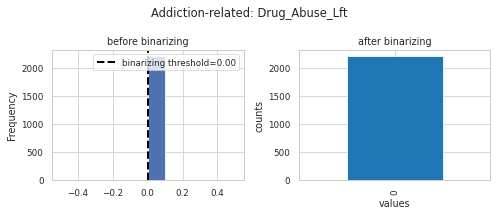

writing to .. posthoc-cc2-h5causal1-Drug_abuse_lft.h5
attaching conf Drug_abuse_lft
[ERROR] Failed to create h5: conf has n_classes= 1. If n_classes>2 then it was not correctly binarized. If n_classes=1 then all subjects are getting categorized into a single class.
-------------------  (25) Nicotine_dependence   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.08, 0.00, 10.00)


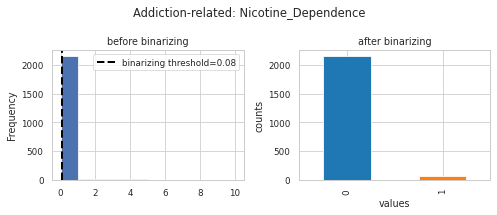

writing to .. posthoc-cc2-h5causal1-Nicotine_dependence.h5
attaching conf Nicotine_dependence
[ERROR] Failed to create h5: the value 1 in Nicotine_dependence has fewer than 15% instances (n=4)
This is very small for counter balancing to work properly..
-------------------  (26) Comp_sub_abuse_lft   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.03, 0.00, 1.00)


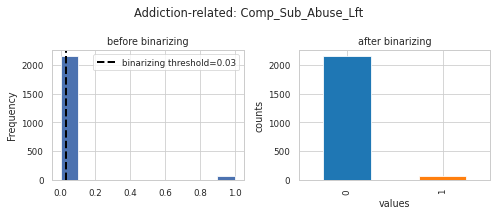

writing to .. posthoc-cc2-h5causal1-Comp_sub_abuse_lft.h5
attaching conf Comp_sub_abuse_lft
[ERROR] Failed to create h5: the value 1 in Comp_sub_abuse_lft has fewer than 15% instances (n=4)
This is very small for counter balancing to work properly..
-------------------  (27) Novelty_seeking   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (75.00, 111.47, 111.00, 152.00)


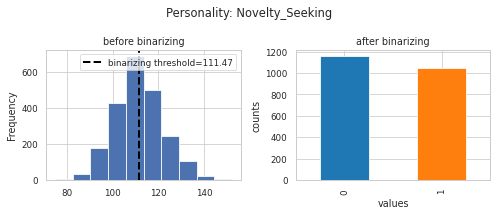

writing to .. posthoc-cc2-h5causal1-Novelty_seeking.h5
attaching conf Novelty_seeking
[WARN] n=3 subs missing this conf information. Dropping sample size from 565 to 562
-------------------  (28) Anxiety_sensitivity   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.26, 2.20, 4.00)


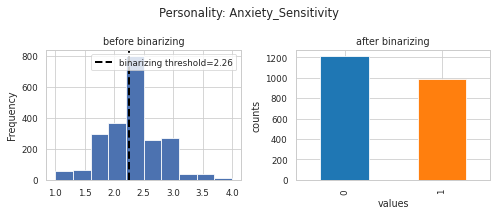

writing to .. posthoc-cc2-h5causal1-Anxiety_sensitivity.h5
attaching conf Anxiety_sensitivity
[WARN] n=1 subs missing this conf information. Dropping sample size from 565 to 564
-------------------  (29) Hopelessness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 1.87, 1.86, 4.00)


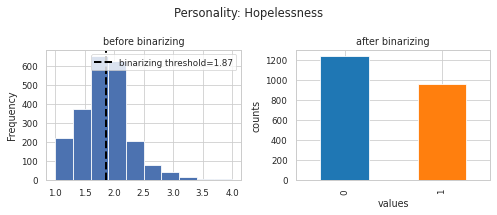

writing to .. posthoc-cc2-h5causal1-Hopelessness.h5
attaching conf Hopelessness
[WARN] n=1 subs missing this conf information. Dropping sample size from 565 to 564
-------------------  (30) Impulsivity_SURPS   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.45, 2.40, 4.00)


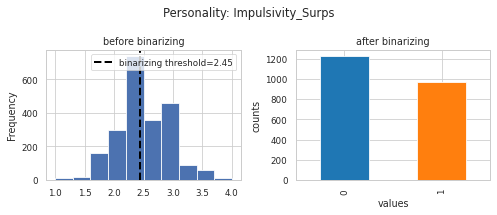

writing to .. posthoc-cc2-h5causal1-Impulsivity_SURPS.h5
attaching conf Impulsivity_SURPS
[WARN] n=1 subs missing this conf information. Dropping sample size from 565 to 564
-------------------  (31) Sensation_seeking   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (1.00, 2.70, 2.67, 4.00)


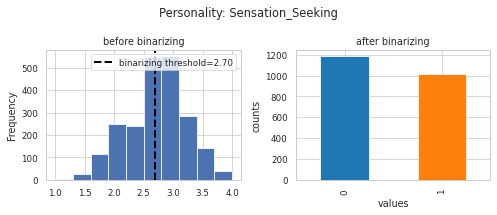

writing to .. posthoc-cc2-h5causal1-Sensation_seeking.h5
attaching conf Sensation_seeking
[WARN] n=1 subs missing this conf information. Dropping sample size from 565 to 564
-------------------  (32) Physical_developmet   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 23.17, 20.00, 38.00)


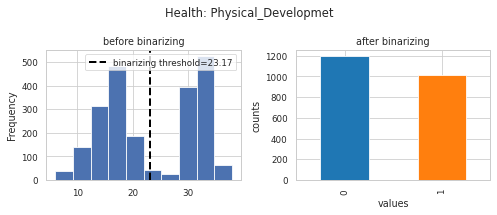

writing to .. posthoc-cc2-h5causal1-Physical_developmet.h5
attaching conf Physical_developmet
[WARN] n=1 subs missing this conf information. Dropping sample size from 565 to 564
-------------------  (33) Bullying   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 7.30, 6.00, 30.00)


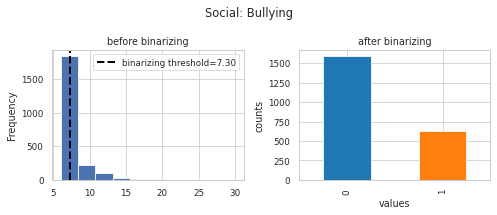

writing to .. posthoc-cc2-h5causal1-Bullying.h5
attaching conf Bullying
-------------------  (34) Bullying_victim   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (6.00, 8.16, 7.00, 30.00)


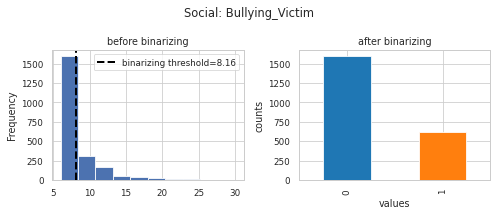

writing to .. posthoc-cc2-h5causal1-Bullying_victim.h5
attaching conf Bullying_victim
-------------------  (35) Social_difficulties   ----------------------
Using Q collected at session-BL
imputing 28/2223 missing values with nan
range (min, mean, median, max) = (0.00, 10.65, 10.00, 36.00)


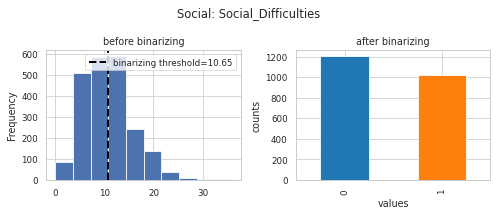

writing to .. posthoc-cc2-h5causal1-Social_difficulties.h5
attaching conf Social_difficulties
-------------------  (36) Social_difficulties_impact   ----------------------
Using Q collected at session-BL
imputing 28/2223 missing values with nan
range (min, mean, median, max) = (0.00, 0.43, 0.00, 10.00)


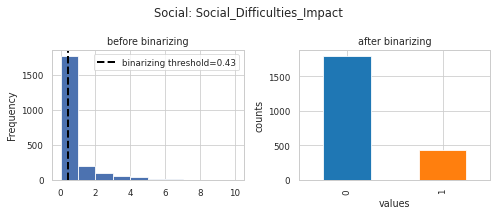

writing to .. posthoc-cc2-h5causal1-Social_difficulties_impact.h5
attaching conf Social_difficulties_impact
-------------------  (37) Prosocial_behavior   ----------------------
Using Q collected at session-BL
imputing 28/2223 missing values with nan
range (min, mean, median, max) = (0.00, 7.67, 8.00, 10.00)


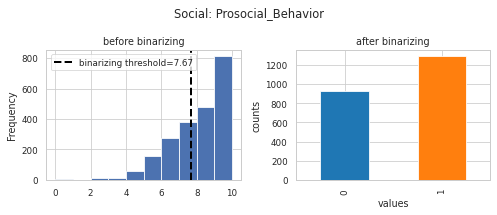

writing to .. posthoc-cc2-h5causal1-Prosocial_behavior.h5
attaching conf Prosocial_behavior
-------------------  (38) Alc_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 36/2132 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.69, 0.00, 26.00)


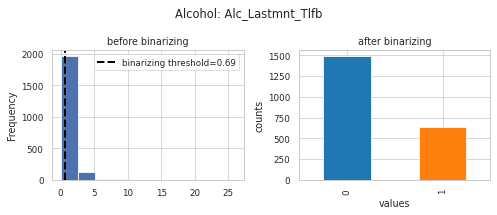

writing to .. posthoc-cc2-h5causal1-Alc_lastmnt_TLFB.h5
attaching conf Alc_lastmnt_TLFB
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (39) Tobacco_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 69/2132 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.95, 0.00, 30.00)


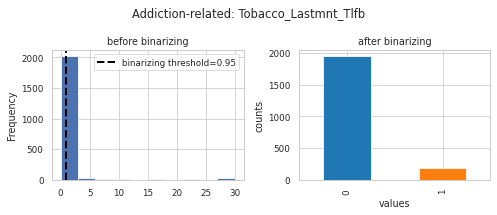

writing to .. posthoc-cc2-h5causal1-Tobacco_lastmnt_TLFB.h5
attaching conf Tobacco_lastmnt_TLFB
[ERROR] Failed to create h5: the value 1 in Tobacco_lastmnt_TLFB has fewer than 15% instances (n=23)
This is very small for counter balancing to work properly..
-------------------  (40) Drugs_lastmnt_TLFB   ----------------------
Using Q collected at session-BL
imputing 146/2132 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.25, 0.00, 60.00)


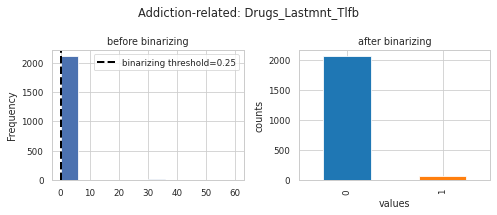

writing to .. posthoc-cc2-h5causal1-Drugs_lastmnt_TLFB.h5
attaching conf Drugs_lastmnt_TLFB
[ERROR] Failed to create h5: the value 1 in Drugs_lastmnt_TLFB has fewer than 15% instances (n=11)
This is very small for counter balancing to work properly..
-------------------  (41) Smoking_lifetime   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.83, 0.00, 6.00)


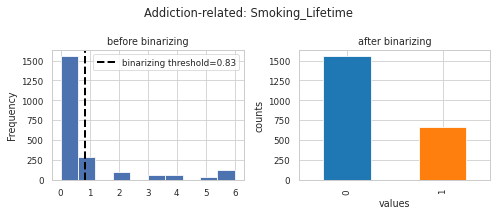

writing to .. posthoc-cc2-h5causal1-Smoking_lifetime.h5
attaching conf Smoking_lifetime
-------------------  (42) Smoking_lifetime   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.27, 4.00, 6.00)


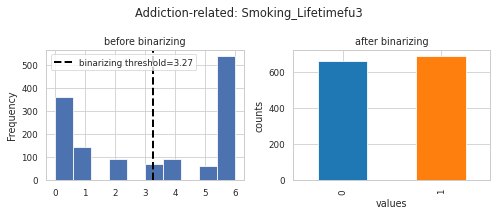

writing to .. posthoc-cc2-h5causal1-Smoking_lifetimeFU3.h5
attaching conf Smoking_lifetimeFU3
-------------------  (43) Alc-lastmnt   ----------------------
Using Q collected at session-FU3
imputing 59/1351 missing values with 0.0
range (min, mean, median, max) = (0.00, 2.31, 2.00, 6.00)


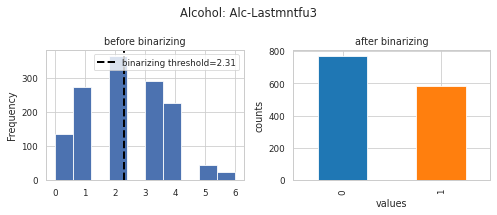

writing to .. posthoc-cc2-h5causal1-Alc-lastmntFU3.h5
attaching conf Alc-lastmntFU3
-------------------  (44) Alc-last12mnt   ----------------------
Using Q collected at session-FU3
imputing 25/1351 missing values with 0.0
range (min, mean, median, max) = (0.00, 4.48, 5.00, 6.00)


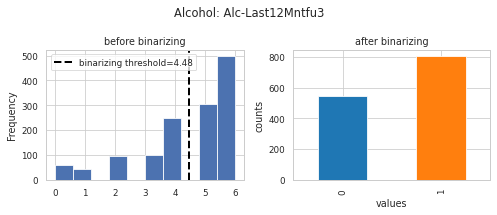

writing to .. posthoc-cc2-h5causal1-Alc-last12mntFU3.h5
attaching conf Alc-last12mntFU3
-------------------  (45) Neuroticism   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.77, 1.75, 4.00)


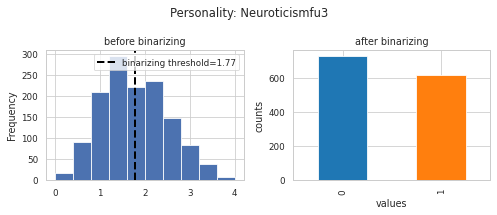

writing to .. posthoc-cc2-h5causal1-NeuroticismFU3.h5
attaching conf NeuroticismFU3
[WARN] n=2 subs missing this conf information. Dropping sample size from 565 to 563
-------------------  (46) Extroversion   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.67, 2.40, 2.42, 3.75)


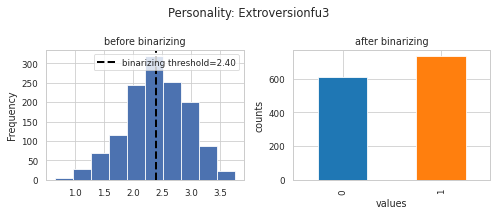

writing to .. posthoc-cc2-h5causal1-ExtroversionFU3.h5
attaching conf ExtroversionFU3
[WARN] n=2 subs missing this conf information. Dropping sample size from 565 to 563
-------------------  (47) Conscientiousness   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.50, 2.62, 2.67, 3.92)


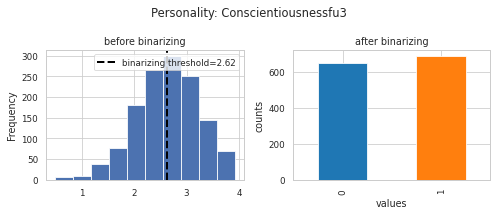

writing to .. posthoc-cc2-h5causal1-ConscientiousnessFU3.h5
attaching conf ConscientiousnessFU3
[WARN] n=2 subs missing this conf information. Dropping sample size from 565 to 563
-------------------  (48) Openness   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.75, 2.51, 2.50, 3.92)


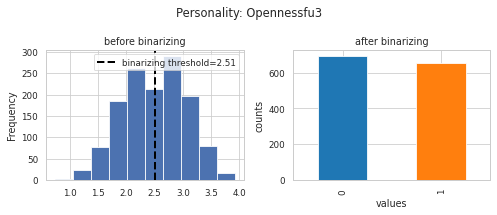

writing to .. posthoc-cc2-h5causal1-OpennessFU3.h5
attaching conf OpennessFU3
[WARN] n=2 subs missing this conf information. Dropping sample size from 565 to 563
-------------------  (49) Agreeableness   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.08, 2.74, 2.75, 4.00)


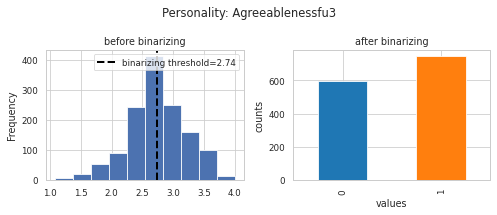

writing to .. posthoc-cc2-h5causal1-AgreeablenessFU3.h5
attaching conf AgreeablenessFU3
[WARN] n=2 subs missing this conf information. Dropping sample size from 565 to 563
-------------------  (50) Anxiety_sensitivity   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.34, 2.40, 4.00)


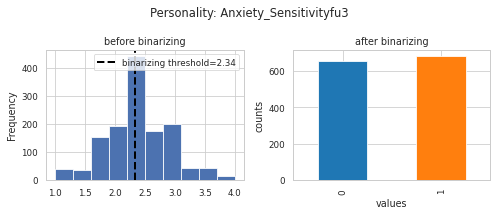

writing to .. posthoc-cc2-h5causal1-Anxiety_sensitivityFU3.h5
attaching conf Anxiety_sensitivityFU3
[WARN] n=4 subs missing this conf information. Dropping sample size from 565 to 561
-------------------  (51) Hopelessness   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.43, 2.93, 2.86, 3.71)


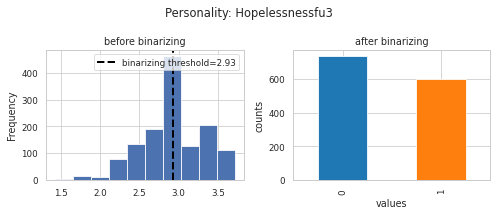

writing to .. posthoc-cc2-h5causal1-HopelessnessFU3.h5
attaching conf HopelessnessFU3
[WARN] n=4 subs missing this conf information. Dropping sample size from 565 to 561
-------------------  (52) Impulsivity_SURPS   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.13, 2.20, 4.00)


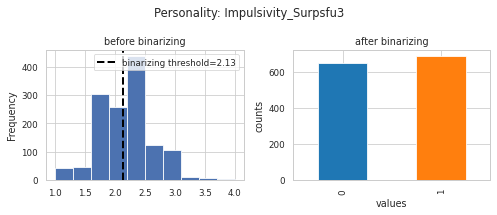

writing to .. posthoc-cc2-h5causal1-Impulsivity_SURPSFU3.h5
attaching conf Impulsivity_SURPSFU3
[WARN] n=4 subs missing this conf information. Dropping sample size from 565 to 561
-------------------  (53) Sensation_seeking   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.74, 2.83, 4.00)


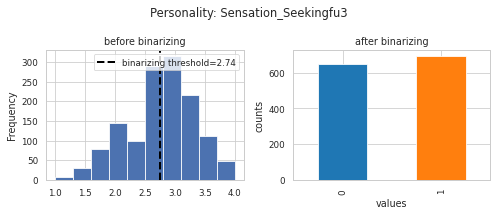

writing to .. posthoc-cc2-h5causal1-Sensation_seekingFU3.h5
attaching conf Sensation_seekingFU3
[WARN] n=4 subs missing this conf information. Dropping sample size from 565 to 561
-------------------  (54) Drug_abuse_lft   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.03, 0.00, 3.00)


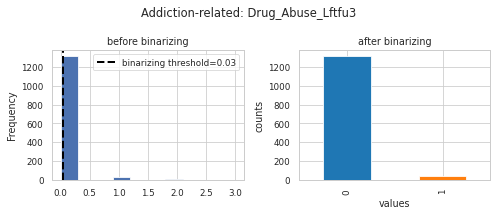

writing to .. posthoc-cc2-h5causal1-Drug_abuse_lftFU3.h5
attaching conf Drug_abuse_lftFU3
[ERROR] Failed to create h5: the value 1 in Drug_abuse_lftFU3 has fewer than 15% instances (n=11)
This is very small for counter balancing to work properly..
-------------------  (55) Nicotine_dependence   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.39, 0.00, 7.00)


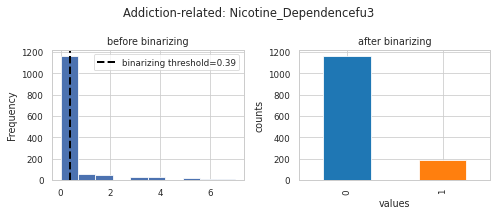

writing to .. posthoc-cc2-h5causal1-Nicotine_dependenceFU3.h5
attaching conf Nicotine_dependenceFU3
[ERROR] Failed to create h5: the value 1 in Nicotine_dependenceFU3 has fewer than 15% instances (n=73)
This is very small for counter balancing to work properly..
-------------------  (56) Comp_sub_abuse_lft   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.23, 0.00, 1.00)


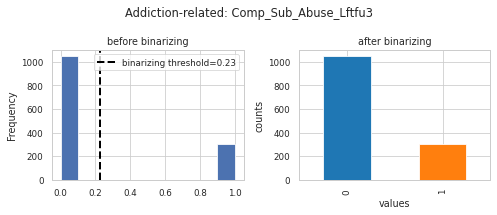

writing to .. posthoc-cc2-h5causal1-Comp_sub_abuse_lftFU3.h5
attaching conf Comp_sub_abuse_lftFU3
-------------------  (57) Smoking_lifetime   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.27, 4.00, 6.00)


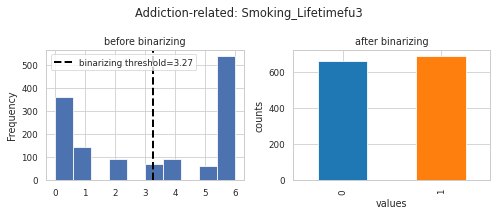

writing to .. posthoc-cc2-h5causal1-Smoking_lifetimeFU3.h5
attaching conf Smoking_lifetimeFU3
-------------------  (58) Alc_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.03, 5.00, 30.00)


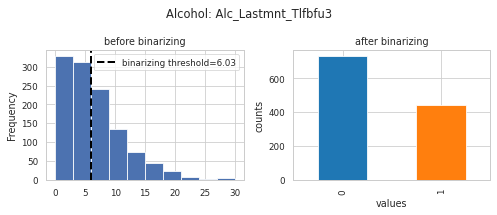

writing to .. posthoc-cc2-h5causal1-Alc_lastmnt_TLFBFU3.h5
attaching conf Alc_lastmnt_TLFBFU3
[WARN] n=102 subs missing this conf information. Dropping sample size from 565 to 463
-------------------  (59) Tobacco_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.46, 0.00, 30.00)


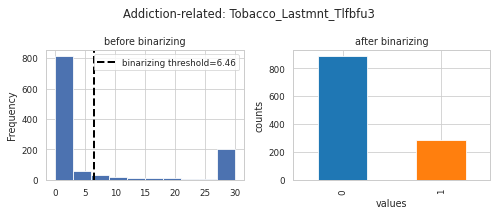

writing to .. posthoc-cc2-h5causal1-Tobacco_lastmnt_TLFBFU3.h5
attaching conf Tobacco_lastmnt_TLFBFU3
[WARN] n=102 subs missing this conf information. Dropping sample size from 565 to 463
-------------------  (60) Drugs_lastmnt_TLFB   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 5.32, 0.00, 75.00)


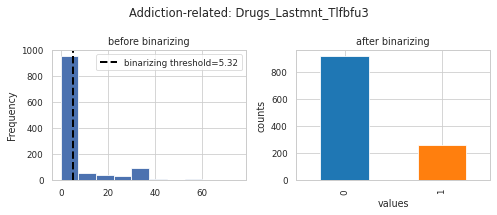

writing to .. posthoc-cc2-h5causal1-Drugs_lastmnt_TLFBFU3.h5
attaching conf Drugs_lastmnt_TLFBFU3
[WARN] n=102 subs missing this conf information. Dropping sample size from 565 to 463
-------------------  (61) Social_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 8.80, 9.00, 20.00)


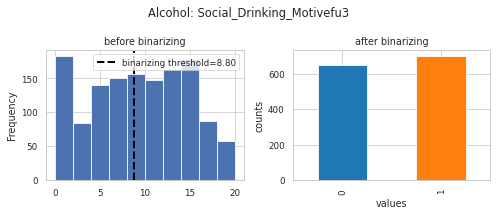

writing to .. posthoc-cc2-h5causal1-Social_drinking_motiveFU3.h5
attaching conf Social_drinking_motiveFU3
-------------------  (62) Coping_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.15, 2.00, 20.00)


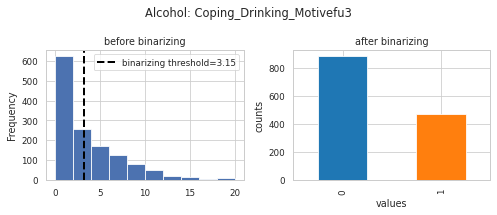

writing to .. posthoc-cc2-h5causal1-Coping_drinking_motiveFU3.h5
attaching conf Coping_drinking_motiveFU3
-------------------  (63) Enhancement_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 6.12, 5.00, 20.00)


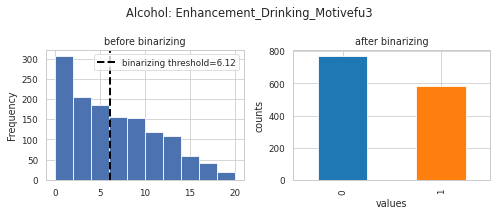

writing to .. posthoc-cc2-h5causal1-Enhancement_drinking_motiveFU3.h5
attaching conf Enhancement_drinking_motiveFU3
-------------------  (64) Conformity_drinking_motive   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.53, 0.00, 18.00)


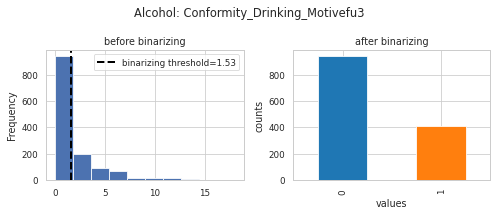

writing to .. posthoc-cc2-h5causal1-Conformity_drinking_motiveFU3.h5
attaching conf Conformity_drinking_motiveFU3
-------------------  (65) Alcohol_problem_index   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 3.51, 1.00, 42.00)


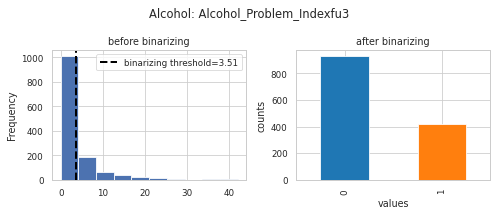

writing to .. posthoc-cc2-h5causal1-Alcohol_problem_indexFU3.h5
attaching conf Alcohol_problem_indexFU3
-------------------  (66) Somatization   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 8.18, 6.00, 63.00)


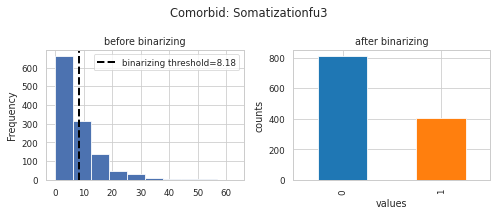

writing to .. posthoc-cc2-h5causal1-SomatizationFU3.h5
attaching conf SomatizationFU3
[WARN] n=57 subs missing this conf information. Dropping sample size from 565 to 508
-------------------  (67) Interpers_perspective_taking   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 56.61, 57.00, 85.00)


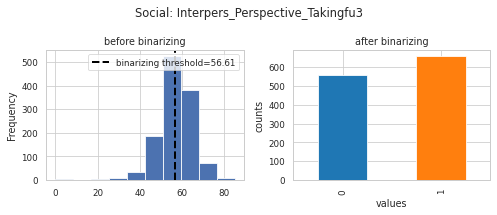

writing to .. posthoc-cc2-h5causal1-Interpers_perspective_takingFU3.h5
attaching conf Interpers_perspective_takingFU3
[WARN] n=57 subs missing this conf information. Dropping sample size from 565 to 508
-------------------  (68) Rumination   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (22.00, 39.01, 37.00, 88.00)


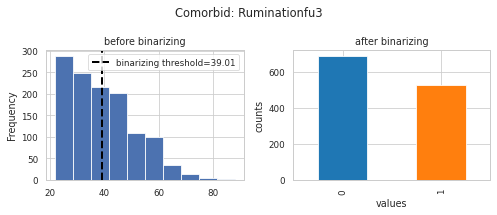

writing to .. posthoc-cc2-h5causal1-RuminationFU3.h5
attaching conf RuminationFU3
[WARN] n=57 subs missing this conf information. Dropping sample size from 565 to 508
-------------------  (69) Video_gaming_addiction   ----------------------
Using Q collected at session-FU3
imputing 781/1214 missing values with 0.0
range (min, mean, median, max) = (0.00, 1.29, 0.00, 7.00)


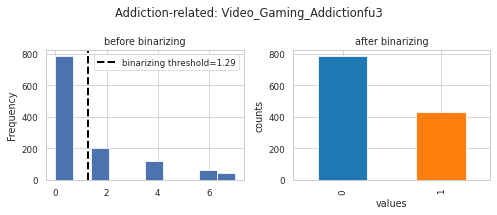

writing to .. posthoc-cc2-h5causal1-Video_gaming_addictionFU3.h5
attaching conf Video_gaming_addictionFU3
[WARN] n=59 subs missing this conf information. Dropping sample size from 565 to 506
-------------------  (70) Eating_disorder_restraint   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.79, 0.20, 6.00)


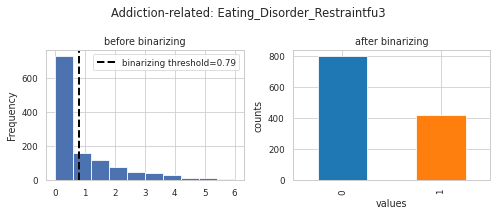

writing to .. posthoc-cc2-h5causal1-Eating_disorder_restraintFU3.h5
attaching conf Eating_disorder_restraintFU3
[WARN] n=58 subs missing this conf information. Dropping sample size from 565 to 507
-------------------  (71) Eating_disorder_eat_concern   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.35, 0.00, 5.60)


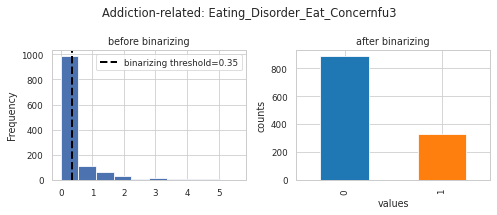

writing to .. posthoc-cc2-h5causal1-Eating_disorder_eat_concernFU3.h5
attaching conf Eating_disorder_eat_concernFU3
[WARN] n=58 subs missing this conf information. Dropping sample size from 565 to 507
-------------------  (72) Eating_disorder_shape_concern   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.34, 0.88, 6.00)


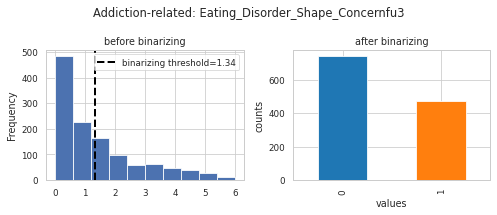

writing to .. posthoc-cc2-h5causal1-Eating_disorder_shape_concernFU3.h5
attaching conf Eating_disorder_shape_concernFU3
[WARN] n=58 subs missing this conf information. Dropping sample size from 565 to 507
-------------------  (73) Eating_disorder_weight_concern   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 1.03, 0.60, 6.00)


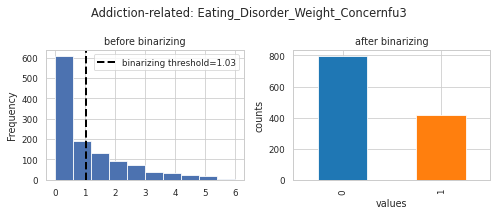

writing to .. posthoc-cc2-h5causal1-Eating_disorder_weight_concernFU3.h5
attaching conf Eating_disorder_weight_concernFU3
[WARN] n=58 subs missing this conf information. Dropping sample size from 565 to 507
-------------------  (74) Eating_behavior_cog_retrstraint   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 29.91, 29.17, 91.67)


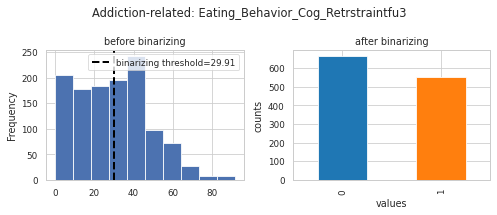

writing to .. posthoc-cc2-h5causal1-Eating_behavior_cog_retrstraintFU3.h5
attaching conf Eating_behavior_cog_retrstraintFU3
[WARN] n=58 subs missing this conf information. Dropping sample size from 565 to 507
-------------------  (75) Eating_behavior_uncontrolled_eating   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 29.71, 27.78, 75.00)


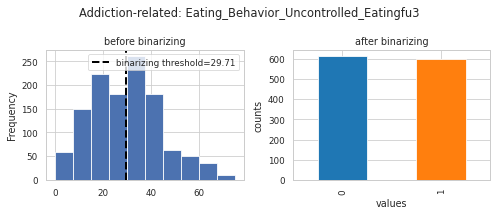

writing to .. posthoc-cc2-h5causal1-Eating_behavior_uncontrolled_eatingFU3.h5
attaching conf Eating_behavior_uncontrolled_eatingFU3
[WARN] n=58 subs missing this conf information. Dropping sample size from 565 to 507
-------------------  (76) Eating_behavior_emotional_eating   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 21.29, 16.67, 75.00)


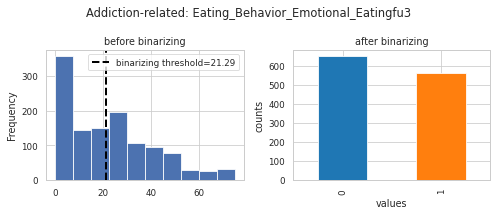

writing to .. posthoc-cc2-h5causal1-Eating_behavior_emotional_eatingFU3.h5
attaching conf Eating_behavior_emotional_eatingFU3
[WARN] n=58 subs missing this conf information. Dropping sample size from 565 to 507
-------------------  (77) Psychotic_experience   ----------------------
Using Q collected at session-FU3
imputing 1/1333 missing values with 0.0
range (min, mean, median, max) = (0.00, 60.21, 58.00, 112.00)


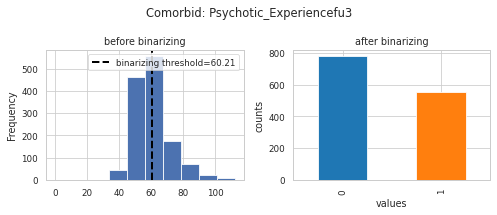

writing to .. posthoc-cc2-h5causal1-Psychotic_experienceFU3.h5
attaching conf Psychotic_experienceFU3
[WARN] n=8 subs missing this conf information. Dropping sample size from 565 to 557
-------------------  (78) Impulsivity_BIS   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (39.00, 61.95, 61.50, 102.00)


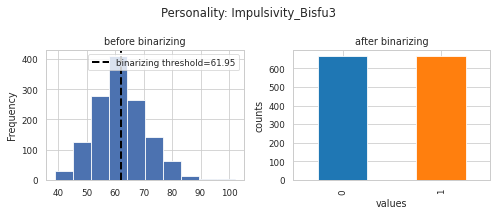

writing to .. posthoc-cc2-h5causal1-Impulsivity_BISFU3.h5
attaching conf Impulsivity_BISFU3
[WARN] n=9 subs missing this conf information. Dropping sample size from 565 to 556
-------------------  (79) Anxiety   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 7.33, 5.00, 48.00)


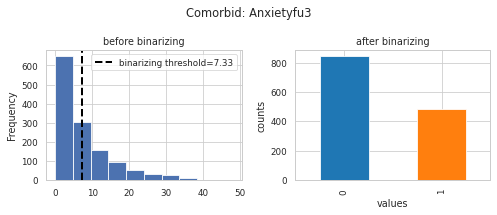

writing to .. posthoc-cc2-h5causal1-AnxietyFU3.h5
attaching conf AnxietyFU3
[WARN] n=9 subs missing this conf information. Dropping sample size from 565 to 556
-------------------  (80) Urbanicity   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (15.00, 39.05, 45.00, 45.00)


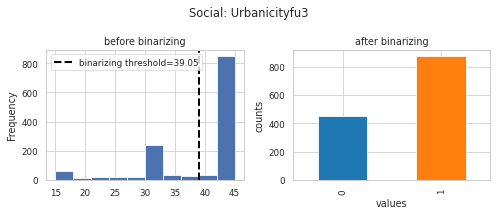

writing to .. posthoc-cc2-h5causal1-UrbanicityFU3.h5
attaching conf UrbanicityFU3
[WARN] n=9 subs missing this conf information. Dropping sample size from 565 to 556
-------------------  (81) Depression_CESD   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (22.00, 36.43, 35.00, 72.00)


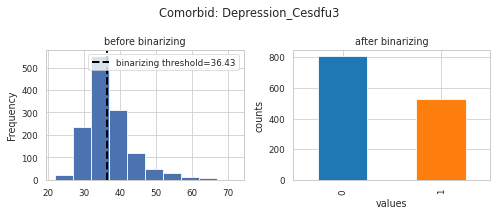

writing to .. posthoc-cc2-h5causal1-Depression_CESDFU3.h5
attaching conf Depression_CESDFU3
[WARN] n=5 subs missing this conf information. Dropping sample size from 565 to 560
-------------------  (82) Stress   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 12.63, 12.00, 34.00)


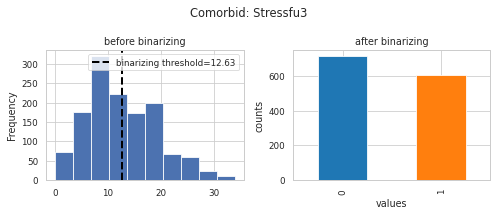

writing to .. posthoc-cc2-h5causal1-StressFU3.h5
attaching conf StressFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (83) Well_being   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 59.82, 64.00, 100.00)


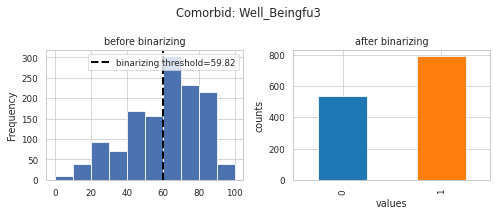

writing to .. posthoc-cc2-h5causal1-Well_beingFU3.h5
attaching conf Well_beingFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (84) Somatization_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.25, 0.14, 3.71)


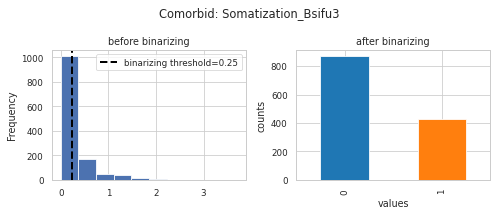

writing to .. posthoc-cc2-h5causal1-Somatization_BSIFU3.h5
attaching conf Somatization_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (85) Obsession_compulsion_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.59, 0.33, 3.50)


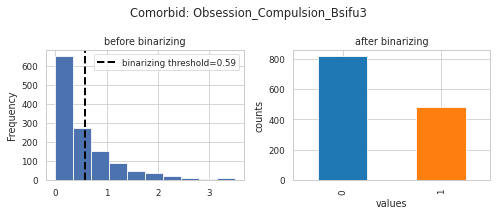

writing to .. posthoc-cc2-h5causal1-Obsession_compulsion_BSIFU3.h5
attaching conf Obsession_compulsion_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (86) Interpers_sensitivity_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.46, 0.25, 4.00)


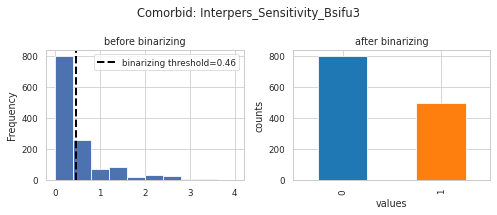

writing to .. posthoc-cc2-h5causal1-Interpers_sensitivity_BSIFU3.h5
attaching conf Interpers_sensitivity_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (87) Depression_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.44, 0.17, 4.00)


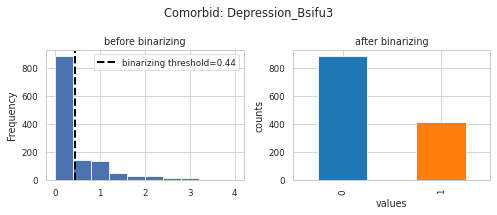

writing to .. posthoc-cc2-h5causal1-Depression_BSIFU3.h5
attaching conf Depression_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (88) Anxiety_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.34, 0.17, 3.50)


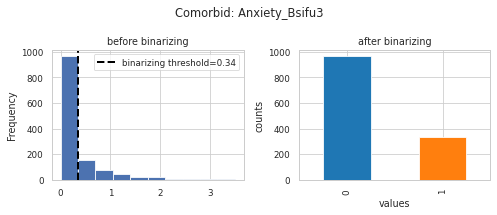

writing to .. posthoc-cc2-h5causal1-Anxiety_BSIFU3.h5
attaching conf Anxiety_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (89) Hostility_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.37, 0.20, 3.00)


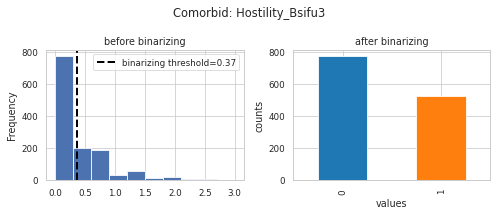

writing to .. posthoc-cc2-h5causal1-Hostility_BSIFU3.h5
attaching conf Hostility_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (90) Phobic_anxiety_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.17, 0.00, 3.40)


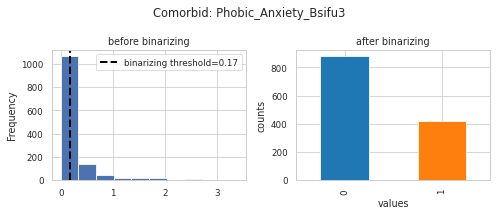

writing to .. posthoc-cc2-h5causal1-Phobic_anxiety_BSIFU3.h5
attaching conf Phobic_anxiety_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (91) Paranoid_ideation_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.33, 0.20, 4.00)


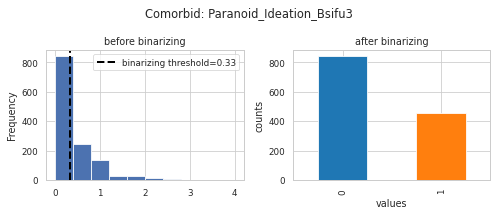

writing to .. posthoc-cc2-h5causal1-Paranoid_ideation_BSIFU3.h5
attaching conf Paranoid_ideation_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (92) Psychoticism_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.27, 0.00, 3.00)


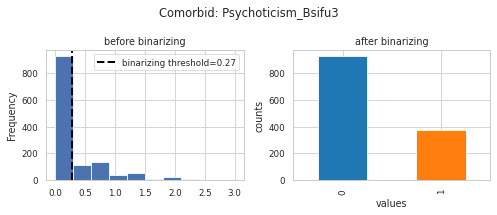

writing to .. posthoc-cc2-h5causal1-Psychoticism_BSIFU3.h5
attaching conf Psychoticism_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (93) GSI_BSI   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.36, 0.20, 2.82)


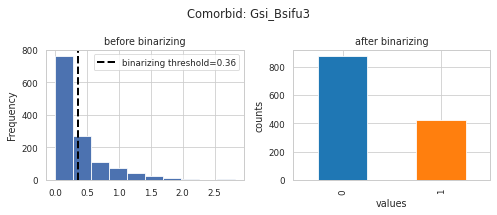

writing to .. posthoc-cc2-h5causal1-GSI_BSIFU3.h5
attaching conf GSI_BSIFU3
[WARN] n=16 subs missing this conf information. Dropping sample size from 565 to 549
-------------------  (94) Positive_affect   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (10.00, 26.66, 25.00, 50.00)


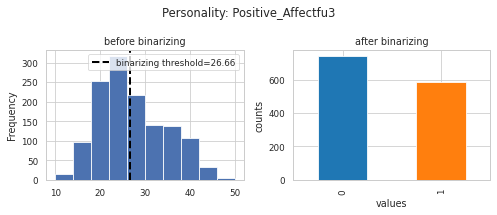

writing to .. posthoc-cc2-h5causal1-Positive_affectFU3.h5
attaching conf Positive_affectFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (95) Negative_affect   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (10.00, 20.80, 21.00, 41.00)


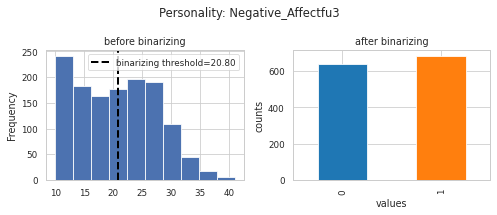

writing to .. posthoc-cc2-h5causal1-Negative_affectFU3.h5
attaching conf Negative_affectFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (96) Physical_health_conditions   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 0.42, 0.00, 6.00)


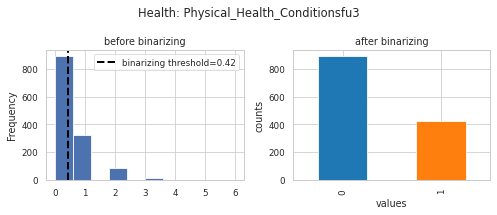

writing to .. posthoc-cc2-h5causal1-Physical_health_conditionsFU3.h5
attaching conf Physical_health_conditionsFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (97) QOL_self-rated_health   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 2.35, 2.00, 5.00)


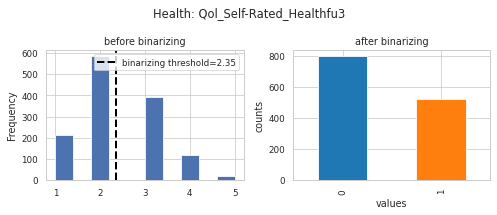

writing to .. posthoc-cc2-h5causal1-QOL_self-rated_healthFU3.h5
attaching conf QOL_self-rated_healthFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (98) QOL_phys_unhealthy_days   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 2.94, 1.00, 30.00)


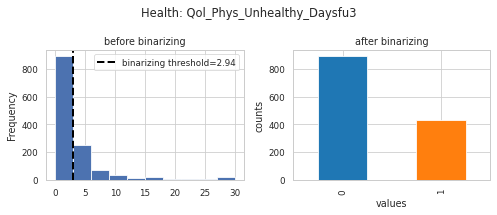

writing to .. posthoc-cc2-h5causal1-QOL_phys_unhealthy_daysFU3.h5
attaching conf QOL_phys_unhealthy_daysFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (99) QOL_mentally_unhealthy_days   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 4.61, 1.00, 30.00)


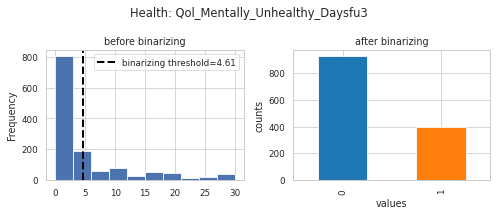

writing to .. posthoc-cc2-h5causal1-QOL_mentally_unhealthy_daysFU3.h5
attaching conf QOL_mentally_unhealthy_daysFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (100) QOL_activity_limitation_days   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (0.00, 2.19, 0.00, 30.00)


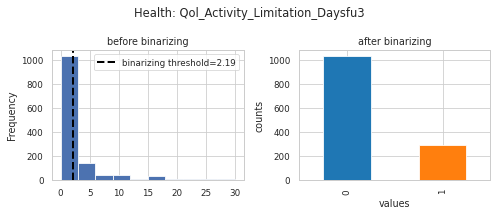

writing to .. posthoc-cc2-h5causal1-QOL_activity_limitation_daysFU3.h5
attaching conf QOL_activity_limitation_daysFU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (101) Depression_K6+   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (6.00, 25.36, 27.00, 30.00)


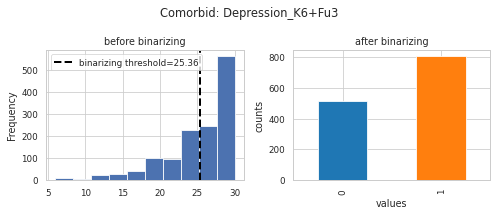

writing to .. posthoc-cc2-h5causal1-Depression_K6+FU3.h5
attaching conf Depression_K6+FU3
[WARN] n=10 subs missing this conf information. Dropping sample size from 565 to 555
-------------------  (102) Family_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.17, 0.20, 0.80)


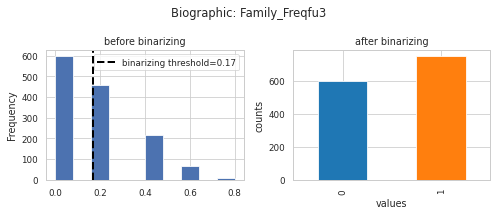

writing to .. posthoc-cc2-h5causal1-Family_freqFU3.h5
attaching conf Family_freqFU3
-------------------  (103) Family_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (-2.00, -0.39, -0.40, 2.00)


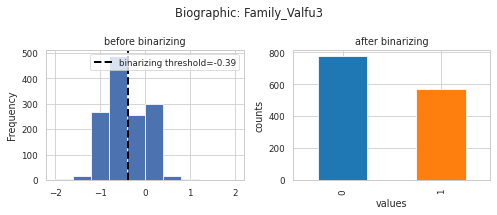

writing to .. posthoc-cc2-h5causal1-Family_valFU3.h5
attaching conf Family_valFU3
-------------------  (104) Accident_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.24, 0.25, 0.75)


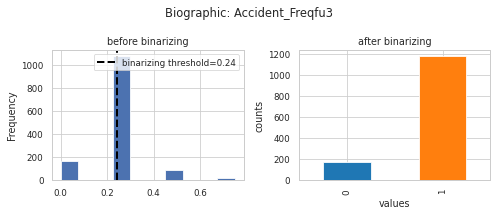

writing to .. posthoc-cc2-h5causal1-Accident_freqFU3.h5
attaching conf Accident_freqFU3
[ERROR] Failed to create h5: the value 0 in Accident_freqFU3 has fewer than 15% instances (n=74)
This is very small for counter balancing to work properly..
-------------------  (105) Accident_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (-2.00, 0.54, 0.50, 1.50)


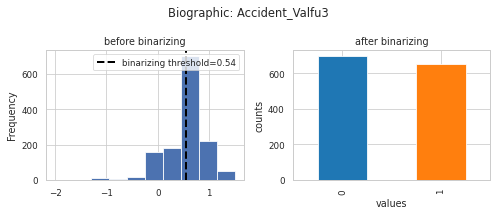

writing to .. posthoc-cc2-h5causal1-Accident_valFU3.h5
attaching conf Accident_valFU3
-------------------  (106) Sexuality_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.26, 0.29, 0.86)


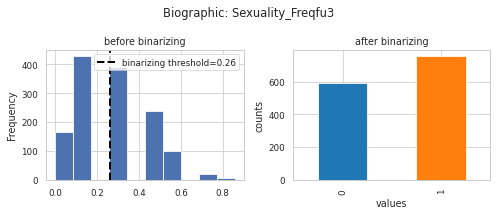

writing to .. posthoc-cc2-h5causal1-Sexuality_freqFU3.h5
attaching conf Sexuality_freqFU3
-------------------  (107) Sexuality_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (-1.57, -0.24, -0.21, 1.86)


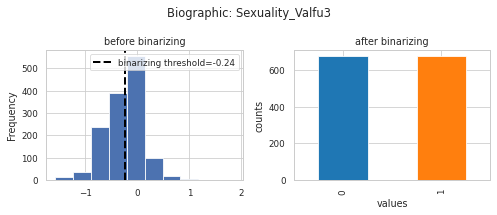

writing to .. posthoc-cc2-h5causal1-Sexuality_valFU3.h5
attaching conf Sexuality_valFU3
-------------------  (108) Autonomy_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.21, 0.25, 0.75)


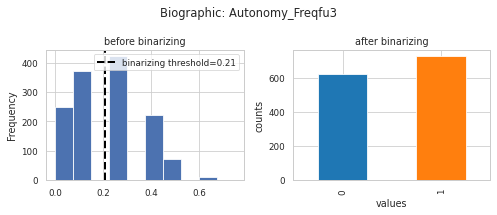

writing to .. posthoc-cc2-h5causal1-Autonomy_freqFU3.h5
attaching conf Autonomy_freqFU3
-------------------  (109) Autonomy_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (-2.00, -0.23, -0.25, 1.75)


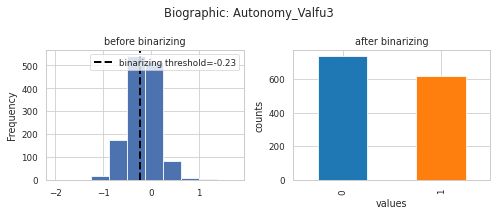

writing to .. posthoc-cc2-h5causal1-Autonomy_valFU3.h5
attaching conf Autonomy_valFU3
-------------------  (110) Deviance_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.28, 0.33, 1.00)


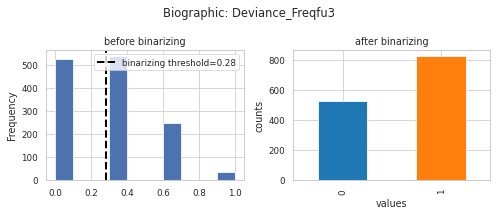

writing to .. posthoc-cc2-h5causal1-Deviance_freqFU3.h5
attaching conf Deviance_freqFU3
-------------------  (111) Deviance_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (-2.00, -0.81, -1.00, 1.33)


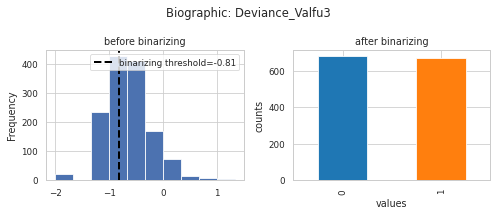

writing to .. posthoc-cc2-h5causal1-Deviance_valFU3.h5
attaching conf Deviance_valFU3
-------------------  (112) Relocation_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.10, 0.00, 1.00)


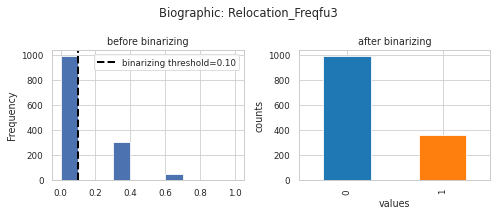

writing to .. posthoc-cc2-h5causal1-Relocation_freqFU3.h5
attaching conf Relocation_freqFU3
-------------------  (113) Relocation_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (-2.00, -0.03, 0.00, 1.67)


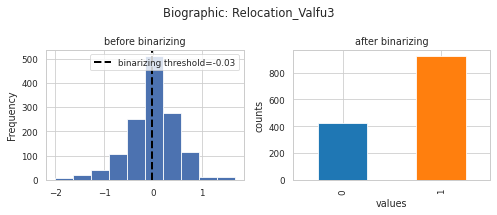

writing to .. posthoc-cc2-h5causal1-Relocation_valFU3.h5
attaching conf Relocation_valFU3
-------------------  (114) Distress_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.29, 0.33, 1.00)


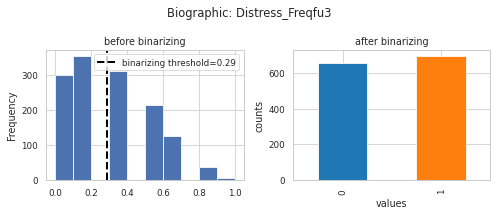

writing to .. posthoc-cc2-h5causal1-Distress_freqFU3.h5
attaching conf Distress_freqFU3
-------------------  (115) Distress_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (-1.83, -0.23, -0.17, 2.00)


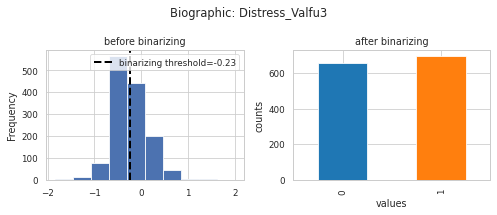

writing to .. posthoc-cc2-h5causal1-Distress_valFU3.h5
attaching conf Distress_valFU3
-------------------  (116) Total_freq   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.23, 0.23, 0.67)


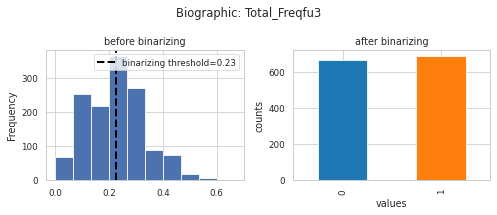

writing to .. posthoc-cc2-h5causal1-Total_freqFU3.h5
attaching conf Total_freqFU3
-------------------  (117) Total_val   ----------------------
Using Q collected at session-FU3
imputing 11/1350 missing values with 0.0
range (min, mean, median, max) = (-1.87, -0.13, -0.13, 1.64)


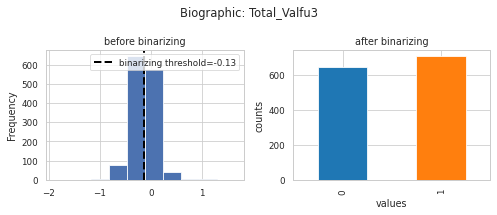

writing to .. posthoc-cc2-h5causal1-Total_valFU3.h5
attaching conf Total_valFU3
-------------------  (118) Psychiatric_symptoms_PHQ   ----------------------
Using Q collected at session-FU3
range (min, mean, median, max) = (1.00, 5.56, 4.00, 24.00)


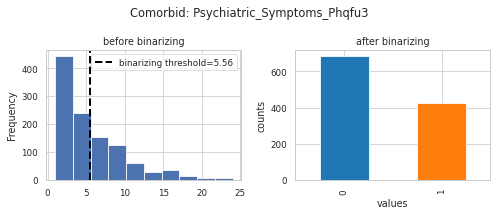

writing to .. posthoc-cc2-h5causal1-Psychiatric_symptoms_PHQFU3.h5
attaching conf Psychiatric_symptoms_PHQFU3
[WARN] n=109 subs missing this conf information. Dropping sample size from 565 to 456
-------------------  (119) Social_difficulties   ----------------------
Using Q collected at session-FU3
imputing 3/1315 missing values with nan
range (min, mean, median, max) = (0.00, 9.20, 9.00, 31.00)


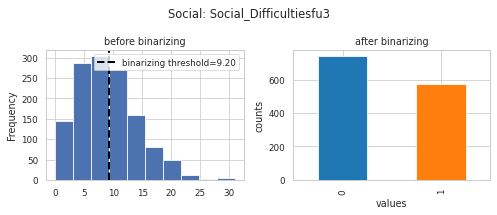

writing to .. posthoc-cc2-h5causal1-Social_difficultiesFU3.h5
attaching conf Social_difficultiesFU3
[WARN] n=20 subs missing this conf information. Dropping sample size from 565 to 545
-------------------  (120) Social_difficulties_impact   ----------------------
Using Q collected at session-FU3
imputing 3/1315 missing values with nan
range (min, mean, median, max) = (0.00, 0.67, 0.00, 10.00)


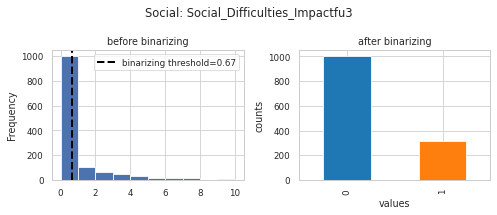

writing to .. posthoc-cc2-h5causal1-Social_difficulties_impactFU3.h5
attaching conf Social_difficulties_impactFU3
[WARN] n=20 subs missing this conf information. Dropping sample size from 565 to 545
-------------------  (121) Prosocial_behavior   ----------------------
Using Q collected at session-FU3
imputing 3/1315 missing values with nan
range (min, mean, median, max) = (2.00, 8.56, 9.00, 10.00)


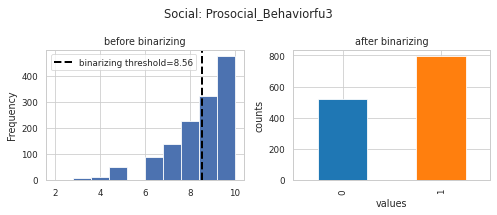

writing to .. posthoc-cc2-h5causal1-Prosocial_behaviorFU3.h5
attaching conf Prosocial_behaviorFU3
[WARN] n=20 subs missing this conf information. Dropping sample size from 565 to 545
-------------------  (122) Bullying   ----------------------
Using Q collected at session-FU3
imputing 1/1351 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.28, 0.00, 6.00)


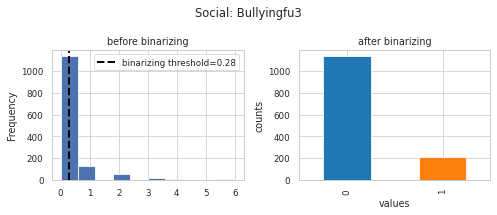

writing to .. posthoc-cc2-h5causal1-BullyingFU3.h5
attaching conf BullyingFU3
-------------------  (123) Bullying_victim   ----------------------
Using Q collected at session-FU3
imputing 1/1351 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.66, 0.00, 20.00)


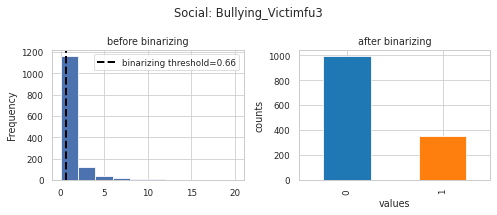

writing to .. posthoc-cc2-h5causal1-Bullying_victimFU3.h5
attaching conf Bullying_victimFU3
-------------------  (124) Alcoholism_screening_parent   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 1.50, 0.00, 50.00)


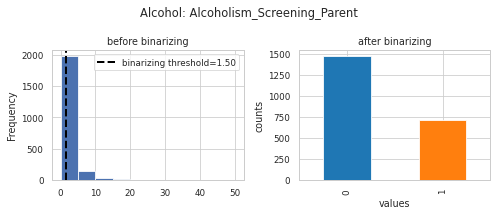

writing to .. posthoc-cc2-h5causal1-Alcoholism_screening_parent.h5
attaching conf Alcoholism_screening_parent
[WARN] n=3 subs missing this conf information. Dropping sample size from 565 to 562
-------------------  (125) Drug_abuse_screening_parent   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 2.29, 0.00, 69.00)


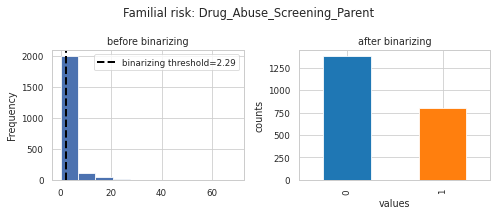

writing to .. posthoc-cc2-h5causal1-Drug_abuse_screening_parent.h5
attaching conf Drug_abuse_screening_parent
[WARN] n=2 subs missing this conf information. Dropping sample size from 565 to 563
-------------------  (126) Conflict_tactics_parent_mean_assault   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.04, 0.00, 5.29)


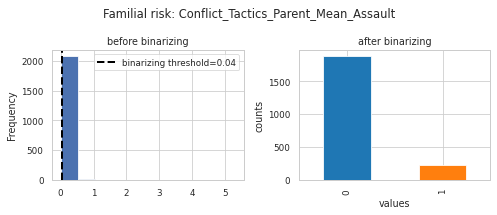

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_assault.h5
attaching conf Conflict_tactics_parent_mean_assault
[ERROR] Failed to create h5: the value 1 in Conflict_tactics_parent_mean_assault has fewer than 15% instances (n=58)
This is very small for counter balancing to work properly..
-------------------  (127) Conflict_tactics_parent_mean_injury   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.04, 0.00, 6.25)


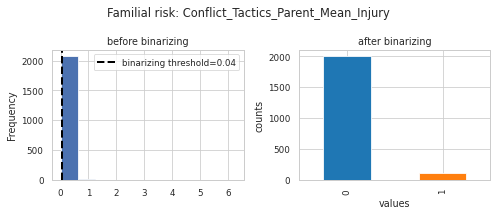

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_injury.h5
attaching conf Conflict_tactics_parent_mean_injury
[ERROR] Failed to create h5: the value 1 in Conflict_tactics_parent_mean_injury has fewer than 15% instances (n=27)
This is very small for counter balancing to work properly..
-------------------  (128) Conflict_tactics_parent_mean_negotiation   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 7.12, 5.83, 25.00)


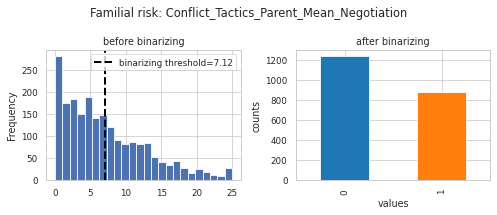

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_negotiation.h5
attaching conf Conflict_tactics_parent_mean_negotiation
[WARN] n=12 subs missing this conf information. Dropping sample size from 565 to 553
-------------------  (129) Conflict_tactics_parent_mean_psych_aggr   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.96, 0.31, 13.88)


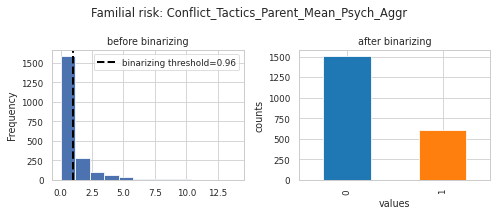

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_mean_psych_aggr.h5
attaching conf Conflict_tactics_parent_mean_psych_aggr
[WARN] n=12 subs missing this conf information. Dropping sample size from 565 to 553
-------------------  (130) Conflict_tactics_parent_sexual_coercion   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.41, 0.00, 12.50)


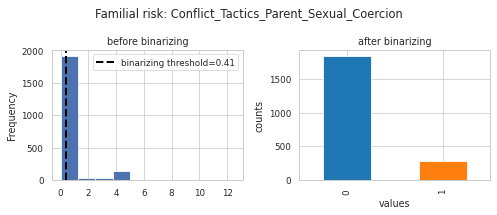

writing to .. posthoc-cc2-h5causal1-Conflict_tactics_parent_sexual_coercion.h5
attaching conf Conflict_tactics_parent_sexual_coercion
[ERROR] Failed to create h5: the value 1 in Conflict_tactics_parent_sexual_coercion has fewer than 15% instances (n=74)
This is very small for counter balancing to work properly..
-------------------  (131) Fam_hist_psych_disorders_parent   ----------------------
Using Q collected at session-BL
imputing 55/2191 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.50, 1.00, 1.00)


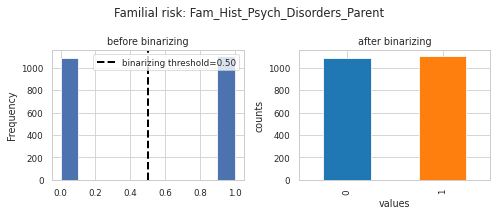

writing to .. posthoc-cc2-h5causal1-Fam_hist_psych_disorders_parent.h5
attaching conf Fam_hist_psych_disorders_parent
-------------------  (132) PBQ_cigarettes_pregnancy   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-3.00, 2.74, 0.00, 90.00)


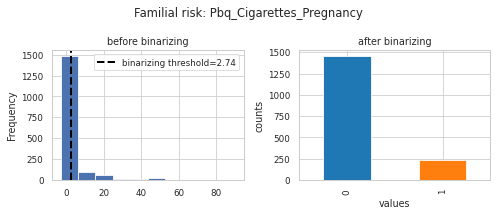

writing to .. posthoc-cc2-h5causal1-PBQ_cigarettes_pregnancy.h5
attaching conf PBQ_cigarettes_pregnancy
[ERROR] Failed to create h5: the value 1 in PBQ_cigarettes_pregnancy has fewer than 15% instances (n=54)
This is very small for counter balancing to work properly..
-------------------  (133) PBQ_cigarettes_breastfeeding   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (-2.00, 0.57, 0.00, 30.00)


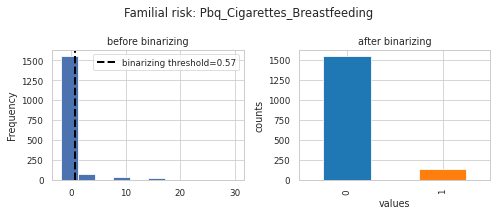

writing to .. posthoc-cc2-h5causal1-PBQ_cigarettes_breastfeeding.h5
attaching conf PBQ_cigarettes_breastfeeding
[ERROR] Failed to create h5: the value 1 in PBQ_cigarettes_breastfeeding has fewer than 15% instances (n=32)
This is very small for counter balancing to work properly..
-------------------  (134) PBQ_pres_meds   ----------------------
Using Q collected at session-BL
imputing 61/1688 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.13, 0.00, 1.00)


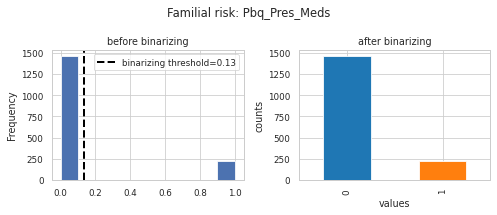

writing to .. posthoc-cc2-h5causal1-PBQ_pres_meds.h5
attaching conf PBQ_pres_meds
[ERROR] Failed to create h5: the value 1 in PBQ_pres_meds has fewer than 15% instances (n=64)
This is very small for counter balancing to work properly..
-------------------  (135) PBQ_unpres_meds   ----------------------
Using Q collected at session-BL
imputing 94/1688 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.21, 0.00, 1.00)


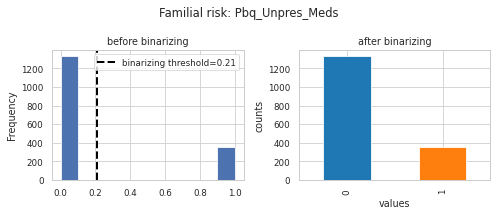

writing to .. posthoc-cc2-h5causal1-PBQ_unpres_meds.h5
attaching conf PBQ_unpres_meds
[WARN] n=107 subs missing this conf information. Dropping sample size from 565 to 458
-------------------  (136) PBQ_drugs   ----------------------
Using Q collected at session-BL
imputing 11/1688 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.01, 0.00, 1.00)


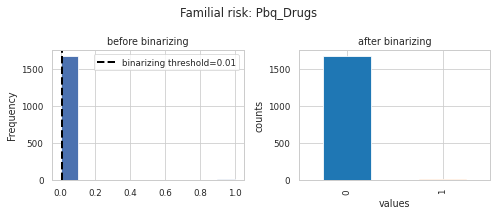

writing to .. posthoc-cc2-h5causal1-PBQ_drugs.h5
attaching conf PBQ_drugs
[ERROR] Failed to create h5: the value 1 in PBQ_drugs has fewer than 15% instances (n=2)
This is very small for counter balancing to work properly..
-------------------  (137) AUDIT_parent   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 3.74, 3.00, 29.00)


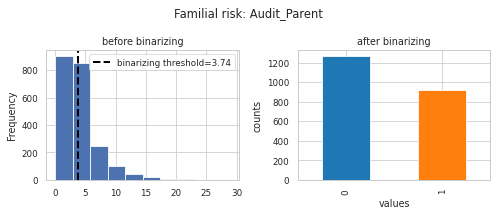

writing to .. posthoc-cc2-h5causal1-AUDIT_parent.h5
attaching conf AUDIT_parent
[WARN] n=2 subs missing this conf information. Dropping sample size from 565 to 563


In [16]:
df_conf_list = pd.read_excel("Confounds_list_Milena_v3.xlsx")

for i,row in df_conf_list.iterrows():
    print(f"-------------------  ({i}) {row['conf_name']}   ----------------------")
    # load the confound from corresponding questionnaire as a pandas Series
    # print(f"From {CONF_DATA_DIR+row['questionnaire']} reading column '{row['colname']}'")
    if '???' in row["questionnaire"] or '???' in row["colname"]:
        print(f"[ERROR] {row['conf_name']} missing preprocessed tables. Extract this first.")
        continue
        
    if 'FU' in h5_name.upper() and ('FU' not in row['time_point'].upper()) and row['subject']!='parent':
        print(f"Skipping this conf since it is not applicable for FUx timepoint analysis")
        continue
        
    df_conf = pd.read_csv(CONF_DATA_DIR + row["questionnaire"]).set_index('ID')

    if ('Session' in df_conf):
        conf = df_conf.loc[df_conf['Session']==row['time_point'], row['colname']] 
        if print_all: print(f"Using Q collected at session-{row['time_point']}")
    elif ('Session' in df_conf and df_conf['Session'].nunique()>1):
        conf = df_conf.loc[df_conf['Session']=='FU3', row['colname']] 
        if print_all: print(f"Using Q collected at session-FU3")
    else:
        conf = df_conf[row['colname']]
        if print_all: print(f"Using Q collected at session-???")

    # attach the timepoint to the name if it is not BL 
    conf.name = row['conf_name']
    if row['time_point'] != 'BL': 
        conf.name += row['time_point']

    # impute missing values with given value
    if conf.isna().sum() and isinstance(row['impute_missing_with'], (int,float)):
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing values with {row['impute_missing_with']}")
        conf = conf.fillna(row['impute_missing_with'])
    elif conf.isna().sum():
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing with K-Nearest-Neighbour algorithm")
        # use KNN
        conf.loc[:] = KNNImputer().fit_transform(conf.values.reshape(-1, 1)).ravel()

    # plot conf distribution before binarizing
    if plot_dist:
        f, axes = plt.subplots(1,2, figsize=(7,3), sharey=False)
        plt.suptitle(f"{row['category']}: {conf.name.title()}")

        kwargs = dict(ax=axes[0],
            title="before binarizing", 
            xlabel='values', ylabel='counts')

        nunique = conf.nunique()

        conf.plot(
            kind='hist', bins=10 if nunique<100 else nunique//10,
            **kwargs)

        if print_all: print(
            f"range (min, mean, median, max) = ({conf.min():.2f}, {conf.mean():.2f}, {conf.median():.2f}, {conf.max():.2f})")

    # binarize 
    binarizing_threshold = conf.median() if row['binarizing_threshold']=='median' else conf.mean()
    conf = conf.apply(lambda x: int(x>binarizing_threshold))

    # plot conf distribution after binarizing
    if plot_dist:
        # draw the threshold in the prev plot
        axes[0].axvline(binarizing_threshold, c='k', ls='--', lw=2, label='binarizing threshold')
        hdls, lbls = axes[0].get_legend_handles_labels()
        axes[0].legend([hdls[0]], ['binarizing threshold={:.2f}'.format(binarizing_threshold)])

        colors = [plt.get_cmap("tab10")(v) for v in sorted(conf.unique())]
        conf.value_counts(dropna=False).sort_index().plot(
            ax=axes[1], kind='bar',
            title="after binarizing", 
            xlabel='values', ylabel='counts', color=colors)
        plt.tight_layout()
        plt.show()

    # attach conf to the h5 file
    try:
        attach_conf_fromseries(H5_DIR, h5_src, conf, prepend=h5_name, print_all=print_all)
    except AssertionError as e:
        print("[ERROR] Failed to create h5:",e)
            # @Milena look at the log below for the 120+ confounds

### Check h5files

In [17]:
# check_h5_contents(glob(H5_DIR+f"posthoc-cc2-*.h5")) #{h5_name}

In [18]:
print("Created {} h5 files".format(len(glob(H5_DIR+f"posthoc-cc2-*{h5_name}*.h5")))) #{h5_name}

Created 123 h5 files


In [17]:
print_h5_for_MLpipeline(filter_func=lambda x: f"posthoc-cc2-{h5_name}" in x) #{h5_name}

  DATA_DIR + 'h5files/posthoc-cc2-h5bl-AUDIT_parent.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Accident_freq.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Accident_val.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Accident_valFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Age_first_drunkFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Agreeableness.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-AgreeablenessFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Alc-last12mnt.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Alc-last12mntFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Alc-lastmnt.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Alc-lastmntFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Alc_lastmnt_TLFB.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Alc_lastmnt_TLFBFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Alcohol_problem_indexFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-Alcoholism_screening_parent.h5',
  DATA_DIR + 'h5files/posthoc-cc2-h5bl-AnxietyFU3.h5',
  DATA_DIR + 'h5files/posthoc-c

### Run MLpipeline
 Add the above h5files in runMLpipelines.py, configure the appropriate settings and run it as
 `$nohup python3 runMLpipeline.py &`

## Exploratory stage

In [15]:
# map the categories and the confound name
df_conf_list = pd.read_excel("Confounds_list_Milena_v3.xlsx")
all_confs = (df_conf_list['conf_name']+df_conf_list['time_point']).apply(lambda x: x[::-1].replace("LB","",1)[::-1]) # remove the last 'BL'in conf name
df_conf_list['confound_final_name'] = all_confs
all_confs = all_confs.unique().tolist()
print("n confounds in the table:",len(all_confs))

cat_map = df_conf_list[['category','confound_final_name']].drop_duplicates(ignore_index=True)
cat_map = cat_map.set_index('confound_final_name', drop=True).squeeze().to_dict()

n confounds in the table: 137


In [16]:
# for each h5 and do other checks and preprocessings
all_df = {}
for h5_name in ['h5causal0']: ## @remove 'h5bl'
    dfi = create_accuracy_csv(h5_name)
    display(dfi)
    dfi['h5cat'] = h5_name
    dfi = dfi.loc[(dfi['Model'].isin(['SVM-rbf']))].sort_values( ## @remove 'GB'
        ['Accuracy Diff CB - BL'])
    print(f"{'-'*20}\nh5_name = {h5_name}:\n{'-'*20} \n accuracy range (max-drop, max-gain) = \
({dfi['Accuracy Diff CB - BL'].min()*100:.0f}%, {dfi['Accuracy Diff CB - BL'].max()*100:.0f}%)")
    
    confounds = dfi.Confound.unique().tolist()
    
    print(f" no. of accepted variables = {len(confounds)}")
    skipped = [c for c in all_confs if c not in confounds]
    # for FU3 filter out non-FU3 confs as they were skipped on purpose
    if 'fu3' in h5_name:
        skipped = [k for k in skipped if (('FU3' in skipped[-4:]) or ('FU2' in skipped[-4:]))]
    print(f" {len(skipped)} of skipped variables : {skipped}")
    
    
    # add the cat_map to the df csv 
    dfi['category'] = dfi.apply(lambda row: cat_map[row['Confound']] if row['Confound'] in cat_map else np.nan, axis=1)
    dfi.to_csv(f"results_explorative_{h5_name}.csv")
    all_df.update({h5_name: dfi})
    
    
    # define lower and upper threshold based on results in section 'exploratory results summary plot' - @Roshan: this is still hard coded, didn't adapt it til now
    lower_threshold=-2.9153173773
    upper_threshold=1.4510502575
    
    # filter out variables below and above SD-defined threshold
    dfi_top_red_0 = dfi.loc[(dfi['Accuracy Diff CB - BL']<=(lower_threshold/100))].sort_values( ## @remove 'GB'
    ['Accuracy Diff CB - BL'])
    
    dfi_top_red_0.to_csv(f"results_explorative_{h5_name}_top_red.csv", index=False)
    top_red_0 = dfi_top_red_0.Confound.unique().tolist()

    dfi_top_incr_0 = dfi.loc[(dfi['Accuracy Diff CB - BL']>=(upper_threshold/100))].sort_values( ## @remove 'GB'
    ['Accuracy Diff CB - BL'])
    
    dfi_top_incr_0.to_csv(f"results_explorative_{h5_name}_top_incr.csv", index=False)
    top_incr_0 = dfi_top_incr_0.Confound.unique().tolist()
    
    display(dfi_top_red_0, dfi_top_incr_0)

Confound Conf_time_point    Model  \
0                      Relocation_freq              BL       GB   
1                      Relocation_freq              BL       LR   
2                      Relocation_freq              BL  SVM-lin   
3                      Relocation_freq              BL  SVM-rbf   
4                   Positive_affectFU3              BL       GB   
..                                 ...             ...      ...   
475  Eating_disorder_weight_concernFU3              BL  SVM-rbf   
476       Eating_disorder_restraintFU3              BL       GB   
477       Eating_disorder_restraintFU3              BL       LR   
478       Eating_disorder_restraintFU3              BL  SVM-lin   
479       Eating_disorder_restraintFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
0                posthoc-cc2-h5causal0-Relocation_freq     0.651304   
1                posthoc-cc2-h5causal0-Relocation_freq     0.576899   
2                posthoc-cc2-h5causal0-Relocation_freq     0.559660   
3                posthoc-cc2-h5causal0-Relocation_freq     0.651324   
4             posthoc-cc2-h5causal0-Positive_affectFU3     0.651304   
..                                                 ...          ...   
475  posthoc-cc2-h5causal0-Eating_disorder_weight_c...     0.651324   
476  posthoc-cc2-h5causal0-Eating_disorder_restrain...     0.651304   
477  posthoc-cc2-h5causal0-Eating_disorder_restrain...     0.576899   
478  posthoc-cc2-h5causal0-Eating_disorder_restrain...     0.559660   
479  posthoc-cc2-h5causal0-Eating_disorder_restrain...     0.651324   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
0      0.048134     0.644032    0.028854              -0.007272   
1      0.061446     0.581754    0.055085               0.004855   
2      0.078044     0.571900    0.029339               0.012239   
3      0.048869     0.661799    0.054784               0.010475   
4      0.048134     0.666982    0.052068               0.015678   
..          ...          ...         ...                    ...   
475    0.048869     0.620010    0.064247              -0.031314   
476    0.048134     0.622516    0.069305              -0.028788   
477    0.061446     0.551748    0.060399              -0.025151   
478    0.078044     0.573263    0.060459               0.013602   
479    0.048869     0.623289    0.076822              -0.028035   

     Std-Dev Diff CB - BL  
0            4.504333e-15  
1           -1.455185e-15  
2            9.833404e-16  
3           -2.918301e-15  
4            2.918301e-15  
..                    ...  
475          4.440892e-16  
476         -9.833404e-16  
477          8.247371e-16  
478          0.000000e+00  
479          5.075305e-16  

[480 rows x 10 columns]

--------------------
h5_name = h5causal0:
-------------------- 
 accuracy range (max-drop, max-gain) = (-7%, 4%)
 no. of accepted variables = 120
 17 of skipped variables : ['Drug_abuse_lft', 'Nicotine_dependence', 'Comp_sub_abuse_lft', 'Tobacco_lastmnt_TLFB', 'Drugs_lastmnt_TLFB', 'Smoking_lifetime', 'Drug_abuse_lftFU3', 'Nicotine_dependenceFU3', 'Accident_freqFU3', 'BullyingFU3', 'Conflict_tactics_parent_mean_assault', 'Conflict_tactics_parent_mean_injury', 'Conflict_tactics_parent_sexual_coercion', 'PBQ_cigarettes_pregnancy', 'PBQ_cigarettes_breastfeeding', 'PBQ_pres_meds', 'PBQ_drugs']


Confound Conf_time_point    Model  \
199                 Alcohol_problem_indexFU3              BL  SVM-rbf   
355   Eating_behavior_uncontrolled_eatingFU3              BL  SVM-rbf   
243                           Alc-lastmntFU3              BL  SVM-rbf   
415              Psychiatric_symptoms_PHQFU3              BL  SVM-rbf   
203                      Smoking_lifetimeFU3              BL  SVM-rbf   
427       Eating_behavior_cog_retrstraintFU3              BL  SVM-rbf   
311                      Alc_lastmnt_TLFBFU3              BL  SVM-rbf   
455                        Sexuality_freqFU3              BL  SVM-rbf   
135                        Sensation_seeking              BL  SVM-rbf   
107            Conformity_drinking_motiveFU3              BL  SVM-rbf   
83                          Alc-last12mntFU3              BL  SVM-rbf   
11       Eating_behavior_emotional_eatingFU3              BL  SVM-rbf   
435  Conflict_tactics_parent_mean_psych_aggr              BL  SVM-rbf   
235                         Alc_lastmnt_TLFB              BL  SVM-rbf   
475        Eating_disorder_weight_concernFU3              BL  SVM-rbf   
451                                 Openness              BL  SVM-rbf   
35                            NeuroticismFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
199     posthoc-cc2-h5causal0-Alcohol_problem_indexFU3     0.651324   
355  posthoc-cc2-h5causal0-Eating_behavior_uncontro...     0.651324   
243               posthoc-cc2-h5causal0-Alc-lastmntFU3     0.651324   
415  posthoc-cc2-h5causal0-Psychiatric_symptoms_PHQFU3     0.651324   
203          posthoc-cc2-h5causal0-Smoking_lifetimeFU3     0.651324   
427  posthoc-cc2-h5causal0-Eating_behavior_cog_retr...     0.651324   
311          posthoc-cc2-h5causal0-Alc_lastmnt_TLFBFU3     0.651324   
455            posthoc-cc2-h5causal0-Sexuality_freqFU3     0.651324   
135            posthoc-cc2-h5causal0-Sensation_seeking     0.651324   
107  posthoc-cc2-h5causal0-Conformity_drinking_moti...     0.651324   
83              posthoc-cc2-h5causal0-Alc-last12mntFU3     0.651324   
11   posthoc-cc2-h5causal0-Eating_behavior_emotiona...     0.651324   
435  posthoc-cc2-h5causal0-Conflict_tactics_parent_...     0.651324   
235             posthoc-cc2-h5causal0-Alc_lastmnt_TLFB     0.651324   
475  posthoc-cc2-h5causal0-Eating_disorder_weight_c...     0.651324   
451                     posthoc-cc2-h5causal0-Openness     0.651324   
35                posthoc-cc2-h5causal0-NeuroticismFU3     0.651324   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
199    0.048869     0.583514    0.042558              -0.067810   
355    0.048869     0.585122    0.061294              -0.066202   
243    0.048869     0.586277    0.042763              -0.065047   
415    0.048869     0.588568    0.070862              -0.062756   
203    0.048869     0.595638    0.083186              -0.055686   
427    0.048869     0.599778    0.090570              -0.051546   
311    0.048869     0.602500    0.067650              -0.048824   
455    0.048869     0.607933    0.045156              -0.043391   
135    0.048869     0.610713    0.047983              -0.040611   
107    0.048869     0.610944    0.045967              -0.040379   
83     0.048869     0.613729    0.045460              -0.037594   
11     0.048869     0.616233    0.074038              -0.035091   
435    0.048869     0.616339    0.081380              -0.034985   
235    0.048869     0.619484    0.054182              -0.031840   
475    0.048869     0.620010    0.064247              -0.031314   
451    0.048869     0.620111    0.063572              -0.031213   
35     0.048869     0.622112    0.060536              -0.029212   

     Std-Dev Diff CB - BL      h5cat           category  
199         -6.582037e-16  h5causal0            Alcohol  
355          1.554312e-15  h5causal0  Addiction-related  
243         -3.203786e-15  h5causal0            Alcohol  
415

Confound Conf_time_point    Model  \
115                    Sexuality_val              BL  SVM-rbf   
99              Sensation_seekingFU3              BL  SVM-rbf   
303                Depression_BSIFU3              BL  SVM-rbf   
471                Conscientiousness              BL  SVM-rbf   
191               Negative_affectFU3              BL  SVM-rbf   
143                 Hostility_BSIFU3              BL  SVM-rbf   
391                    Deviance_freq              BL  SVM-rbf   
167             Impulsivity_SURPSFU3              BL  SVM-rbf   
275                    UrbanicityFU3              BL  SVM-rbf   
403           Anxiety_sensitivityFU3              BL  SVM-rbf   
323   QOL_mentally_unhealthy_daysFU3              BL  SVM-rbf   
463                    Distress_freq              BL  SVM-rbf   
367              Psychoticism_BSIFU3              BL  SVM-rbf   
195                       AnxietyFU3              BL  SVM-rbf   
7                 Positive_affectFU3              BL  SVM-rbf   
175                 AgreeablenessFU3              BL  SVM-rbf   
371                   Relocation_val              BL  SVM-rbf   
91                        Family_val              BL  SVM-rbf   
411  QOL_activity_limitation_daysFU3              BL  SVM-rbf   
259                        Total_val              BL  SVM-rbf   
51        QOL_phys_unhealthy_daysFU3              BL  SVM-rbf   
251         QOL_self-rated_healthFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
115                posthoc-cc2-h5causal0-Sexuality_val     0.651324   
99          posthoc-cc2-h5causal0-Sensation_seekingFU3     0.651324   
303            posthoc-cc2-h5causal0-Depression_BSIFU3     0.651324   
471            posthoc-cc2-h5causal0-Conscientiousness     0.651324   
191           posthoc-cc2-h5causal0-Negative_affectFU3     0.651324   
143             posthoc-cc2-h5causal0-Hostility_BSIFU3     0.651324   
391                posthoc-cc2-h5causal0-Deviance_freq     0.651324   
167         posthoc-cc2-h5causal0-Impulsivity_SURPSFU3     0.651324   
275                posthoc-cc2-h5causal0-UrbanicityFU3     0.651324   
403       posthoc-cc2-h5causal0-Anxiety_sensitivityFU3     0.651324   
323  posthoc-cc2-h5causal0-QOL_mentally_unhealthy_d...     0.651324   
463                posthoc-cc2-h5causal0-Distress_freq     0.651324   
367          posthoc-cc2-h5causal0-Psychoticism_BSIFU3     0.651324   
195                   posthoc-cc2-h5causal0-AnxietyFU3     0.651324   
7             posthoc-cc2-h5causal0-Positive_affectFU3     0.651324   
175             posthoc-cc2-h5causal0-AgreeablenessFU3     0.651324   
371               posthoc-cc2-h5causal0-Relocation_val     0.651324   
91                    posthoc-cc2-h5causal0-Family_val     0.651324   
411  posthoc-cc2-h5causal0-QOL_activity_limitation_...     0.651324   
259                    posthoc-cc2-h5causal0-Total_val     0.651324   
51    posthoc-cc2-h5causal0-QOL_phys_unhealthy_daysFU3     0.651324   
251     posthoc-cc2-h5causal0-QOL_self-rated_healthFU3     0.651324   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
115    0.048869     0.666226    0.035899               0.014903   
99     0.048869     0.666571    0.054684               0.015247   
303    0.048869     0.666958    0.075251               0.015634   
471    0.048869     0.667976    0.052345               0.016652   
191    0.048869     0.668074    0.040636               0.016750   
143    0.048869     0.668861    0.088069               0.017537   
391    0.048869     0.669040    0.075334               0.017716   
167    0.048869     0.669123    0.043240               0.017799   
275    0.048869     0.670515    0.056934               0.019192   
403    0.048869     0.671107    0.030599               0.019783   
323    0.048869     0.671381    0.040848               0.020057   
463    0.048869     0.671531    0.094195               0.020207   
367    0.048869     0.67261

In [23]:
for h5_name in ['h5causal0','h5causal1']: ## @remove 'h5bl'
    dfi = create_accuracy_csv(h5_name)
    display(dfi)
    dfi['h5cat'] = h5_name
    dfi = dfi.loc[(dfi['Model'].isin(['SVM-rbf']))].sort_values( ## @remove 'GB'
        ['Accuracy Diff CB - BL'])
    print(f"{'-'*20}\nh5_name = {h5_name}:\n{'-'*20} \n accuracy range (max-drop, max-gain) = \
({dfi['Accuracy Diff CB - BL'].min()*100:.0f}%, {dfi['Accuracy Diff CB - BL'].max()*100:.0f}%)")
    
    confounds = dfi.Confound.unique().tolist()
    
    print(f" no. of accepted variables = {len(confounds)}")
    skipped = [c for c in all_confs if c not in confounds]
    # for FU3 filter out non-FU3 confs as they were skipped on purpose
    if 'fu3' in h5_name:
        skipped = [k for k in skipped if (('FU3' in skipped[-4:]) or ('FU2' in skipped[-4:]))]
    print(f" {len(skipped)} of skipped variables : {skipped}")
    
    
    # add the cat_map to the df csv 
    dfi['category'] = dfi.apply(lambda row: cat_map[row['Confound']] if row['Confound'] in cat_map else np.nan, axis=1)
    dfi.to_csv(f"results/results_explorative_{h5_name}.csv")
    all_df.update({h5_name: dfi})
    
    # filter out variables below and above SD-defined threshold
    dfi_top_red_1 = dfi.loc[(dfi['Accuracy Diff CB - BL']<=(lower_threshold/100))].sort_values( ## @remove 'GB'
    ['Accuracy Diff CB - BL'])
    
    dfi_top_red_1.to_csv(f"results/results_explorative_{h5_name}_top_red.csv", index=False)
    top_red_1 = dfi_top_red_1.Confound.unique().tolist()
    
    dfi_top_incr_1 = dfi.loc[(dfi['Accuracy Diff CB - BL']>=(upper_threshold/100))].sort_values( ## @remove 'GB'
    ['Accuracy Diff CB - BL'])
    
    dfi_top_incr_1.to_csv(f"results/results_explorative_{h5_name}_top_incr.csv", index=False)
    top_incr_1 = dfi_top_incr_1.Confound.unique().tolist()
    
    display(dfi_top_red_1, dfi_top_incr_1)

Confound Conf_time_point    Model  \
0                      Relocation_freq              BL       GB   
1                      Relocation_freq              BL       LR   
2                      Relocation_freq              BL  SVM-lin   
3                      Relocation_freq              BL  SVM-rbf   
4                   Positive_affectFU3              BL       GB   
..                                 ...             ...      ...   
475  Eating_disorder_weight_concernFU3              BL  SVM-rbf   
476       Eating_disorder_restraintFU3              BL       GB   
477       Eating_disorder_restraintFU3              BL       LR   
478       Eating_disorder_restraintFU3              BL  SVM-lin   
479       Eating_disorder_restraintFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
0                posthoc-cc2-h5causal0-Relocation_freq     0.651304   
1                posthoc-cc2-h5causal0-Relocation_freq     0.576899   
2                posthoc-cc2-h5causal0-Relocation_freq     0.559660   
3                posthoc-cc2-h5causal0-Relocation_freq     0.651324   
4             posthoc-cc2-h5causal0-Positive_affectFU3     0.651304   
..                                                 ...          ...   
475  posthoc-cc2-h5causal0-Eating_disorder_weight_c...     0.651324   
476  posthoc-cc2-h5causal0-Eating_disorder_restrain...     0.651304   
477  posthoc-cc2-h5causal0-Eating_disorder_restrain...     0.576899   
478  posthoc-cc2-h5causal0-Eating_disorder_restrain...     0.559660   
479  posthoc-cc2-h5causal0-Eating_disorder_restrain...     0.651324   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
0      0.048134     0.644032    0.028854              -0.007272   
1      0.061446     0.581754    0.055085               0.004855   
2      0.078044     0.571900    0.029339               0.012239   
3      0.048869     0.661799    0.054784               0.010475   
4      0.048134     0.666982    0.052068               0.015678   
..          ...          ...         ...                    ...   
475    0.048869     0.620010    0.064247              -0.031314   
476    0.048134     0.622516    0.069305              -0.028788   
477    0.061446     0.551748    0.060399              -0.025151   
478    0.078044     0.573263    0.060459               0.013602   
479    0.048869     0.623289    0.076822              -0.028035   

     Std-Dev Diff CB - BL  
0            4.504333e-15  
1           -1.455185e-15  
2            9.833404e-16  
3           -2.918301e-15  
4            2.918301e-15  
..                    ...  
475          4.440892e-16  
476         -9.833404e-16  
477          8.247371e-16  
478          0.000000e+00  
479          5.075305e-16  

[480 rows x 10 columns]

--------------------
h5_name = h5causal0:
-------------------- 
 accuracy range (max-drop, max-gain) = (-7%, 4%)
 no. of accepted variables = 120
 17 of skipped variables : ['Drug_abuse_lft', 'Nicotine_dependence', 'Comp_sub_abuse_lft', 'Tobacco_lastmnt_TLFB', 'Drugs_lastmnt_TLFB', 'Smoking_lifetime', 'Drug_abuse_lftFU3', 'Nicotine_dependenceFU3', 'Accident_freqFU3', 'BullyingFU3', 'Conflict_tactics_parent_mean_assault', 'Conflict_tactics_parent_mean_injury', 'Conflict_tactics_parent_sexual_coercion', 'PBQ_cigarettes_pregnancy', 'PBQ_cigarettes_breastfeeding', 'PBQ_pres_meds', 'PBQ_drugs']


Confound Conf_time_point    Model  \
199                 Alcohol_problem_indexFU3              BL  SVM-rbf   
355   Eating_behavior_uncontrolled_eatingFU3              BL  SVM-rbf   
243                           Alc-lastmntFU3              BL  SVM-rbf   
415              Psychiatric_symptoms_PHQFU3              BL  SVM-rbf   
203                      Smoking_lifetimeFU3              BL  SVM-rbf   
427       Eating_behavior_cog_retrstraintFU3              BL  SVM-rbf   
311                      Alc_lastmnt_TLFBFU3              BL  SVM-rbf   
455                        Sexuality_freqFU3              BL  SVM-rbf   
135                        Sensation_seeking              BL  SVM-rbf   
107            Conformity_drinking_motiveFU3              BL  SVM-rbf   
83                          Alc-last12mntFU3              BL  SVM-rbf   
11       Eating_behavior_emotional_eatingFU3              BL  SVM-rbf   
435  Conflict_tactics_parent_mean_psych_aggr              BL  SVM-rbf   
235                         Alc_lastmnt_TLFB              BL  SVM-rbf   
475        Eating_disorder_weight_concernFU3              BL  SVM-rbf   
451                                 Openness              BL  SVM-rbf   
35                            NeuroticismFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
199     posthoc-cc2-h5causal0-Alcohol_problem_indexFU3     0.651324   
355  posthoc-cc2-h5causal0-Eating_behavior_uncontro...     0.651324   
243               posthoc-cc2-h5causal0-Alc-lastmntFU3     0.651324   
415  posthoc-cc2-h5causal0-Psychiatric_symptoms_PHQFU3     0.651324   
203          posthoc-cc2-h5causal0-Smoking_lifetimeFU3     0.651324   
427  posthoc-cc2-h5causal0-Eating_behavior_cog_retr...     0.651324   
311          posthoc-cc2-h5causal0-Alc_lastmnt_TLFBFU3     0.651324   
455            posthoc-cc2-h5causal0-Sexuality_freqFU3     0.651324   
135            posthoc-cc2-h5causal0-Sensation_seeking     0.651324   
107  posthoc-cc2-h5causal0-Conformity_drinking_moti...     0.651324   
83              posthoc-cc2-h5causal0-Alc-last12mntFU3     0.651324   
11   posthoc-cc2-h5causal0-Eating_behavior_emotiona...     0.651324   
435  posthoc-cc2-h5causal0-Conflict_tactics_parent_...     0.651324   
235             posthoc-cc2-h5causal0-Alc_lastmnt_TLFB     0.651324   
475  posthoc-cc2-h5causal0-Eating_disorder_weight_c...     0.651324   
451                     posthoc-cc2-h5causal0-Openness     0.651324   
35                posthoc-cc2-h5causal0-NeuroticismFU3     0.651324   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
199    0.048869     0.583514    0.042558              -0.067810   
355    0.048869     0.585122    0.061294              -0.066202   
243    0.048869     0.586277    0.042763              -0.065047   
415    0.048869     0.588568    0.070862              -0.062756   
203    0.048869     0.595638    0.083186              -0.055686   
427    0.048869     0.599778    0.090570              -0.051546   
311    0.048869     0.602500    0.067650              -0.048824   
455    0.048869     0.607933    0.045156              -0.043391   
135    0.048869     0.610713    0.047983              -0.040611   
107    0.048869     0.610944    0.045967              -0.040379   
83     0.048869     0.613729    0.045460              -0.037594   
11     0.048869     0.616233    0.074038              -0.035091   
435    0.048869     0.616339    0.081380              -0.034985   
235    0.048869     0.619484    0.054182              -0.031840   
475    0.048869     0.620010    0.064247              -0.031314   
451    0.048869     0.620111    0.063572              -0.031213   
35     0.048869     0.622112    0.060536              -0.029212   

     Std-Dev Diff CB - BL      h5cat           category  
199         -6.582037e-16  h5causal0            Alcohol  
355          1.554312e-15  h5causal0  Addiction-related  
243         -3.203786e-15  h5causal0            Alcohol  
415

Confound Conf_time_point    Model  \
115                    Sexuality_val              BL  SVM-rbf   
99              Sensation_seekingFU3              BL  SVM-rbf   
303                Depression_BSIFU3              BL  SVM-rbf   
471                Conscientiousness              BL  SVM-rbf   
191               Negative_affectFU3              BL  SVM-rbf   
143                 Hostility_BSIFU3              BL  SVM-rbf   
391                    Deviance_freq              BL  SVM-rbf   
167             Impulsivity_SURPSFU3              BL  SVM-rbf   
275                    UrbanicityFU3              BL  SVM-rbf   
403           Anxiety_sensitivityFU3              BL  SVM-rbf   
323   QOL_mentally_unhealthy_daysFU3              BL  SVM-rbf   
463                    Distress_freq              BL  SVM-rbf   
367              Psychoticism_BSIFU3              BL  SVM-rbf   
195                       AnxietyFU3              BL  SVM-rbf   
7                 Positive_affectFU3              BL  SVM-rbf   
175                 AgreeablenessFU3              BL  SVM-rbf   
371                   Relocation_val              BL  SVM-rbf   
91                        Family_val              BL  SVM-rbf   
411  QOL_activity_limitation_daysFU3              BL  SVM-rbf   
259                        Total_val              BL  SVM-rbf   
51        QOL_phys_unhealthy_daysFU3              BL  SVM-rbf   
251         QOL_self-rated_healthFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
115                posthoc-cc2-h5causal0-Sexuality_val     0.651324   
99          posthoc-cc2-h5causal0-Sensation_seekingFU3     0.651324   
303            posthoc-cc2-h5causal0-Depression_BSIFU3     0.651324   
471            posthoc-cc2-h5causal0-Conscientiousness     0.651324   
191           posthoc-cc2-h5causal0-Negative_affectFU3     0.651324   
143             posthoc-cc2-h5causal0-Hostility_BSIFU3     0.651324   
391                posthoc-cc2-h5causal0-Deviance_freq     0.651324   
167         posthoc-cc2-h5causal0-Impulsivity_SURPSFU3     0.651324   
275                posthoc-cc2-h5causal0-UrbanicityFU3     0.651324   
403       posthoc-cc2-h5causal0-Anxiety_sensitivityFU3     0.651324   
323  posthoc-cc2-h5causal0-QOL_mentally_unhealthy_d...     0.651324   
463                posthoc-cc2-h5causal0-Distress_freq     0.651324   
367          posthoc-cc2-h5causal0-Psychoticism_BSIFU3     0.651324   
195                   posthoc-cc2-h5causal0-AnxietyFU3     0.651324   
7             posthoc-cc2-h5causal0-Positive_affectFU3     0.651324   
175             posthoc-cc2-h5causal0-AgreeablenessFU3     0.651324   
371               posthoc-cc2-h5causal0-Relocation_val     0.651324   
91                    posthoc-cc2-h5causal0-Family_val     0.651324   
411  posthoc-cc2-h5causal0-QOL_activity_limitation_...     0.651324   
259                    posthoc-cc2-h5causal0-Total_val     0.651324   
51    posthoc-cc2-h5causal0-QOL_phys_unhealthy_daysFU3     0.651324   
251     posthoc-cc2-h5causal0-QOL_self-rated_healthFU3     0.651324   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
115    0.048869     0.666226    0.035899               0.014903   
99     0.048869     0.666571    0.054684               0.015247   
303    0.048869     0.666958    0.075251               0.015634   
471    0.048869     0.667976    0.052345               0.016652   
191    0.048869     0.668074    0.040636               0.016750   
143    0.048869     0.668861    0.088069               0.017537   
391    0.048869     0.669040    0.075334               0.017716   
167    0.048869     0.669123    0.043240               0.017799   
275    0.048869     0.670515    0.056934               0.019192   
403    0.048869     0.671107    0.030599               0.019783   
323    0.048869     0.671381    0.040848               0.020057   
463    0.048869     0.671531    0.094195               0.020207   
367    0.048869     0.67261

Confound Conf_time_point    Model  \
0           Paranoid_ideation_BSIFU3              BL       GB   
1           Paranoid_ideation_BSIFU3              BL       LR   
2           Paranoid_ideation_BSIFU3              BL  SVM-lin   
3           Paranoid_ideation_BSIFU3              BL  SVM-rbf   
4                Somatization_BSIFU3              BL       GB   
..                               ...             ...      ...   
479                   Sexuality_freq              BL  SVM-rbf   
480  QOL_activity_limitation_daysFU3              BL       GB   
481  QOL_activity_limitation_daysFU3              BL       LR   
482  QOL_activity_limitation_daysFU3              BL  SVM-lin   
483  QOL_activity_limitation_daysFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
0       posthoc-cc2-h5causal1-Paranoid_ideation_BSIFU3     0.680130   
1       posthoc-cc2-h5causal1-Paranoid_ideation_BSIFU3     0.603081   
2       posthoc-cc2-h5causal1-Paranoid_ideation_BSIFU3     0.590612   
3       posthoc-cc2-h5causal1-Paranoid_ideation_BSIFU3     0.676725   
4            posthoc-cc2-h5causal1-Somatization_BSIFU3     0.680130   
..                                                 ...          ...   
479               posthoc-cc2-h5causal1-Sexuality_freq     0.676725   
480  posthoc-cc2-h5causal1-QOL_activity_limitation_...     0.680130   
481  posthoc-cc2-h5causal1-QOL_activity_limitation_...     0.603081   
482  posthoc-cc2-h5causal1-QOL_activity_limitation_...     0.590612   
483  posthoc-cc2-h5causal1-QOL_activity_limitation_...     0.676725   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
0      0.045562     0.690221    0.051547               0.010091   
1      0.040545     0.560907    0.081733              -0.042174   
2      0.024552     0.581020    0.085804              -0.009592   
3      0.028109     0.663539    0.048590              -0.013186   
4      0.045562     0.626080    0.043214              -0.054050   
..          ...          ...         ...                    ...   
479    0.028109     0.654646    0.059913              -0.022079   
480    0.045562     0.660081    0.054649              -0.020049   
481    0.040545     0.582146    0.059660              -0.020935   
482    0.024552     0.602559    0.043675               0.011947   
483    0.028109     0.682347    0.050449               0.005622   

     Std-Dev Diff CB - BL  
0           -7.946025e-15  
1           -2.109424e-15  
2           -1.332268e-15  
3            2.172865e-15  
4           -4.694657e-15  
..                    ...  
479          0.000000e+00  
480         -2.981742e-15  
481         -5.075305e-16  
482         -6.026925e-15  
483         -2.894510e-15  

[484 rows x 10 columns]

--------------------
h5_name = h5causal1:
-------------------- 
 accuracy range (max-drop, max-gain) = (-8%, 3%)
 no. of accepted variables = 121
 16 of skipped variables : ['Drug_abuse_lft', 'Nicotine_dependence', 'Comp_sub_abuse_lft', 'Tobacco_lastmnt_TLFB', 'Drugs_lastmnt_TLFB', 'Drug_abuse_lftFU3', 'Nicotine_dependenceFU3', 'Accident_freqFU3', 'Conflict_tactics_parent_mean_assault', 'Conflict_tactics_parent_mean_injury', 'Conflict_tactics_parent_sexual_coercion', 'PBQ_cigarettes_pregnancy', 'PBQ_cigarettes_breastfeeding', 'PBQ_pres_meds', 'PBQ_drugs', 'AUDIT_parent']


Confound Conf_time_point    Model  \
211                          Alc-lastmntFU3              BL  SVM-rbf   
39                      Alc_lastmnt_TLFBFU3              BL  SVM-rbf   
131                        Alc-last12mntFU3              BL  SVM-rbf   
207                Alcohol_problem_indexFU3              BL  SVM-rbf   
155                           RuminationFU3              BL  SVM-rbf   
423            Eating_disorder_restraintFU3              BL  SVM-rbf   
227     Eating_behavior_emotional_eatingFU3              BL  SVM-rbf   
79                          SomatizationFU3              BL  SVM-rbf   
179      Eating_behavior_cog_retrstraintFU3              BL  SVM-rbf   
443         Interpers_perspective_takingFU3              BL  SVM-rbf   
291               Video_gaming_addictionFU3              BL  SVM-rbf   
427  Eating_behavior_uncontrolled_eatingFU3              BL  SVM-rbf   
387          Eating_disorder_eat_concernFU3              BL  SVM-rbf   
299                   Drugs_lastmnt_TLFBFU3              BL  SVM-rbf   
379                         PBQ_unpres_meds              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
211               posthoc-cc2-h5causal1-Alc-lastmntFU3     0.676725   
39           posthoc-cc2-h5causal1-Alc_lastmnt_TLFBFU3     0.676725   
131             posthoc-cc2-h5causal1-Alc-last12mntFU3     0.676725   
207     posthoc-cc2-h5causal1-Alcohol_problem_indexFU3     0.676725   
155                posthoc-cc2-h5causal1-RuminationFU3     0.676725   
423  posthoc-cc2-h5causal1-Eating_disorder_restrain...     0.676725   
227  posthoc-cc2-h5causal1-Eating_behavior_emotiona...     0.676725   
79               posthoc-cc2-h5causal1-SomatizationFU3     0.676725   
179  posthoc-cc2-h5causal1-Eating_behavior_cog_retr...     0.676725   
443  posthoc-cc2-h5causal1-Interpers_perspective_ta...     0.676725   
291    posthoc-cc2-h5causal1-Video_gaming_addictionFU3     0.676725   
427  posthoc-cc2-h5causal1-Eating_behavior_uncontro...     0.676725   
387  posthoc-cc2-h5causal1-Eating_disorder_eat_conc...     0.676725   
299        posthoc-cc2-h5causal1-Drugs_lastmnt_TLFBFU3     0.676725   
379              posthoc-cc2-h5causal1-PBQ_unpres_meds     0.676725   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
211    0.028109     0.600357    0.048377              -0.076367   
39     0.028109     0.606120    0.059892              -0.070604   
131    0.028109     0.606848    0.033667              -0.069877   
207    0.028109     0.632051    0.037368              -0.044674   
155    0.028109     0.634331    0.051431              -0.042394   
423    0.028109     0.635587    0.070271              -0.041138   
227    0.028109     0.636350    0.064591              -0.040374   
79     0.028109     0.637135    0.058645              -0.039589   
179    0.028109     0.637282    0.044249              -0.039443   
443    0.028109     0.638565    0.051336              -0.038160   
291    0.028109     0.640533    0.061603              -0.036192   
427    0.028109     0.642461    0.092789              -0.034264   
387    0.028109     0.646744    0.074002              -0.029981   
299    0.028109     0.647083    0.040404              -0.029642   
379    0.028109     0.647167    0.047284              -0.029557   

     Std-Dev Diff CB - BL      h5cat           category  
211         -7.612958e-16  h5causal1            Alcohol  
39           6.344132e-16  h5causal1            Alcohol  
131         -3.172066e-17  h5causal1            Alcohol  
207         -4.559845e-17  h5causal1            Alcohol  
155         -2.379049e-17  h5causal1           Comorbid  
423          2.791418e-15  h5causal1  Addiction-related  
227         -2.283887e-15  h5causal1  Addiction-related  
79           6.344132e-16  h5causal1           Comorbid  
179         -3.298948e-15  h5causal1  Addiction-related  
443          6.978545e-16  h5causal1             Social  
291         -3.013462e-15  h5causa

Confound Conf_time_point    Model  \
383                  Family_val              BL  SVM-rbf   
99             Distress_freqFU3              BL  SVM-rbf   
151                   StressFU3              BL  SVM-rbf   
159              Family_freqFU3              BL  SVM-rbf   
71                Deviance_freq              BL  SVM-rbf   
247         Physical_developmet              BL  SVM-rbf   
319        ConscientiousnessFU3              BL  SVM-rbf   
275    QOL_self-rated_healthFU3              BL  SVM-rbf   
75   QOL_phys_unhealthy_daysFU3              BL  SVM-rbf   

                                               h5name  Accuracy BL  \
383                  posthoc-cc2-h5causal1-Family_val     0.676725   
99             posthoc-cc2-h5causal1-Distress_freqFU3     0.676725   
151                   posthoc-cc2-h5causal1-StressFU3     0.676725   
159              posthoc-cc2-h5causal1-Family_freqFU3     0.676725   
71                posthoc-cc2-h5causal1-Deviance_freq     0.676725   
247         posthoc-cc2-h5causal1-Physical_developmet     0.676725   
319        posthoc-cc2-h5causal1-ConscientiousnessFU3     0.676725   
275    posthoc-cc2-h5causal1-QOL_self-rated_healthFU3     0.676725   
75   posthoc-cc2-h5causal1-QOL_phys_unhealthy_daysFU3     0.676725   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
383    0.028109     0.691331    0.079312               0.014606   
99     0.028109     0.691403    0.028529               0.014678   
151    0.028109     0.692429    0.029699               0.015704   
159    0.028109     0.693706    0.038371               0.016981   
71     0.028109     0.696193    0.067735               0.019468   
247    0.028109     0.697400    0.030577               0.020676   
319    0.028109     0.698491    0.046518               0.021767   
275    0.028109     0.699489    0.044308               0.022764   
75     0.028109     0.703060    0.028231               0.026336   

     Std-Dev Diff CB - BL      h5cat     category  
383         -3.806479e-16  h5causal1   Biographic  
99          -7.345315e-15  h5causal1   Biographic  
151         -3.108624e-15  h5causal1     Comorbid  
159         -4.448822e-15  h5causal1   Biographic  
71          -3.489272e-15  h5causal1   Biographic  
247          5.043585e-15  h5causal1       Health  
319         -3.933362e-15  h5causal1  Personality  
275         -4.060244e-15  h5causal1       Health  
75          -3.172066e-15  h5causal1       Health

In [21]:
# identify top reducing variables 

SELECTED_TOP_VARS = []
SKIPPED_TOP_VARS = []
# only check that the first 8 letter of the var name matches?
# causal1_vars = [var[:8].lower() for var in top_vars['h5causal1']]
# print(causal1_vars)
for var in top_red_0:
    # only check that the first 8 letter of the var name matches
    # if var[:8].lower() in causal1_vars:
    if var in top_red_1:
        SELECTED_TOP_VARS.append(var)
    else:
        SKIPPED_TOP_VARS.append(var)
        
print(f"Variables that co-occur in both data subsets :\n{'-'*40}")
display(SELECTED_TOP_VARS)
print(f"Variables that occur only in one of the subsets :\n{'-'*40}")
display(SKIPPED_TOP_VARS)

Variables that co-occur in both data subsets :
----------------------------------------


['Alcohol_problem_indexFU3',
 'Eating_behavior_uncontrolled_eatingFU3',
 'Alc-lastmntFU3',
 'Eating_behavior_cog_retrstraintFU3',
 'Alc_lastmnt_TLFBFU3',
 'Alc-last12mntFU3',
 'Eating_behavior_emotional_eatingFU3']

Variables that occur only in one of the subsets :
----------------------------------------


['Psychiatric_symptoms_PHQFU3',
 'Smoking_lifetimeFU3',
 'Sexuality_freqFU3',
 'Sensation_seeking',
 'Conformity_drinking_motiveFU3',
 'Conflict_tactics_parent_mean_psych_aggr',
 'Alc_lastmnt_TLFB',
 'Eating_disorder_weight_concernFU3',
 'Openness',
 'NeuroticismFU3']

In [22]:
# identify top increasing variables 

SELECTED_WRST_VARS = []
SKIPPED_WRST_VARS = []
# only check that the first 8 letter of the var name matches?
# causal1_vars = [var[:8].lower() for var in top_vars['h5causal1']]
# print(causal1_vars)
for var in top_incr_0:
    # only check that the first 8 letter of the var name matches
    # if var[:8].lower() in causal1_vars:
    if var in top_incr_1:
        SELECTED_WRST_VARS.append(var)
    else:
        SKIPPED_WRST_VARS.append(var)
        
print(f"Variables that co-occur in both data subsets :\n{'-'*40}")
display(SELECTED_WRST_VARS)
print(f"Variables that occur only in one of the subsets :\n{'-'*40}")
display(SKIPPED_WRST_VARS)

Variables that co-occur in both data subsets :
----------------------------------------


['Deviance_freq',
 'Family_val',
 'QOL_phys_unhealthy_daysFU3',
 'QOL_self-rated_healthFU3']

Variables that occur only in one of the subsets :
----------------------------------------


['Sexuality_val',
 'Sensation_seekingFU3',
 'Depression_BSIFU3',
 'Conscientiousness',
 'Negative_affectFU3',
 'Hostility_BSIFU3',
 'Impulsivity_SURPSFU3',
 'UrbanicityFU3',
 'Anxiety_sensitivityFU3',
 'QOL_mentally_unhealthy_daysFU3',
 'Distress_freq',
 'Psychoticism_BSIFU3',
 'AnxietyFU3',
 'Positive_affectFU3',
 'AgreeablenessFU3',
 'Relocation_val',
 'QOL_activity_limitation_daysFU3',
 'Total_val']

### Explorative results plot

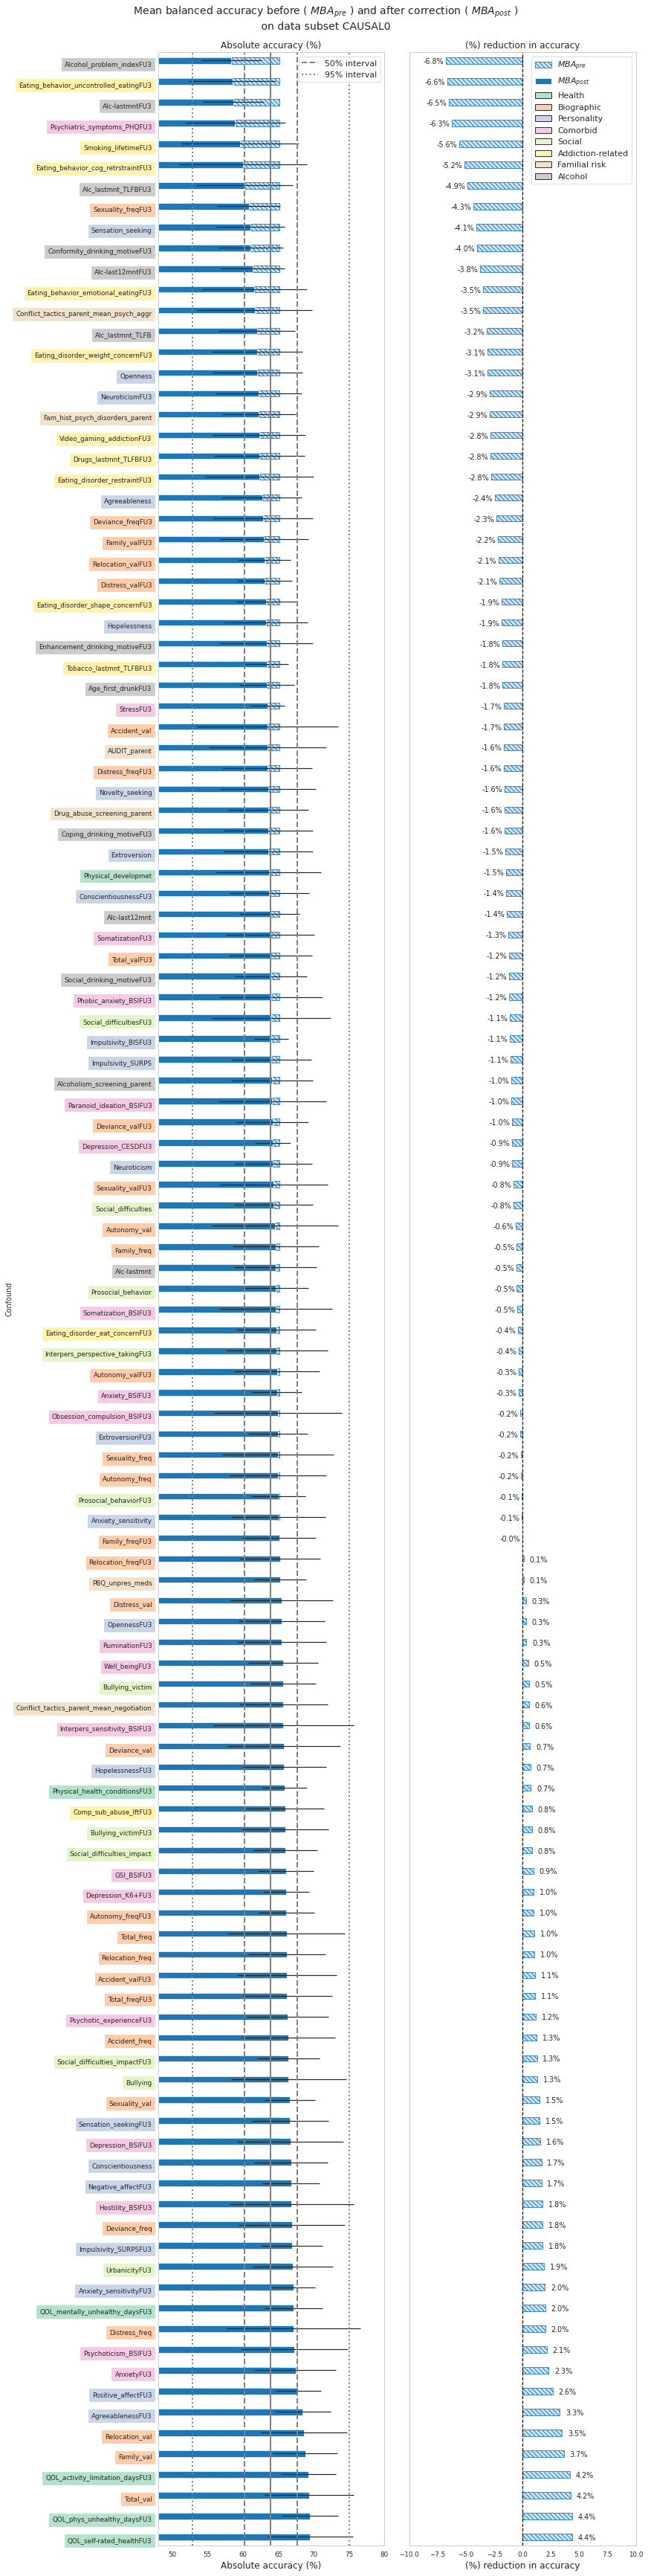

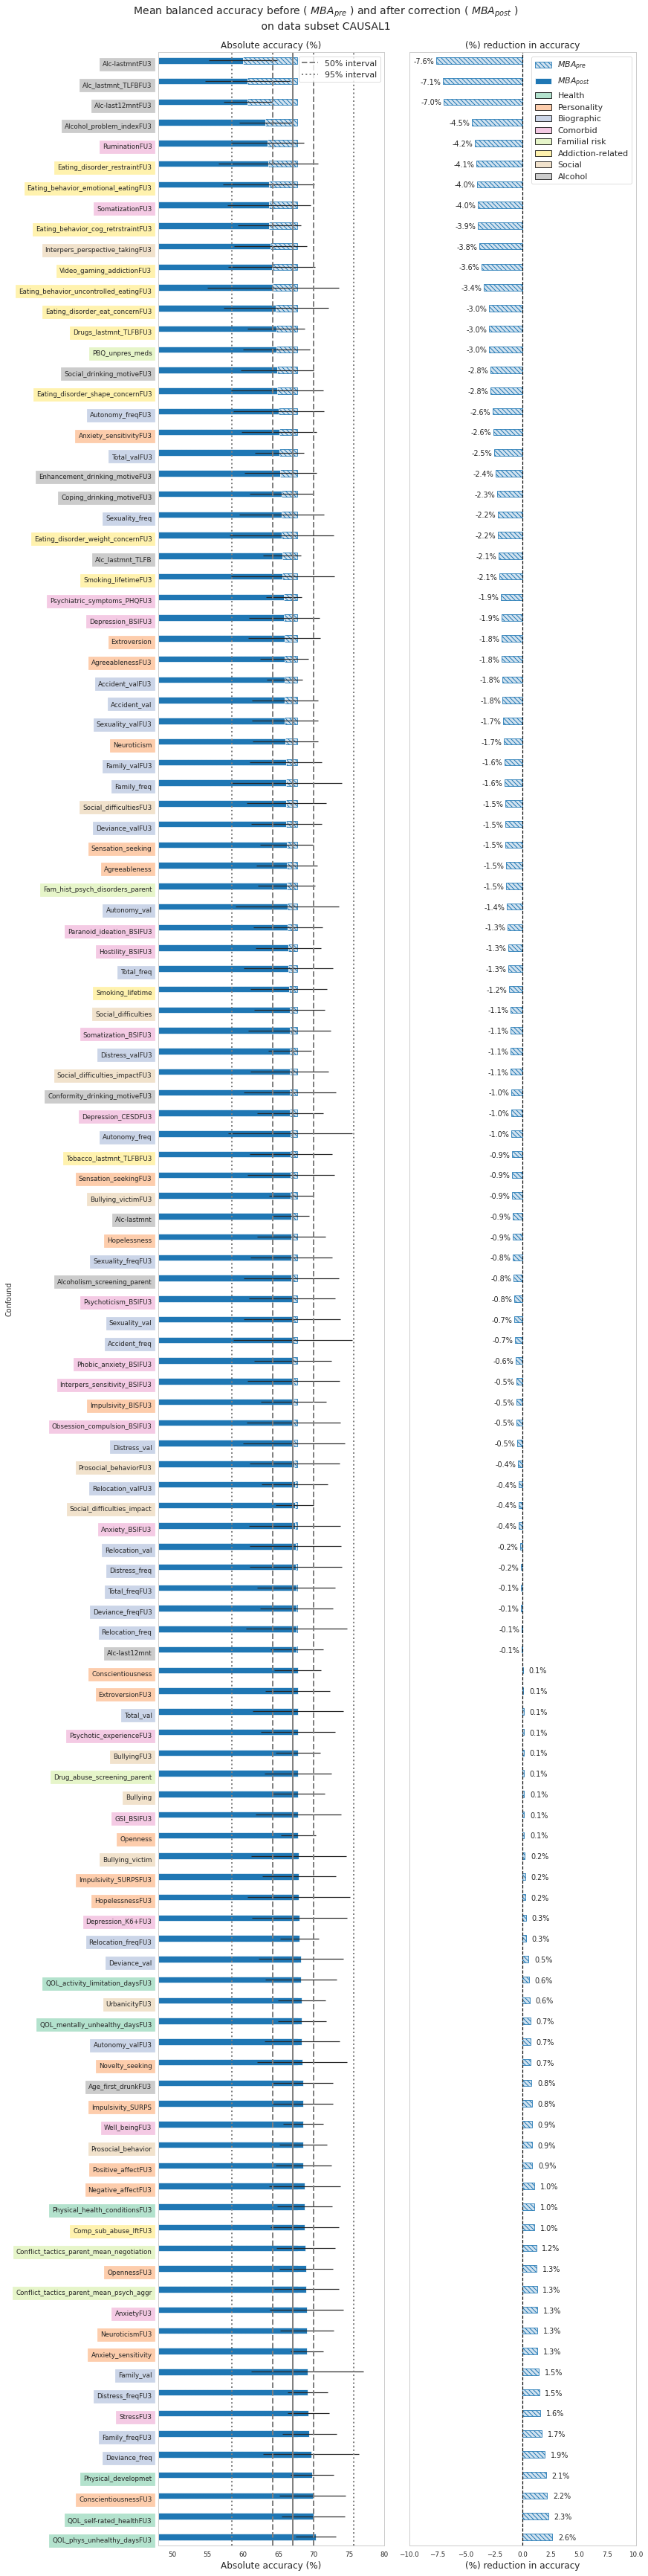

In [24]:
# plot results
for h5_name, dfi in all_df.items():
    
    plot_accuracy_csv(dfi, color_cat=True, 
                      permutation_results=f"results/{h5_name}_permutation_results.json"
                     )
    plt.savefig(f"results/results-{h5_name}.jpg", bbox_inches='tight')
    plt.show()
    # break

### Explorative results summary plot

In [25]:
df_all = pd.DataFrame()
for h5_name, dfi in all_df.items():
    dfi = dfi.sort_values(['category','Confound'])
    dfi['abs_diff'] = dfi['Accuracy Diff CB - BL'].apply(abs)
    for c in ['Accuracy BL',
       'Std-Dev BL', 'Accuracy CB', 'Std-Dev CB', 'Accuracy Diff CB - BL',
       'Std-Dev Diff CB - BL','abs_diff']:
        dfi[c] *= 100
    # calculate ranks
    dfi['rank'] = np.nan
    for h5_i, df_h5_i in dfi.groupby("h5cat"):
        df_h5_i = df_h5_i.sort_values('Accuracy Diff CB - BL')
        dfi.loc[df_h5_i.index, ['rank']] = np.arange(len(df_h5_i))
    assert dfi['rank'].isna().any() != True
    df_all = df_all.append(dfi)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 75 to 195
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Confound               241 non-null    object 
 1   Conf_time_point        241 non-null    object 
 2   Model                  241 non-null    object 
 3   h5name                 241 non-null    object 
 4   Accuracy BL            241 non-null    float64
 5   Std-Dev BL             241 non-null    float64
 6   Accuracy CB            241 non-null    float64
 7   Std-Dev CB             241 non-null    float64
 8   Accuracy Diff CB - BL  241 non-null    float64
 9   Std-Dev Diff CB - BL   241 non-null    float64
 10  h5cat                  241 non-null    object 
 11  category               241 non-null    object 
 12  abs_diff               241 non-null    float64
 13  rank                   241 non-null    int64  
dtypes: float64(7), int64(1), object(6)
memory usage: 28.2+ KB

In [26]:

mean = df_all["Accuracy Diff CB - BL"].mean()
std_dev =  df_all["Accuracy Diff CB - BL"].std()
print(f"Thresholds for (mean-1.282*std_dev, mean-1.036*std_dev, mean-1.0*std_dev, mean, mean+1.0*std_dev, mean+1.036*std_dev, mean+1.282*std_dev)= \n\
({mean-1.282*std_dev:.10f}, {mean-1.036*std_dev:.10f}, {mean-1.0*std_dev:.10f}, {mean:.10f}, {mean+1.0*std_dev:.10f}, {mean+1.036*std_dev:.10f}, {mean+1.282*std_dev:.10f}, )")


upper_threshold = mean+1.036*std_dev
lower_threshold = mean-1.036*std_dev

Thresholds for (mean-1.282*std_dev, mean-1.036*std_dev, mean-1.0*std_dev, mean, mean+1.0*std_dev, mean+1.036*std_dev, mean+1.282*std_dev)= 
(-3.4337181679, -2.9153173773, -2.8394538469, -0.7321335599, 1.3751867272, 1.4510502575, 1.9694510481, )


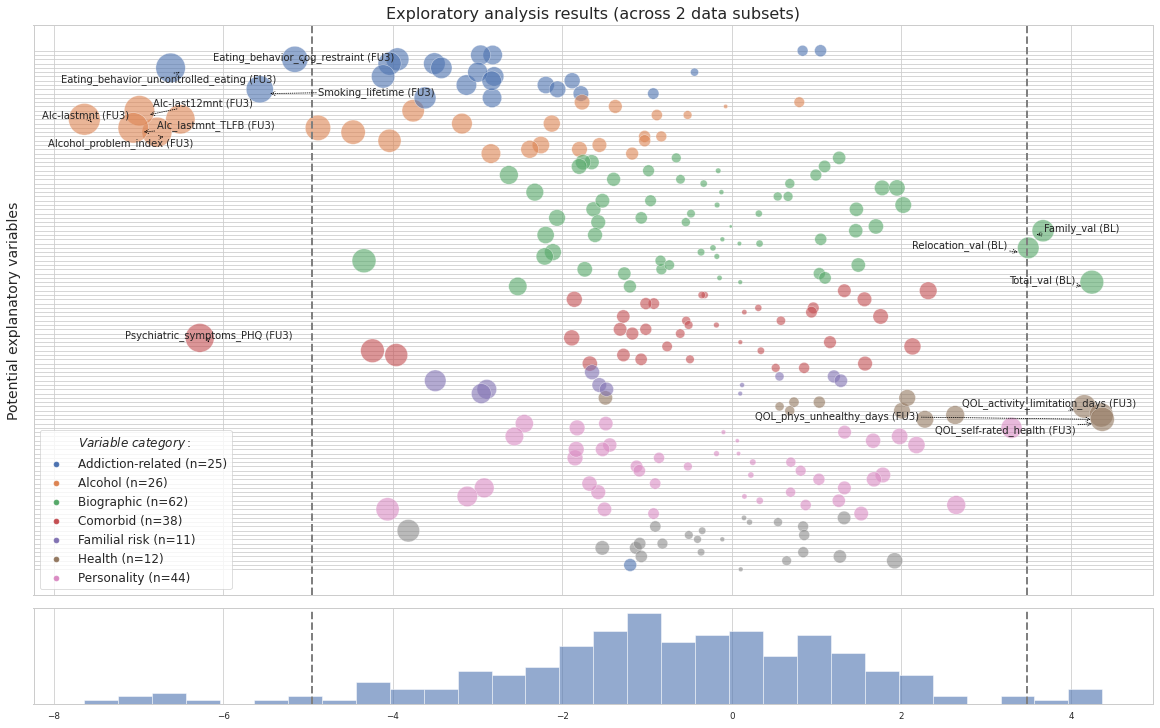

In [29]:
from adjustText import adjust_text
fig, axes = plt.subplots(nrows=2, figsize=(16,10), 
                         sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [6, 1]})


# distribution of the values to determine the threshold first
ax = axes[1]
ax.hist(df_all["Accuracy Diff CB - BL"], bins=30, alpha=0.6)
ax.set_yticks([])

ax.axvline(upper_threshold, ls='--', lw=2, c='gray')
ax.axvline(lower_threshold, ls='--', lw=2, c='gray')
# also add the lines to the previous axis
axes[0].axvline(upper_threshold, ls='--', lw=2, c='gray')
axes[0].axvline(lower_threshold, ls='--', lw=2, c='gray')

ax =axes[0]

g = sns.scatterplot(
            data=df_all,
            x="Accuracy Diff CB - BL", y="Confound", 
            hue="category", palette="deep", 
            # style="Model", markers={"SVM-rbf": "o", "GB": "D"}, ## @remove GB
            size="abs_diff", sizes=(10, 1000),
            ax=ax,# col='h5cat',
            alpha=.6)
fs=14 # fontsize
g.set_yticklabels([])
g.set_xlabel(r"Difference in Mean Balanced Accuracy ( $MBA_{post} - MBA_{pre}$ )", fontdict={'fontsize':fs})
g.set_ylabel("Potential explanatory variables", fontdict={'fontsize':fs})
g.set_title(f"Exploratory analysis results (across 2 data subsets)",
           fontdict={'fontsize':fs+2})
 
# filter out points that have large difference of either [-3% or +2%] for both models
points = g.collections[0]
points_to_show = {} # first store {point: model}
for i, point in enumerate(points.get_offsets()):
    point_info = df_all.iloc[i]
    var = point_info.Confound
    var_val = point_info['Accuracy Diff CB - BL']
    if (var_val<=lower_threshold or var_val>=upper_threshold): 
        if var not in points_to_show:
            points_to_show.update({var: (point,1)})
        else: #  (var in points_to_show)
            old_pt, old_cnt = points_to_show[var]
            # if a var is already there then only upddate the new point if
            # it has caused a greater reduction in accuracy than the existing one
            if (abs(var_val) > abs(old_pt[0])):
                points_to_show.update({var: (point, old_cnt+1)})
            else:
                points_to_show.update({var+'_2': (point, old_cnt+1)})
                
            
# annotate the points on the figure
texts = []
for var, (point, w) in points_to_show.items():
    # print(var, w)
    sign = 1 if point[0]>=0 else -1
    ha = 'left' if sign>0 else 'right'
    var_corr = var.replace('FU3', ' (FU3)') if 'FU3' in var else var+' (BL)'
    # if it occurs in both data subsets then show a higher font size
    if var not in []: # manually exclude some annotation which are not informative
        size = (fs-2) if var in [SELECTED_TOP_VARS, SELECTED_WRST_VARS] else (fs-4) #'bold' if w>1 else 
        txt = (g.text(point[0]-sign*0.1, point[1]+1, #texts.append
                     var_corr.replace('retrstraint', 'restraint'),  # var name corrections
                    horizontalalignment=ha, size=size)) # increase boldness of annotation if it occurs many times
        texts.append(txt)
adjust_text(texts, autoalign='y', ax=axes[0],
           arrowprops=dict(arrowstyle='->', color='k', ls=':',lw=0.8)
           )
        
# prepare the legend
n_cats = df_all.category.nunique()
hdls, lbls = g.get_legend_handles_labels()
hdls = hdls[:n_cats]
lbls = lbls[1:n_cats]
# append the number of instances in each category
lbls = [f"{lbl} (n={(df_all.category==lbl).sum()})" for lbl in lbls]
# todo  in legend of category add number of points
lbl_title = r"$\it{Variable}$ $\it{category}:$"
ax.legend(hdls, 
          [lbl_title]+lbls,
          loc='lower left', fontsize=fs-2)
            

plt.savefig(f"results/results-scatter-combined.jpg", bbox_inches='tight')
plt.show()

Thresholds for (mean-2.0*std_dev, mean-1.0*std_dev, mean, mean+1.0*std_dev, mean+2.0*std_dev)= 
(-4.95, -2.84, -0.73, 1.38, 3.48


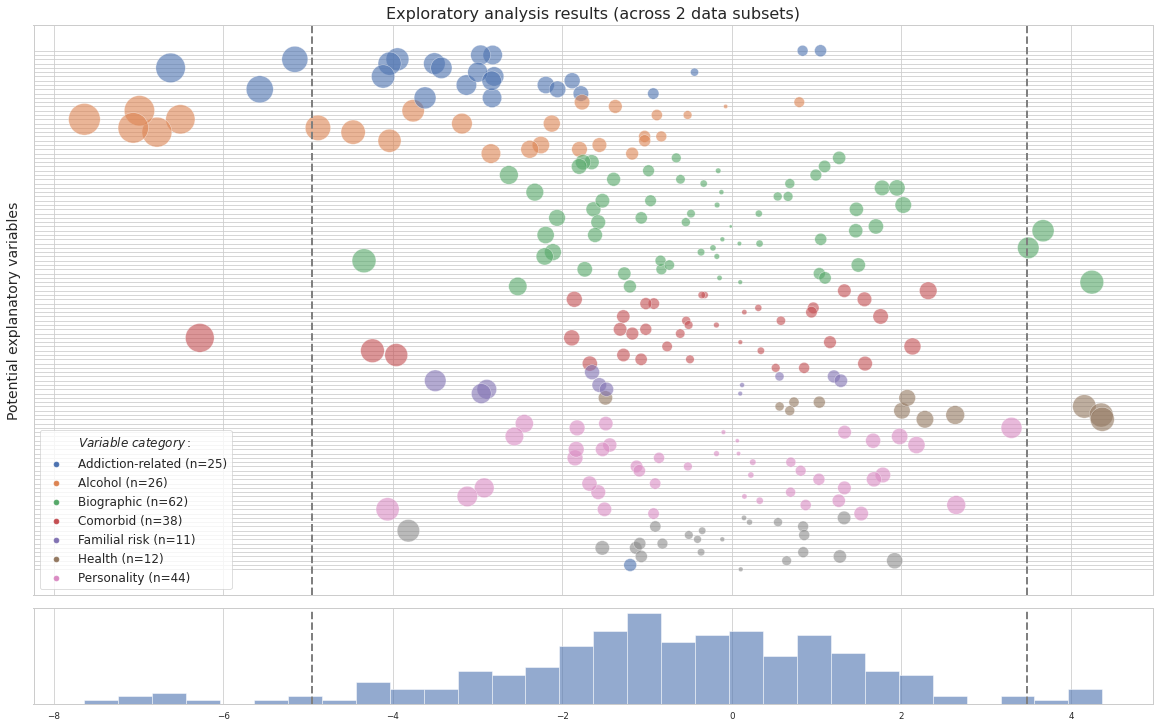

In [30]:
from adjustText import adjust_text
fig, axes = plt.subplots(nrows=2, figsize=(16,10), 
                         sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [6, 1]})


# distribution of the values to determine the threshold first
ax = axes[1]
ax.hist(df_all["Accuracy Diff CB - BL"], bins=30, alpha=0.6)
ax.set_yticks([])
mean = df_all["Accuracy Diff CB - BL"].mean()
std_dev =  df_all["Accuracy Diff CB - BL"].std()
print(f"Thresholds for (mean-2.0*std_dev, mean-1.0*std_dev, mean, mean+1.0*std_dev, mean+2.0*std_dev)= \n\
({mean-2.0*std_dev:.2f}, {mean-1.0*std_dev:.2f}, {mean:.2f}, {mean+1.0*std_dev:.2f}, {mean+2.0*std_dev:.2f}")
upper_threshold = mean+2.0*std_dev
lower_threshold = mean-2.0*std_dev
ax.axvline(upper_threshold, ls='--', lw=2, c='gray')
ax.axvline(lower_threshold, ls='--', lw=2, c='gray')
# also add the lines to the previous axis
axes[0].axvline(upper_threshold, ls='--', lw=2, c='gray')
axes[0].axvline(lower_threshold, ls='--', lw=2, c='gray')

ax =axes[0]

g = sns.scatterplot(
            data=df_all,
            x="Accuracy Diff CB - BL", y="Confound", 
            hue="category", palette="deep", 
            # style="Model", markers={"SVM-rbf": "o", "GB": "D"}, ## @remove GB
            size="abs_diff", sizes=(10, 1000),
            ax=ax,# col='h5cat',
            alpha=.6)
fs=14 # fontsize
g.set_yticklabels([])
g.set_xlabel(r"Difference in Mean Balanced Accuracy ( $MBA_{post} - MBA_{pre}$ )", fontdict={'fontsize':fs})
g.set_ylabel("Potential explanatory variables", fontdict={'fontsize':fs})
g.set_title(f"Exploratory analysis results (across 2 data subsets)",
           fontdict={'fontsize':fs+2})
 
# filter out points that have large difference of either [-3% or +2%] for both models
points = g.collections[0]
points_to_show = {} # first store {point: model}
for i, point in enumerate(points.get_offsets()):
    point_info = df_all.iloc[i]
    var = point_info.Confound
    var_val = point_info['Accuracy Diff CB - BL']
    if (var_val<=lower_threshold or var_val>=upper_threshold): 
        if var not in points_to_show:
            points_to_show.update({var: (point,1)})
        else: #  (var in points_to_show)
            old_pt, old_cnt = points_to_show[var]
            # if a var is already there then only upddate the new point if
            # it has caused a greater reduction in accuracy than the existing one
            if (abs(var_val) > abs(old_pt[0])):
                points_to_show.update({var: (point, old_cnt+1)})
            else:
                points_to_show.update({var: (old_pt, old_cnt+1)})
                
            
# annotate the points on the figure
# texts = []
# for var, (point, w) in points_to_show.items():
#     # print(var, w)
#     sign = 1 if point[0]>=0 else -1
#     ha = 'left' if sign>0 else 'right'
#     var_corr = var.replace('FU3', ' (FU3)') if 'FU3' in var else var+' (BL)'
#     # if it occurs in both data subsets then show a higher font size
#     if var not in []: # manually exclude some annotation which are not informative
#         size = (fs-2) if var in SELECTED_VARS else (fs-4) #'bold' if w>1 else 
#         txt = (g.text(point[0]-sign*0.1, point[1]+1, #texts.append
#                      var_corr.replace('retrstraint', 'restraint'),  # var name corrections
#                     horizontalalignment=ha, size=size)) # increase boldness of annotation if it occurs many times
#         texts.append(txt)
# adjust_text(texts, autoalign='y',
#            arrowprops=dict(arrowstyle='->', color='k', ls=':',lw=0.8)
#            )
        
# prepare the legend
n_cats = df_all.category.nunique()
hdls, lbls = g.get_legend_handles_labels()
hdls = hdls[:n_cats]
lbls = lbls[1:n_cats]
# append the number of instances in each category
lbls = [f"{lbl} (n={(df_all.category==lbl).sum()})" for lbl in lbls]
# todo  in legend of category add number of points
lbl_title = r"$\it{Variable}$ $\it{category}:$"
ax.legend(hdls, 
          [lbl_title]+lbls,
          loc='lower left', fontsize=fs-2)
            

plt.savefig(f"results/results-scatter-combined.jpg", bbox_inches='tight')
plt.show()

In [31]:
print("# points that crossed the threshold above: try other less conservative thresholds")
for var, (values, cnts) in points_to_show.items(): 
    print(f"{var} appeared {cnts} times. Best value {values[0]:.2f}")

# points that crossed the threshold above: try other less conservative thresholds
Eating_behavior_cog_retrstraintFU3 appeared 1 times. Best value -5.15
Eating_behavior_uncontrolled_eatingFU3 appeared 1 times. Best value -6.62
Smoking_lifetimeFU3 appeared 1 times. Best value -5.57
Alc-lastmntFU3 appeared 2 times. Best value -7.64
Alcohol_problem_indexFU3 appeared 1 times. Best value -6.78
Family_val appeared 1 times. Best value 3.67
Relocation_val appeared 1 times. Best value 3.50
Total_val appeared 1 times. Best value 4.24
Psychiatric_symptoms_PHQFU3 appeared 1 times. Best value -6.28
QOL_activity_limitation_daysFU3 appeared 1 times. Best value 4.16
QOL_phys_unhealthy_daysFU3 appeared 1 times. Best value 4.36
QOL_self-rated_healthFU3 appeared 1 times. Best value 4.37
Alc-last12mntFU3 appeared 1 times. Best value -6.99
Alc_lastmnt_TLFBFU3 appeared 1 times. Best value -7.06


### Exploratory stage conclusions

Out of the 20 variables, the following variables are highly correlated and/or capture the same information:
1. ~'Eating_behavior_cog_retrstraintFU3'~,~'Eating_behavior_emotional_eatingFU3'~, 'Eating_behavior_uncontrolled_eatingFU3': Highly correlated and related
2. 'Alc_lastmnt_TLFBFU3', ~Alc-last12mntFU3~, ~Alc-lastmntFU3~: Capture same information
3. 'Conflict_tactics_parent_mean_psych_aggr', 'Conformity_drinking_motiveFU3', 'Eating_disorder_weight_concernFU3',~'Alc_lastmnt_TLFB'~ : _highly correlated_
3. ~'Family_val'~, 'Sensation_seeking' ~'Total_val'~, ~'Smoking_lifetimeFU3'~: Highly correlated
4. 'Psychiatric_symptoms_PHQFU3' highly correlated with 'Alc_lastmnt_TLFBFU3'. Seems like this variable is random and will get eliminated
5. 'QOL_activity_limitation_daysFU3': Doesn't correlate with any non-alc variable

[TODO] @Milena derive more insights

Therefore, we can use the following variables for generalization test: 
1. Alc_lastmnt_TLFBFU3: A sanity check using another alcohol use metrics at FU3
2. Eating_behavior_uncontrolled_eatingFU3: Eating behavior at FU3
3. Quality of life at FU3

[TODO] @Milena choose a maximum of 5 variables. The scratched out variables are my suggestions to exclude.

In [32]:
SELECTED_VARS = ['Alc-lastmntFU3', 
                 'Alcohol_problem_indexFU3',
                 'Eating_behavior_uncontrolled_eatingFU3', 
                 'QOL_phys_unhealthy_daysFU3']

In [33]:
SELECTED_VARS

['Alc-lastmntFU3',
 'Alcohol_problem_indexFU3',
 'Eating_behavior_uncontrolled_eatingFU3',
 'QOL_phys_unhealthy_daysFU3']

#### Save the final selected vars as a table

In [34]:
df_all_i = df_all.groupby('Model').get_group('SVM-rbf')
df_exp_selected = df_all_i[df_all_i.Confound.isin(SELECTED_VARS)]
# save in a file
df_exp_selected.to_csv("results/results_explorative_selected_confs.csv")

#### Correlation analysis
Among the selected variables, remove variables that are highly correlated and capture the same/similar information

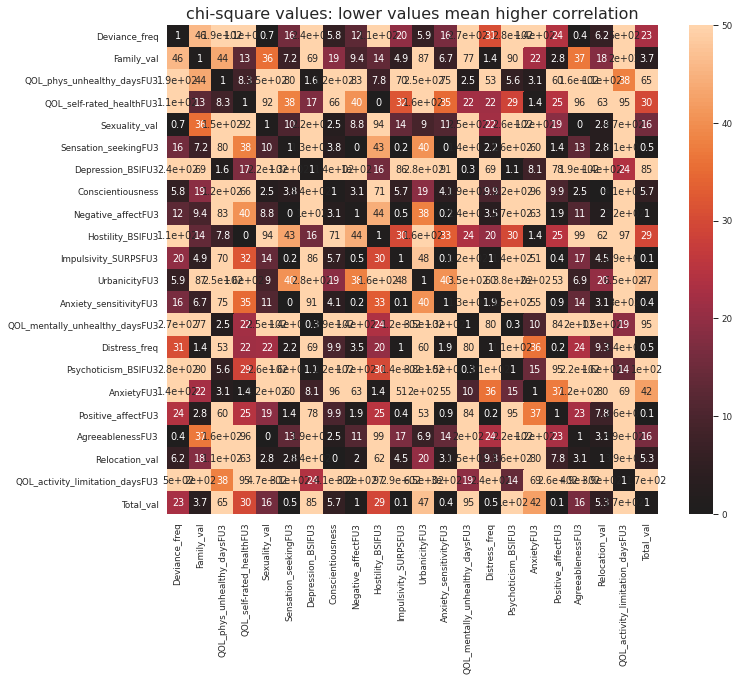

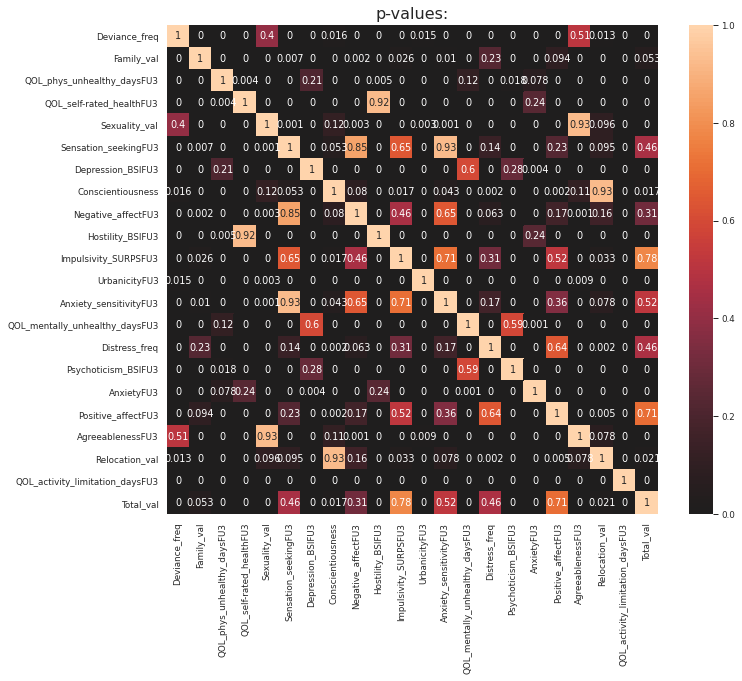

In [36]:
all_posthoc_h5s = glob(H5_DIR+"/posthoc-cc2-h5causal0-*.h5")
# get the variable's values
with h5py.File(H5_DIR+H5_FILES['h5bl'], 'r') as f:
    ids = f['i'][:]
df_var_vals = pd.DataFrame(index=ids)

for var in SELECTED_WRST_VARS + SKIPPED_WRST_VARS:
    h5 = [h5 for h5 in all_posthoc_h5s if var in h5]
    if len(h5)==2 and 'FU3' not in var:
        h5 = [h5_i for h5_i in h5 if 'FU3' not in h5_i]
    assert len(h5)==1, f"For var = {var}, too many h5files were found = {h5}"
    with h5py.File(h5[0], 'r') as f:
        var_val = pd.Series(data=f[var][:], index=f['i'][:])
        df_var_vals[var] = var_val

# calculate correlation between all binary variables
def chi_sq(var_a, var_b):
    _, var_a_cnts = np.unique(var_a, return_counts=True)
    _, var_b_cnts = np.unique(var_b, return_counts=True)
    chi, p = stats.chisquare(var_a_cnts, var_b_cnts)
    return float(f"{chi:0.1f}")
def chi_sq_p(var_a, var_b):
    _, var_a_cnts = np.unique(var_a, return_counts=True)
    _, var_b_cnts = np.unique(var_b, return_counts=True)
    chi, p = stats.chisquare(var_a_cnts, var_b_cnts)
    return float(f"{p:0.3f}")
    
corr = df_var_vals.corr(chi_sq)
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, center=0, vmax=50, 
            annot=True)
plt.title("chi-square values: lower values mean higher correlation", fontsize=16)
plt.show()

## PLOT the p values
corr = df_var_vals.corr(chi_sq_p)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, center=0, 
            annot=True)
plt.title("p-values:", fontsize=16)
plt.show()

## Generalization tests
Do the results generalize to test data? - repeat on holdout data

### Create holdout h5files
Create holdout h5 file for BL, BLcausal1 and BLcausal0 with all confs in it

In [29]:
plot_dist = False
print_all = False

In [30]:
df_conf_list = pd.read_excel("Confounds_list_Milena_v3.xlsx")

# get list of holdout subject IDs
df_participants = pd.read_csv(f"/ritter/share/data/IMAGEN/IMAGEN_BIDS/participants_BL.csv", index_col="ID")
df_participants = df_participants[df_participants['holdout']]

all_confs = pd.DataFrame(index=df_participants.index)

for i,row in df_conf_list.iterrows():
    print(f"-------------------  ({i}) {row['conf_name']}   ----------------------")
    # load the confound from corresponding questionnaire as a pandas Series
    # print(f"From {CONF_DATA_DIR+row['questionnaire']} reading column '{row['colname']}'")
    if '???' in row["questionnaire"] or '???' in row["colname"]:
        print(f"[ERROR] {row['conf_name']} missing preprocessed tables. Extract this first.")
        continue

    if 'FU' in h5_name.upper() and ('FU' not in row['time_point'].upper()) and row['subject']!='parent':
        print(f"Skipping this conf since it is not applicable for FUx timepoint analysis")
        continue

    df_conf = pd.read_csv(CONF_DATA_DIR + row["questionnaire"]).set_index('ID')

    if ('Session' in df_conf):
        conf = df_conf.loc[df_conf['Session']==row['time_point'], row['colname']] 
        if print_all: print(f"Using Q collected at session-{row['time_point']}")
    elif ('Session' in df_conf and df_conf['Session'].nunique()>1):
        conf = df_conf.loc[df_conf['Session']=='FU3', row['colname']] 
        if print_all: print(f"Using Q collected at session-FU3")
    else:
        conf = df_conf[row['colname']]
        if print_all: print(f"Using Q collected at session-???")

    # attach the timepoint to the name if it is not BL 
    conf.name = row['conf_name']
    if row['time_point'] != 'BL': 
        conf.name += row['time_point']

    # filter out only holdout sub IDs
    all_confs[conf.name] = conf
    conf = all_confs[conf.name]

    # impute missing values with given value
    if conf.isna().sum() and isinstance(row['impute_missing_with'], (int,float)):
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing values with {row['impute_missing_with']}")
        conf = conf.fillna(row['impute_missing_with'])
    elif conf.isna().sum():
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing with K-Nearest-Neighbour algorithm")
        # use KNN
        conf.loc[:] = KNNImputer().fit_transform(conf.values.reshape(-1, 1)).ravel()

    # plot conf distribution before binarizing
    if plot_dist:
        f, axes = plt.subplots(1,2, figsize=(7,3), sharey=False)
        plt.suptitle(f"{row['category']}: {conf.name.title()}")

        kwargs = dict(ax=axes[0],
            title="before binarizing", 
            xlabel='values', ylabel='counts')

        nunique = conf.nunique()

        conf.plot(
            kind='hist', bins=10 if nunique<100 else nunique//10,
            **kwargs)

        if print_all: print(
            f"range (min, mean, median, max) = ({conf.min():.2f}, {conf.mean():.2f}, {conf.median():.2f}, {conf.max():.2f})")

    # binarize 
    binarizing_threshold = conf.median() if row['binarizing_threshold']=='median' else conf.mean()
    conf = conf.apply(lambda x: int(x>binarizing_threshold))


    # plot conf distribution after binarizing
    if plot_dist:
        # draw the threshold in the prev plot
        axes[0].axvline(binarizing_threshold, c='k', ls='--', lw=2, label='binarizing threshold')
        hdls, lbls = axes[0].get_legend_handles_labels()
        axes[0].legend([hdls[0]], ['binarizing threshold={:.2f}'.format(binarizing_threshold)])

        colors = [plt.get_cmap("tab10")(v) for v in sorted(conf.unique())]
        conf.value_counts(dropna=False).sort_index().plot(
            ax=axes[1], kind='bar',
            title="after binarizing", 
            xlabel='values', ylabel='counts', color=colors)
        plt.tight_layout()
        plt.show()


    # resave confounds
    all_confs[conf.name] = conf

all_confs

-------------------  (0) Alc-lastmnt   ----------------------
-------------------  (1) Alc-last12mnt   ----------------------
-------------------  (2) Neuroticism   ----------------------
-------------------  (3) Extroversion   ----------------------
-------------------  (4) Conscientiousness   ----------------------
-------------------  (5) Openness   ----------------------
-------------------  (6) Agreeableness   ----------------------
-------------------  (7) Family_freq   ----------------------
-------------------  (8) Family_val   ----------------------
-------------------  (9) Accident_freq   ----------------------
-------------------  (10) Accident_val   ----------------------
-------------------  (11) Sexuality_freq   ----------------------
-------------------  (12) Sexuality_val   ----------------------
-------------------  (13) Autonomy_freq   ----------------------
-------------------  (14) Autonomy_val   ----------------------
-------------------  (15) Deviance_freq   -----

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


-------------------  (102) Family_freq   ----------------------
-------------------  (103) Family_val   ----------------------
-------------------  (104) Accident_freq   ----------------------
-------------------  (105) Accident_val   ----------------------
-------------------  (106) Sexuality_freq   ----------------------
-------------------  (107) Sexuality_val   ----------------------
-------------------  (108) Autonomy_freq   ----------------------
-------------------  (109) Autonomy_val   ----------------------
-------------------  (110) Deviance_freq   ----------------------
-------------------  (111) Deviance_val   ----------------------
-------------------  (112) Relocation_freq   ----------------------
-------------------  (113) Relocation_val   ----------------------
-------------------  (114) Distress_freq   ----------------------
-------------------  (115) Distress_val   ----------------------
-------------------  (116) Total_freq   ----------------------
------------------

Alc-lastmnt  Alc-last12mnt  Neuroticism  Extroversion  \
ID                                                                
240546              0              0            0             1   
1163495             0              0            0             0   
1938036             1              1            0             1   
2103894             0              0            0             0   
2766073             1              1            1             1   
...               ...            ...          ...           ...   
98671905            1              1            1             1   
99217838            0              0            0             1   
99677574            0              0            0             1   
99875982            0              0            1             1   
99954902            0              0            1             0   

          Conscientiousness  Openness  Agreeableness  Family_freq  Family_val  \
ID                                                                              
240546                    0         1              1            0           0   
1163495                   1         0              1            0           1   
1938036                   0         1              1            1           1   
2103894                   0         1              1            1           0   
2766073                   0         1              1            0           0   
...                     ...       ...            ...          ...         ...   
98671905                  0         1              1            1           1   
99217838                  0         1              0            0           0   
99677574                  1         0              1            0           0   
99875982                  0         1              0            0           0   
99954902                  1         1              1            0           0   

          Accident_freq  ...  Conflict_tactics_parent_mean_negotiation  \
ID                       ...                                             
240546                1  ...                                         1   
1163495               0  ...                                         0   
1938036               1  ...                                         1   
2103894               1  ...                                         1   
2766073               1  ...                                         0   
...                 ...  ...                                       ...   
98671905              1  ...                                         0   
99217838              1  ...                                         1   
99677574              1  ...                                         0   
99875982              1  ...                                         0   
99954902              1  ...                                         1   

          Conflict_tactics_parent_mean_psych_aggr  \
ID                                                  
240546                                          0   
1163495                                         0   
1938036                                         1   
2103894                                         0   
2766073                                         0   
...                                           ...   
98671905                                        0   
99217838                                        0   
99677574                                        0   
99875982                                        0   
99954902                                        0   

          Conflict_tactics_parent_sexual_coercion  \
ID                                                  
240546                                          0   
1163495                                         0   
1938036                                         0   
2103894                                         0   
2766073                                         0   
...                                           ...   
9867190

In [31]:
# add binge itself as a conf
def attach_conf_from_df(H5_DIR, to_h5, conf_table, prepend='h5causal1-allconfs', print_all=True):
    
    conf_table = conf_table.sort_index()
    
    # create a new h5 file name
    out_h5 = '-'.join(['posthoc-cc2',prepend])+'.h5'
    if print_all: print("writing to ..", out_h5)
    assert not os.path.exists(H5_DIR+out_h5), "[ERROR] file already exists.. skipping h5file creation. Remove it manually first"

    with h5py.File(H5_DIR+out_h5, 'w') as data_out:
        # first just copy all h5 file data to new h5 file    
        with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
            for dataset in data_dest:
                data_out.create_dataset(dataset, data=data_dest[dataset]) 
            for attr in data_dest.attrs:
                data_out.attrs[attr]=data_dest.attrs[attr]

        for conf_name, conf in conf_table.items():
                # now add the confound
                if conf_name not in data_out.attrs['confs']:

                    if print_all: print(f"attaching conf {conf_name}")
                    data_out.attrs['confs'] = list(data_out.attrs['confs'])+[conf_name]
                    # align the subject IDs to fill the right conf value for each subject in the h5
                    h5_sub_ids = data_out['i'][:]
                    # below script works only if the IDs in src data h5 are arranged in an ascending order
                    assert np.all(h5_sub_ids[:-1] <= h5_sub_ids[1:]), f"subject IDs in {to_h5} are not in ascending order.. change the algo below ?!"
                    conf = conf.sort_index()
                    h5_sub_ids_in_conf = np.argwhere(np.isin(h5_sub_ids, conf.index)).ravel()
                    conf_sub_ids_in_h5 = np.argwhere(np.isin(conf.index, h5_sub_ids)).ravel()
                    assert len(h5_sub_ids_in_conf)==len(conf_sub_ids_in_h5)
                    data_out.create_dataset(conf_name, data=conf.iloc[conf_sub_ids_in_h5]) 
                
                    # check if the distribution of confound is acceptable
                    if not conf.iloc[conf_sub_ids_in_h5].nunique()==2:
                        print(f"[ERROR] Failed to create h5: conf '{conf_name}' has n_classes= \
{conf.iloc[conf_sub_ids_in_h5].nunique()}. If n_classes>2 then it was not correctly\
binarized. If n_classes=1 then all subjects are getting categorized into a single class.")
                        continue
                              
                    for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():
                        if not counts>=0.15*len(conf_sub_ids_in_h5):
                            print(f"[ERROR] Failed to create h5: the value {val} in {conf_name}\
has fewer than 15% instances (n={counts})\nThis is very small for counter balancing to work properly..")
                            continue

                    # remove subject IDs missing the conf info
                    if len(h5_sub_ids_in_conf)<len(h5_sub_ids):

                        print(f"[WARN] n={len(h5_sub_ids)-len(h5_sub_ids_in_conf)} subs missing this conf information. \
    Dropping sample size from {len(h5_sub_ids)} to {len(h5_sub_ids_in_conf)}")
                        existing_datasets = list(data_out.keys())
                        existing_datasets.remove(conf_name)
                        # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                        for existing_dataset in existing_datasets:
                            new_data = data_out[existing_dataset][h5_sub_ids_in_conf] 
                            del data_out[existing_dataset] 
                            data_out.create_dataset(existing_dataset, data=new_data) 

In [ ]:
h5_names = ['h5bl', 'h5causal0', 'h5causal1']#, 'h5fu3', 'h5bl'
for h5_name in h5_names:
    h5_src_hold = H5_FILES_HOLD[h5_name] 
    # attach conf to the h5 file
    attach_conf_from_df(H5_DIR, h5_src_hold, conf_table=all_confs, prepend='holdout-'+h5_name, print_all=print_all)


In [64]:
hold_h5s = glob(H5_DIR+"/posthoc-cc2-holdout*.h5")
hold_h5s

['/ritter/share/data/IMAGEN/h5files/posthoc-cc2-holdout-h5causal1.h5',
 '/ritter/share/data/IMAGEN/h5files/posthoc-cc2-holdout-h5causal0.h5',
 '/ritter/share/data/IMAGEN/h5files/posthoc-cc2-holdout-h5bl.h5']

______________________________________________________________________________________
filename: posthoc-cc2-h5bl-Eating_disorder_weight_concernFU3.h5 
 h5.columns = ['Binge', 'Eating_disorder_weight_concernFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 553 	 label = Binge 	 X.shape = (553, 719)  	 confs = ['sex', 'site', 'Eating_disorder_weight_concernFU3']
label and conf with distributions:


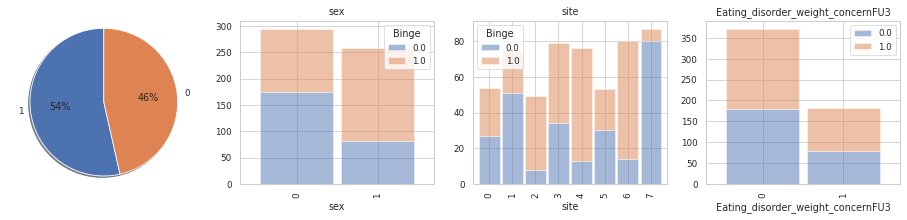


subject: 13148228 	 (min=0.00, mean=17798.66, max=1591918.00)
conf Eating_disorder_weight_concernFU3 == label Binge ? 	 True for n=282/553


In [75]:
check_h5_contents(["/ritter/share/data/IMAGEN/h5files/posthoc-cc2-h5bl-Eating_disorder_weight_concernFU3.h5"])

In [112]:
# ! ls ../MLpipelines/results/posthoc-cc2-h5bl-*/*/run.csv | wc -l

### Holdout conf-permute tests


for difference: (a) random conf distribution vs our confs (b) 1 sample t-test comparing the 7-fold accuracies before controlling for confound $C$ vs after controlling $C$. -> do significance tests on the holdout data


------------------------------
bl
------------------------------
mean: [70.58% - 70.58%]
50% interval: [69.13% - 72.04%]
75% interval: [68.10% - 73.07%]
95% interval: [66.26% - 74.91%]
------------------------------
causal1
------------------------------
mean: [66.64% - 66.64%]
50% interval: [65.10% - 68.19%]
75% interval: [64.00% - 69.28%]
95% interval: [62.06% - 71.22%]
------------------------------
causal0
------------------------------
mean: [67.91% - 67.91%]
50% interval: [66.05% - 69.77%]
75% interval: [64.74% - 71.09%]
95% interval: [62.39% - 73.43%]


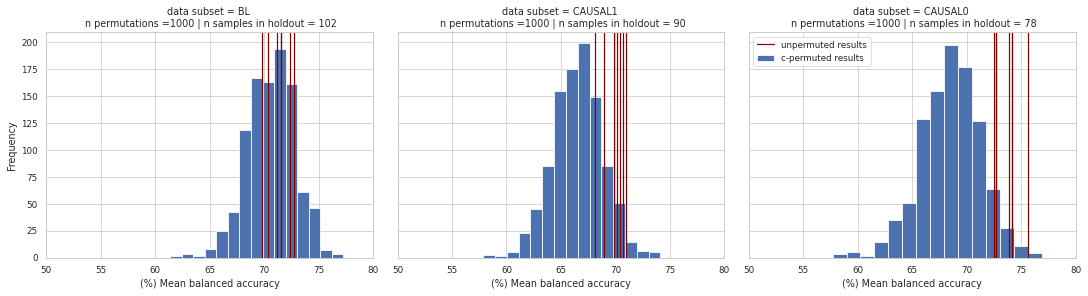

In [37]:
df = pd.read_csv(RESULTS_DIR + "holdout-posthoc-cc2-permuted_run.csv")

f, axes = plt.subplots(1,3, figsize=(15,4),
                       sharey=True, sharex=True,
                       constrained_layout=True)

for i, (cat, dfi) in enumerate(df.groupby('h5cat', sort=False)):
    ax = axes[i]
    print(f"{'-'*30}\n{cat}\n{'-'*30}")
    # draw the original results as lines
    unpermuted_results = pd.read_csv(MAP_H5CAT_TO_HOLDRUN['h5'+cat])
    unpermuted_results = unpermuted_results[(unpermuted_results.tp == 'bl') & (unpermuted_results.model == 'SVM-rbf')]
    unpermuted_results.holdout_score *= 100
    for old_score in unpermuted_results.holdout_score:
        ax.axvline(old_score, ls ='-', color='maroon', label='unpermuted results')
        
    # get the number of samples in the holdout data from the h5file and prepare the title
    with h5py.File(dfi.hold_h5.unique()[0]) as h5_f:
        n_samples = len(h5_f['X'])
    title = f"data subset = {cat.upper()} \n n permutations ={len(dfi)} | n samples in holdout = {n_samples}"
    
    # permuted results
    # mul by 100 for percentage
    dfi.holdout_score = dfi.holdout_score *100
    ax = dfi.holdout_score.plot.hist(bins=15, ax=ax, title=title, label='c-permuted results')
    ax.set_xlim([50,80])
    ax.set_xlabel("(%) Mean balanced accuracy")
    
    # draw the percentiles 
    perm_scores = dfi.holdout_score.values
    mean_ls, std50_ls, std75_ls, std95_ls = 'solid', 'dashed', 'dashdot', 'dotted'
    for std_scale, ls in [(0,mean_ls), (0.6744898,std50_ls), (1.1503,std75_ls), (2,std95_ls)]:
        label = {0:'mean', 0.6744898:'50% interval', 1.1503:'75% interval', 2:'95% interval'}[std_scale]
        print(f"{label}: [{(np.mean(perm_scores)-std_scale*np.std(perm_scores)):.2f}% - {(np.mean(perm_scores)+std_scale*np.std(perm_scores)):.2f}%]")
        # ax.axvline((np.mean(perm_scores) + std_scale*np.std(perm_scores)), 
        #            color='k', lw=2, ls=ls, label=label)      
        # ax.axvline((np.mean(perm_scores) - std_scale*np.std(perm_scores)), 
        #            color='k', lw=2, ls=ls)

hdls, lbls = ax.get_legend_handles_labels()
plt.legend(hdls[6:], lbls[6:])
plt.savefig(f"results/results-permutations.jpg", bbox_inches='tight')
plt.show()

### Holdout results

In [38]:
df_results = pd.read_csv(RESULTS_DIR +"/holdout-posthoc-cc2_run.csv")
# multiply scores by 100
for col in df_results.filter(like='_score'):
    df_results[col] = df_results[col]*100

title_map = {'causal0': 'Baseline-binge-0 (n=477)',
             # 'causal1': 'Baseline-binge-1 (n=565)'
            } ## @remove BL

valid_confs = pd.read_csv("results/results_explorative_selected_confs.csv")[['h5cat','Confound']]
valid_confs

h5cat                                Confound
0  h5causal0  Eating_behavior_uncontrolled_eatingFU3
1  h5causal0                          Alc-lastmntFU3
2  h5causal0                Alcohol_problem_indexFU3
3  h5causal0              QOL_phys_unhealthy_daysFU3
4  h5causal1  Eating_behavior_uncontrolled_eatingFU3
5  h5causal1                          Alc-lastmntFU3
6  h5causal1                Alcohol_problem_indexFU3
7  h5causal1              QOL_phys_unhealthy_daysFU3

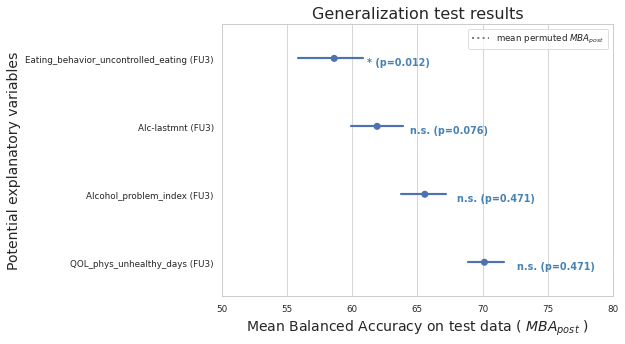

In [46]:
from scipy.stats import t

# f, axes = plt.subplots(2,1, figsize=(10,8), 
#                        sharex=True, sharey=True, 
#                        constrained_layout=True)
# axes = axes.ravel()
for cat, df_results_i in df_results.groupby('h5cat', sort=False):
    if cat in title_map.keys():
        # filter only selected confs
        valid_confs_i = valid_confs.Confound.unique().tolist()
        # valid_confs_i = valid_confs.loc[valid_confs.h5cat.str.replace('h5','')==cat.replace('h5','')].Confound
        # filter out model
        df_results_i = df_results_i.groupby('model').get_group('SVM-rbf')  
        df_results_i = df_results_i.loc[df_results_i.conf.isin(valid_confs_i)]
        # rename variables 
        df_results_i.conf = df_results_i.conf.apply(lambda x: x.replace('FU3', ' (FU3)') if 'FU3' in x else x+' (BL)')
        df_results_i = df_results_i.sort_values(['holdout_score'])
        f, ax = plt.subplots(figsize=(7,5))
        g = sns.pointplot(data=df_results_i, 
                      x='holdout_score', y='conf', 
                      # hue='model', hue_order=['SVM-rbf', 'GB'], ##@remove
                      ax=ax, 
                      dodge=True, join=False
                     )

        # plot the permutation results
        df_perm = pd.read_csv("../MLpipelines/results/holdout-posthoc-cc2-permuted_run.csv")
        df_perm = df_perm[df_perm.h5cat==cat]
        
        # get the pre-control scores:
        MBA_pre = pd.read_csv(f"results/results_explorative_h5{cat}.csv")['Accuracy BL'].unique()[0]
        # difference between MBApost and MBApre for permutation scores
        perm_scores = (df_perm.holdout_score.values - MBA_pre)
        perm_score_mean = perm_scores.mean()
        perm_scores = perm_scores-perm_score_mean
        # iter over all accuracy means
        points = g.collections[0]
        p_vals = []
        for i, point in enumerate(points.get_offsets()):
            # 2-tailed p-value calculation is correct? --> I adapted it based on this website: https://thomasleeper.com/Rcourse/Tutorials/permutationtests.html
            # difference between one empirical MBApost and permute mean
            true_score = (point[0]/100 - MBA_pre) - perm_score_mean 
            C = np.sum(abs(perm_scores) > abs(true_score))
            p_val = C/(len(perm_scores))
            p_vals.append((point,p_val))
            
        # multiple comparison correction
        from statsmodels.stats.multitest import multipletests
        _,p_vals_corr,_,_ = multipletests(list(zip(*p_vals))[1], method="fdr_bh")
        
        for i,(point, p_val) in enumerate(p_vals):
            p_val = p_vals_corr[i]
            g.text(point[0]+2.5, point[1]+0.1, #texts.append
                   f"{return_asterisks(p_val)} (p={p_val:.3f})",
                    color='steelblue', weight='bold')
            
        g.axvline((perm_score_mean)*100, 
                       color='grey', lw=2, ls=ls, label='mean permuted $MBA_{post}$') 

        fs=14 # fontsize
        g.set_xlabel(r"Mean Balanced Accuracy on test data ( $MBA_{post}$ )", fontdict={'fontsize':fs})
        g.set_ylabel("Potential explanatory variables", fontdict={'fontsize':fs})
        g.set_title(f"Generalization test results",
                   fontdict={'fontsize':fs+2})
        g.set_xlim([50,80])
        g.legend()
            
        plt.savefig(f"results/results-holdout-{cat}.jpg", bbox_inches='tight')
        plt.show()
        
        # save the results table

In [47]:
df_results_i[[]]

Unnamed: 0       io technique    model  trial  n_samples  n_samples_cc  \
5052        5052  X-Binge        cb  SVM-rbf      5        429           359   
5053        5053  X-Binge        cb  SVM-rbf      6        429           385   
3442        3442  X-Binge        cb  SVM-rbf      5        477           454   
3438        3438  X-Binge        cb  SVM-rbf      1        477           472   
5051        5051  X-Binge        cb  SVM-rbf      4        429           343   
3443        3443  X-Binge        cb  SVM-rbf      6        477           426   
5047        5047  X-Binge        cb  SVM-rbf      0        429           380   
5049        5049  X-Binge        cb  SVM-rbf      2        429           373   
5050        5050  X-Binge        cb  SVM-rbf      3        429           383   
5048        5048  X-Binge        cb  SVM-rbf      1        429           384   
3947        3947  X-Binge        cb  SVM-rbf      6        477           438   
3441        3441  X-Binge        cb  SVM-rbf      4        477           468   
3943        3943  X-Binge        cb  SVM-rbf      2        477           480   
3439        3439  X-Binge        cb  SVM-rbf      2        477           458   
3945        3945  X-Binge        cb  SVM-rbf      4        477           460   
3440        3440  X-Binge        cb  SVM-rbf      3        477           434   
3437        3437  X-Binge        cb  SVM-rbf      0        477           439   
3941        3941  X-Binge        cb  SVM-rbf      0        477           463   
3946        3946  X-Binge        cb  SVM-rbf      5        477           454   
3944        3944  X-Binge        cb  SVM-rbf      3        477           454   
3942        3942  X-Binge        cb  SVM-rbf      1        477           460   
4054        4054  X-Binge        cb  SVM-rbf      1        470           507   
4053        4053  X-Binge        cb  SVM-rbf      0        470           592   
4056        4056  X-Binge        cb  SVM-rbf      3        470           521   
4057        4057  X-Binge        cb  SVM-rbf      4        470           577   
4059        4059  X-Binge        cb  SVM-rbf      6        470           587   
4055        4055  X-Binge        cb  SVM-rbf      2        470           541   
4058        4058  X-Binge        cb  SVM-rbf      5        470           521   

      i      o  i_is_conf  ...  \
5052  X  Binge      False  ...   
5053  X  Binge      False  ...   
3442  X  Binge      False  ...   
3438  X  Binge      False  ...   
5051  X  Binge      False  ...   
3443  X  Binge      False  ...   
5047  X  Binge      False  ...   
5049  X  Binge      False  ...   
5050  X  Binge      False  ...   
5048  X  Binge      False  ...   
3947  X  Binge      False  ...   
3441  X  Binge      False  ...   
3943  X  Binge      False  ...   
3439  X  Binge      False  ...   
3945  X  Binge      False  ...   
3440  X  Binge      False  ...   
3437  X  Binge      False  ...   
3941  X  Binge      False  ...   
3946  X  Binge      False  ...   
3944  X  Binge      False  ...   
3942  X  Binge      False  ...   
4054  X  Binge      False  ...   
4053  X  Binge      False  ...   
4056  X  Binge      False  ...   
4057  X  Binge      False  ...   
4059  X  Binge      False  ...   
4055  X  Binge      False  ...   
4058  X  Binge      False  ...   

                                          holdout_probs  \
5052  [[0.7195, 0.2805], [0.7411, 0.2589], [0.8266, ...   
5053  [[0.6297, 0.3703], [0.7754, 0.2246], [0.768, 0...   
3442  [[0.4125, 0.5875], [0.7161, 0.2839], [0.7888, ...   
3438  [[0.4872, 0.5128], [0.746, 0.254], [0.7442, 0....   
5051  [[0.5429, 0.4571], [0.662, 0.338], [0.7106, 0....   
3443  [[0.3551, 0.6449], [0.7811, 0.2189], [0.8132, ...   
5047  [[0.4348, 0.5652], [0.6875, 0.3125], [0.8139, ...   
5049  [[0.6699, 0.3301], [0.7035, 0.2965], [0.744, 0...   
5050  [[0.5142, 0.4858], [0.7446, 0.2554], [0.8042, ...   
5048  [[0.7204, 0.2796], [0.738, 0.262], [0.6554, 0....   
3947  [[0.4091, 0.5909], [0.8319, 0.1681], [0.911

In [ ]:
df_results_i.to_csv("results/results_holdout.csv")

### Permutation test results

## Next steps
1. plot accuracy sMRI -> confounds

In [ ]:
# for result in sorted(glob(f"../MLpipelines/results/posthoc-cc2-*{conf.name}*/*/run.csv")):
#     df = pd.read_csv(result)
#     plot_result(df, x="test_score", no_confs=False)
#     plt.show()